### Requirements

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.datasets import mnist

In [8]:
!wandb login

wandb: Currently logged in as: cs24m021 (cs24m021-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


1. Check Nestrov Code
2. Update values in Q7
3. Change Sleep time to 10 mins
   

In [25]:
PROJECT = "DA6401_Assignment1"
ENTITY = "karan"
SWEEPCOUNT = 5

### Loading Data

In [10]:
# for question 1-8
(train_img, train_labels), (test_img, test_labels) = fashion_mnist.load_data()
target_classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# for question 10
(mnist_train, mnist_train_label), (mnist_test, mnist_test_label) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 39s 3us/step


## Question 1: Plot one sample per class

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: cs24m021 (cs24m021-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


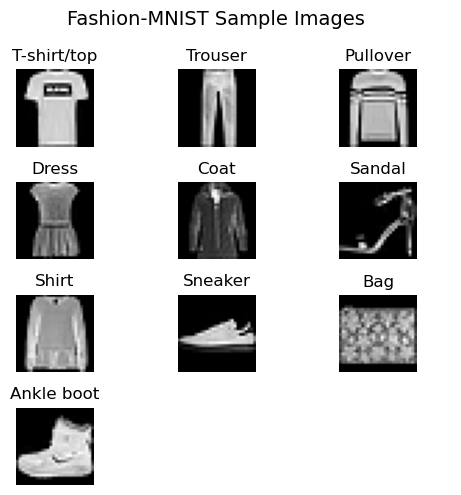

<Figure size 640x480 with 0 Axes>

In [11]:
wandb.init(project=PROJECT, name="Question_1")  
sample = []
for id in range(10):
    index = np.where(train_labels == id)[0][0]  # first occurrence of each class
    sample.append(train_img[index])  # corresponding image to the sample list

fig, axes = plt.subplots(4, 3, figsize=(5, 5))  
fig.suptitle("Fashion-MNIST Sample Images", fontsize=14)  

for i, ax in enumerate(axes.flat):
    if i < len(sample):
        ax.imshow(sample[i], cmap='gray')  # display the image in grayscale
        ax.set_title(target_classes[i]) 
        ax.axis("off") 
    else:
        ax.axis("off")  

plt.tight_layout() 
plt.show()
wandb.log({"Sample_Images": wandb.Image(plt)})  # logging to wandb
wandb.finish(); 

### Activation Functions

In [12]:
class Activation_Functions:
    def __init__(self):
        pass

    def sigmoid(self, x):
        result = np.zeros_like(x)
        result[x >= 0] = 1 / (1 + np.exp(-x[x >= 0]))  # for positive values
        result[x < 0] = np.exp(x[x < 0]) / (1 + np.exp(x[x < 0]))  # for negative values
        return result

    def ReLU(self, x):
        return np.maximum(0, x)  # ReLU activation

    def tanh(self, x):
        return np.tanh(x)  # hyperbolic tangent activation

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # numerical stability
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)  # softmax probabilities

    def identity(self, x):
        return x  # identity function

    def activation(self, x, fun):
        if fun == "tanh":
            return self.tanh(x)
        elif fun == "sigmoid":
            return self.sigmoid(x)
        elif fun == "ReLU":
            return self.ReLU(x)
        elif fun == "softmax":
            return self.softmax(x)
        elif fun == "identity":
            return self.identity(x)

### Loss Functions

In [13]:
class Loss_Function:
    def __init__(self):
        pass

    def compute_loss(self, y_true, y_pred, loss_function="cross_entropy"):
        if loss_function == "cross_entropy":
            epsilon = 1e-15
            y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # clip to avoid log(0)
            return np.mean(-np.sum(y_true * np.log(y_pred), axis=1))  # cross-entropy loss
        if loss_function == "mean_squared_error":
            return 0.5 * np.mean(np.sum((y_true - y_pred) ** 2, axis=1))  # MSE loss

    def last_output_derivative(self, y_pred, y_true, activation_derivative, loss_function="cross_entropy"):
        if loss_function == "mean_squared_error":
            return (y_pred - y_true) * activation_derivative / len(y_true)  # MSE derivative
        if loss_function == "cross_entropy":
            return -(y_true - y_pred)  # cross-entropy derivative

### Derivatioves

In [14]:
class Derivatives:
    def __init__(self):
        self.activation = Activation_Functions()

    def sigmoid_derivative(self, x):
        k = self.activation.sigmoid(x)
        return k * (1 - k)  # derivative of sigmoid

    def softmax_derivative(self, x):
        k = self.activation.softmax(x)
        return k * (1 - k)  # derivative of softmax

    def tanh_derivative(self, x):
        k = self.activation.tanh(x)
        return 1 - k ** 2  # derivative of tanh

    def ReLU_derivative(self, x):
        x[x > 0] = 1  # derivative is 1 for x > 0
        x[x <= 0] = 0  # derivative is 0 for x <= 0
        return x

    def identity_derivative(self, x):
        return np.ones_like(x)  # derivative of identity is 1

    def derivatives(self, x, activation_function):
        if activation_function == "sigmoid":
            return self.sigmoid_derivative(x)
        elif activation_function == "tanh":
            return self.tanh_derivative(x)
        elif activation_function == "ReLU":
            return self.ReLU_derivative(x)
        elif activation_function == "softmax":
            return self.softmax_derivative(x)
        elif activation_function == "identity":
            return self.identity_derivative(x)

## Question 2

In [15]:
def forward_pass(x, weights, biases, activation, layer_sizes):
    activation_func = Activation_Functions()
    outputs, activations = {}, {}
    outputs[0] = x  # input layer
    
    num_layers = len(layer_sizes)
    
    for layer in range(1, num_layers - 1):
        activations[layer] = np.dot(outputs[layer - 1], weights[layer]) + biases[layer]  # linear transformation
        outputs[layer] = activation_func.activation(activations[layer], fun=activation)  # apply activation
    
    activations[num_layers - 1] = np.dot(outputs[num_layers - 2], weights[num_layers - 1]) + biases[num_layers - 1]
    outputs[num_layers - 1] = activation_func.activation(activations[num_layers - 1], fun="softmax")  # softmax for output layer
    
    return outputs[num_layers - 1]  # final output

def Network_Q2(data, activation, input_size, layers, output_size):
    weights, biases = {}, {}
    layer_sizes = [input_size] + layers + [output_size]  # define layer sizes
    predicted_probs = []
    
    for layer in range(1, len(layer_sizes)):
        weights[layer] = np.random.randn(layer_sizes[layer - 1], layer_sizes[layer])  # initialize weights
        biases[layer] = np.random.randn(1, layer_sizes[layer])  # initialize biases
    
    for sample in data:
        x = sample.reshape(1, -1) / 255.0  # normalize input
        y_pred = forward_pass(x, weights, biases, activation, layer_sizes)  # forward pass
        predicted_probs.append(y_pred)  # store predictions
    
    return predicted_probs  # return all predictions

In [16]:
y_pred_Q2 = Network_Q2(train_img, "sigmoid", 784, [32, 32, 32], 10)  
print(np.array(y_pred_Q2[:5]).round(6))  # print first 5 predictions

[[[1.57900e-03 3.00000e-06 6.50500e-03 2.43000e-04 9.87728e-01
   4.49000e-04 2.78200e-03 2.61000e-04 4.41000e-04 9.00000e-06]]

 [[3.90000e-04 0.00000e+00 3.83700e-03 7.60000e-05 9.94544e-01
   1.40000e-04 7.92000e-04 9.30000e-05 1.24000e-04 4.00000e-06]]

 [[5.71000e-04 0.00000e+00 3.35700e-03 7.60000e-05 9.93482e-01
   2.83000e-04 9.34000e-04 2.17000e-04 1.05000e-03 3.10000e-05]]

 [[7.46000e-04 1.00000e-06 3.84200e-03 1.07000e-04 9.94341e-01
   1.84000e-04 5.04000e-04 1.37000e-04 1.31000e-04 6.00000e-06]]

 [[4.34000e-04 1.00000e-06 8.95200e-03 3.10000e-05 9.89027e-01
   1.27000e-04 1.16900e-03 3.50000e-05 2.20000e-04 4.00000e-06]]]


### Optimizers

In [17]:
class Optimizer:
    def __init__(self, model, config):
        self.model = model  
        self.learning_rate = config["eta"]  
        self.decay = config["weight_decay"]  
        self.optim_type = config["optimizer"]  
        self.momentum = config["momentum"] 
        self.beta1 = config["beta1"] 
        self.beta2 = config["beta2"]  
        self.epsilon_val = config["epsilon"]

    def update_parameters(self, timestep):
        if self.optim_type == "sgd":
            self.stochastic_gradient_descent()
        elif self.optim_type == "momentum":
            self.momentum_gradient_descent()
        elif self.optim_type == "nesterov" or self.optim_type == "nag" :
            self.nesterov_gradient_descent()
        elif self.optim_type == "rmsprop":
            self.rmsprop()
        elif self.optim_type == "adam":
            self.adam(timestep)
        elif self.optim_type == "nadam":
            self.nadam(timestep)

    def stochastic_gradient_descent(self):
        param_layers = self.model.weights.keys()
        for l in param_layers:
            reg_term = self.model.weights[l] * self.decay  # weight decay
            self.model.grad_weights[l] += reg_term
            bias_update = self.learning_rate * self.model.grad_biases[l]  # bias update
            self.model.biases[l] -= bias_update
            weight_update = self.learning_rate * self.model.grad_weights[l]  # weight update
            self.model.weights[l] -= weight_update

    def momentum_gradient_descent(self):
        for layer in self.model.weights.keys():
            self.model.grad_weights[layer] += self.decay * self.model.weights[layer]  # weight decay
            prev_momentum_w = self.momentum * self.model.m_weights[layer]
            new_momentum_w = prev_momentum_w + self.learning_rate * self.model.grad_weights[layer]  # momentum update
            prev_momentum_b = self.momentum * self.model.m_biases[layer]
            new_momentum_b = prev_momentum_b + self.learning_rate * self.model.grad_biases[layer]
            self.model.m_weights[layer] = new_momentum_w
            self.model.m_biases[layer] = new_momentum_b
            self.model.weights[layer] -= new_momentum_w
            self.model.biases[layer] -= new_momentum_b

    def nesterov_gradient_descent(self):
        for l in self.model.weights.keys():
            momentum_w = self.momentum * self.model.m_weights[l]  # momentum term
            lookahead_w = self.model.weights[l] - momentum_w  # lookahead step
            lookahead_b = self.model.biases[l] - self.momentum * self.model.m_biases[l]
            self.model.grad_weights[l] += lookahead_w * self.decay  # weight decay
            grad_w = self.model.grad_weights[l]
            grad_b = self.model.grad_biases[l]
            new_m_w = self.momentum * self.model.m_weights[l] - self.learning_rate * grad_w  # update momentum
            new_m_b = self.momentum * self.model.m_biases[l] - self.learning_rate * grad_b
            self.model.weights[l] += new_m_w
            self.model.biases[l] += new_m_b
            self.model.m_weights[l] = new_m_w
            self.model.m_biases[l] = new_m_b

    def rmsprop(self):
        for layer in self.model.weights.keys():
            current_grad_w = self.model.grad_weights[layer] + self.model.weights[layer] * self.decay  # weight decay
            current_grad_b = self.model.grad_biases[layer]
            self.model.v_weights[layer] = self.beta2*self.model.v_weights[layer] + (1-self.beta2)*(current_grad_w**2)  # velocity update
            self.model.v_biases[layer] = self.beta2*self.model.v_biases[layer] + (1-self.beta2)*(current_grad_b**2)
            epsilon = 1e-8 if self.epsilon_val < 1e-8 else self.epsilon_val  # numerical stability
            self.model.weights[layer] -= (current_grad_w * self.learning_rate) / (np.sqrt(self.model.v_weights[layer]) + epsilon)  # update weights
            self.model.biases[layer] -= (current_grad_b * self.learning_rate) / (np.sqrt(self.model.v_biases[layer]) + epsilon)

    def adam(self, step):
        for l in self.model.weights.keys():
            decay_contribution = self.decay * self.model.weights[l]  # weight decay
            self.model.grad_weights[l] += decay_contribution
            m_w = self.beta1 * self.model.m_weights[l] + (1-self.beta1)*self.model.grad_weights[l]  # momentum update
            m_b = self.beta1 * self.model.m_biases[l] + (1-self.beta1)*self.model.grad_biases[l]
            v_w = self.beta2 * self.model.v_weights[l] + (1-self.beta2)*(self.model.grad_weights[l]**2)  # velocity update
            v_b = self.beta2 * self.model.v_biases[l] + (1-self.beta2)*(self.model.grad_biases[l]**2)
            self.model.m_weights[l], self.model.v_weights[l] = m_w, v_w
            self.model.m_biases[l], self.model.v_biases[l] = m_b, v_b
            mw_corrected = m_w / (1 - self.beta1**step)  # bias correction
            vw_corrected = v_w / (1 - self.beta2**step)
            mb_corrected = m_b / (1 - self.beta1**step)
            vb_corrected = v_b / (1 - self.beta2**step)
            self.model.weights[l] -= self.learning_rate * mw_corrected / (np.sqrt(vw_corrected) + self.epsilon_val)  # update weights
            self.model.biases[l] -= self.learning_rate * mb_corrected / (np.sqrt(vb_corrected) + self.epsilon_val)

    def nadam(self, step):
        for l in self.model.weights.keys():
            self.model.grad_weights[l] += self.model.weights[l] * self.decay  # weight decay
            m_w_new = self.beta1 * self.model.m_weights[l] + (1-self.beta1)*self.model.grad_weights[l]  # momentum update
            m_b_new = self.beta1 * self.model.m_biases[l] + (1-self.beta1)*self.model.grad_biases[l]
            v_w_new = self.beta2 * self.model.v_weights[l] + (1-self.beta2)*(self.model.grad_weights[l]**2)  # velocity update
            v_b_new = self.beta2 * self.model.v_biases[l] + (1-self.beta2)*(self.model.grad_biases[l]**2)
            mw_hat = m_w_new / (1 - self.beta1**step)  # bias correction
            vw_hat = v_w_new / (1 - self.beta2**step)
            mb_hat = m_b_new / (1 - self.beta1**step)
            vb_hat = v_b_new / (1 - self.beta2**step)
            nesterov_w = self.beta1 * mw_hat + (1-self.beta1)*self.model.grad_weights[l]/(1-self.beta1**step)  # Nesterov component
            nesterov_b = self.beta1 * mb_hat + (1-self.beta1)*self.model.grad_biases[l]/(1-self.beta1**step)
            self.model.weights[l] -= self.learning_rate * nesterov_w / (np.sqrt(vw_hat) + self.epsilon_val)  # update weights
            self.model.biases[l] -= self.learning_rate * nesterov_b / (np.sqrt(vb_hat) + self.epsilon_val)
            self.model.m_weights[l], self.model.v_weights[l] = m_w_new, v_w_new
            self.model.m_biases[l], self.model.v_biases[l] = m_b_new, v_b_new

### Final Neural Network Functionalities

In [29]:
class Neural_Network:
    def __init__(self, config, log=1, console=1):
        self.weights, self.biases, self.a, self.h = {}, {}, {}, {}
        self.grad_weights, self.grad_biases, self.m_weights, self.m_biases = {}, {}, {}, {}
        self.v_weights, self.v_biases = {}, {}

        self.activation_function = config["activation_function"]
        self.loss_function = config["loss_function"]
        self.initialization = config["init"]
        self.hidden_layers = config["hidden_layers"]
        self.hidden_layer_sizes = config["hidden_layer_sizes"]
        self.dataset = config["dataset"]
        self.wan_log, self.console_log = log, console
        self.loss = Loss_Function()
        self.act = Activation_Functions()
        self.derivative = Derivatives()

        (train_img, train_lbl), (test_img, test_lbl) = self.load_dataset()
        train_img, val_img, train_lbl, val_lbl = train_test_split(train_img, train_lbl, test_size=0.1, random_state=41)

        self.input, self.y_true = self.preprocess_data(train_img, train_lbl)  # preprocess training data
        self.val_img, self.val_true = self.preprocess_data(val_img, val_lbl)  # preprocess validation data
        self.test_img, self.test_true = self.preprocess_data(test_img, test_lbl)  # preprocess test data
        self.layers = [self.input.shape[1]] + [self.hidden_layer_sizes] * self.hidden_layers + [10]  
        
        self.initialize_parameters()  # initialize weights and biases

    def load_dataset(self):
        if self.dataset == 'fashion_mnist':
            return (train_img, train_labels), (test_img, test_labels)
        if self.dataset == 'mnist':
            return (mnist_train, mnist_train_label), (mnist_test, mnist_test_label)
        else:
            raise ValueError("Unknown dataset")

    def preprocess_data(self, images, labels):
        return images.reshape(images.shape[0], -1) / 255.0 , labels  # normalize and reshape data

    def initialize_parameters(self):
        for layer in range(1, len(self.layers)):
            self.m_weights[layer] = np.zeros((self.layers[layer-1], self.layers[layer]))  # initialize momentum for weights
            self.m_biases[layer] = np.zeros((1, self.layers[layer]))  # initialize momentum for biases
            self.v_weights[layer] = np.zeros((self.layers[layer-1], self.layers[layer]))  # initialize velocity for weights
            self.v_biases[layer] = np.zeros((1, self.layers[layer]))  # initialize velocity for biases

            if self.initialization == "random":
                self.weights[layer] = np.random.randn(self.layers[layer-1], self.layers[layer])  # random initialization
                self.biases[layer] = np.random.randn(1, self.layers[layer])
            elif self.initialization == "Xavier":
                variance_w = 6.0 / (self.layers[layer-1] + self.layers[layer])  # Xavier initialization for weights
                variance_b = 6.0 / (1 + self.layers[layer])  # Xavier initialization for biases
                self.weights[layer] = np.random.randn(self.layers[layer-1], self.layers[layer]) * np.sqrt(variance_w)
                self.biases[layer] = np.random.randn(1, self.layers[layer]) * np.sqrt(variance_b)

    def forward_propagation(self, x):
        self.h[0] = x
        for layer in range(1, len(self.layers)-1):
            self.a[layer] = np.dot(self.h[layer-1], self.weights[layer]) + self.biases[layer]  # linear transformation
            self.h[layer] = self.act.activation(self.a[layer], self.activation_function)  # apply activation
        self.a[layer+1] = np.dot(self.h[layer], self.weights[layer+1]) + self.biases[layer+1]
        self.h[layer+1] = self.act.activation(self.a[layer+1], "softmax")  # softmax for output layer
        return self.h[layer+1]

    def backward_propagation(self, x, y_true, y_hat):
        activation_derivative = self.derivative.derivatives(self.a[len(self.layers) - 1], "softmax")  
        error_wrt_output = self.loss.last_output_derivative(y_hat, y_true, activation_derivative, self.loss_function)  # error at output

        for layer in range(len(self.layers)-1, 1, -1):
            self.grad_weights[layer] = np.dot(self.h[layer-1].T, error_wrt_output)  # gradient for weights
            self.grad_biases[layer] = np.sum(error_wrt_output, axis=0, keepdims=True)  # gradient for biases
            error_wrt_hidden = np.dot(error_wrt_output, self.weights[layer].T)  
            error_wrt_output = error_wrt_hidden * self.derivative.derivatives(self.a[layer-1], self.activation_function)  

        self.grad_weights[1] = np.dot(x.T, error_wrt_output)  
        self.grad_biases[1] = np.sum(error_wrt_output, axis=0, keepdims=True)  

    def one_hot_matrix(self, labels):
        mat = np.zeros((labels.shape[0], 10)) 
        mat[np.arange(labels.shape[0]), labels] = 1
        return mat

    def compute_performance(self, data, labels):
        y_pred = self.forward_propagation(data)  # forward pass
        one_hot_labels = self.one_hot_matrix(labels)  # convert labels to one-hot
        accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(one_hot_labels, axis=1)) * 100 
        loss = self.loss.compute_loss(one_hot_labels, y_pred, self.loss_function)  
        return loss, accuracy

    
    def probability(self, data):
        return self.forward_propagation(data)  

        
    def fit(self, batch_size, epochs, optimizer):
        total_batches = int(np.ceil(self.input.shape[0] / batch_size))  # total batches
        for epoch in range(epochs):
            t = 1
            for batch in range(total_batches):
                batch_start, batch_end = batch * batch_size, (batch + 1) * batch_size 
                image_set, label_set = self.input[batch_start:batch_end], self.y_true[batch_start:batch_end] 
                y_hat = self.forward_propagation(image_set)  # forward pass
                self.backward_propagation(image_set, self.one_hot_matrix(label_set), y_hat)  # backward pass
                for layer in range(1, len(self.layers)):
                    self.grad_weights[layer] /= batch_size  # normalize gradients
                    self.grad_biases[layer] /= batch_size
                optimizer.update_parameters(t)  # updated parameters
                t += 1
            
            t_loss, t_acc = self.compute_performance(self.input, self.y_true)  # train performance
            v_loss, v_acc = self.compute_performance(self.val_img, self.val_true)  # validation performance
            
            if self.wan_log:
                wandb.log({'epoch': epoch + 1, 'train_loss': t_loss, 'train_acc': t_acc, 'val_loss': v_loss, 'val_acc': v_acc})  # log to wandb
            if self.console_log:
                print(f"Epoch {epoch+1}: Train Loss={t_loss:.4f}, Train Acc={t_acc:.2f}%, Val Loss={v_loss:.4f}, Val Acc={v_acc:.2f}%")  # console log
        
        return t_loss, t_acc, v_loss, v_acc 

## Question 3

In [19]:
for opt in ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]:
    print("Optimiser: " + opt + "\n")
    config_nn = {
        "hidden_layers": 4,
        "hidden_layer_sizes": 128,
        "activation_function": "sigmoid",  
        "dataset": "fashion_mnist",
        "loss_function": "cross_entropy",  
        "init": "random"  
    }
    
    config_opt = {
        "eta": 0.005,
        "optimizer": f"{opt}",  
        "beta": 0.9,
        "weight_decay": 0.0005,
        "epsilon": 1e-8,
        "beta2": 0.999,
        "beta1": 0.9,
        "momentum": 0.9
    }
    
    nn = Neural_Network(config_nn, log=0, console=1)
    optimizer = Optimizer(nn, config_opt)
    
    t_loss, t_acc, v_loss, v_acc = nn.fit(batch_size=64, epochs=5, optimizer=optimizer)
    loss, accuracy = nn.compute_performance(nn.test_img, nn.test_true)  # evaluate on test data
    print(f"Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}%")  # print test loss and accuracy
    print()
    print()


Optimiser: sgd

Epoch 1: Train Loss=1.6624, Train Acc=43.97%, Val Loss=1.6935, Val Acc=42.98%
Epoch 2: Train Loss=1.2949, Train Acc=54.56%, Val Loss=1.3271, Val Acc=53.45%
Epoch 3: Train Loss=1.1405, Train Acc=59.52%, Val Loss=1.1712, Val Acc=58.57%
Epoch 4: Train Loss=1.0485, Train Acc=62.39%, Val Loss=1.0775, Val Acc=62.07%
Epoch 5: Train Loss=0.9870, Train Acc=64.46%, Val Loss=1.0146, Val Acc=64.02%
Test-loss: 1.0271386806343263, Test-accuracy: 63.480000000000004%


Optimiser: momentum

Epoch 1: Train Loss=0.8578, Train Acc=69.41%, Val Loss=0.8806, Val Acc=68.65%
Epoch 2: Train Loss=0.7211, Train Acc=74.18%, Val Loss=0.7455, Val Acc=72.80%
Epoch 3: Train Loss=0.6583, Train Acc=76.38%, Val Loss=0.6822, Val Acc=74.65%
Epoch 4: Train Loss=0.6186, Train Acc=77.83%, Val Loss=0.6420, Val Acc=76.05%
Epoch 5: Train Loss=0.5894, Train Acc=78.95%, Val Loss=0.6131, Val Acc=77.02%
Test-loss: 0.6307034803312049, Test-accuracy: 76.66%


Optimiser: nesterov

Epoch 1: Train Loss=0.8628, Train Acc=6

KeyboardInterrupt: 

## Question 4

In [14]:
# sweep configuration as specified in question maximizing test accuracy
sweep_config = {
    "method": "bayes",  
    "project": f"{PROJECT}",
    "metric": {"name": "test_accuracy", "goal": "maximize"},
    "parameters": {
        "epochs": {"values": [5, 10]},
        "hidden_layers": {"values": [3, 4, 5]},
        "hidden_layer_sizes": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "activation": {"values": ["sigmoid", "tanh", "ReLU"]},
        "initialization": {"values": ["Xavier", "random"]},
        "dataset": {"values": ["fashion_mnist"]}
    }
}

In [ ]:
# to call inside wandb.agent()
def train(loss_function):
    sw = wandb.init(project = PROJECT)
    sw = sw.config

    wandb.run.name = f"opt_{sw.optimizer}_hl_{sw.hidden_layers}_bs_{sw.batch_size}_e_{sw.epochs}_act_{sw.activation}_eta_{sw.learning_rate}_init_{sw.initialization}_hls_{sw.hidden_layer_sizes}_dataset_{sw.dataset}_{loss_function}"
    # Example: opt_adam_hl_4_bs_32_e_10_act_ReLU_eta_0.001_init_Xavier_hls_64_dataset_fashion_mnist_cross_entropy
    
    config_nn = {
        "hidden_layers": sw.hidden_layers,
        "hidden_layer_sizes" : sw.hidden_layer_sizes,
        "activation_function": sw.activation, 
        "loss_function" : loss_function,
        "init" : sw.initialization, 
        "dataset" : sw.dataset
    }

    config_opt = {
        "eta": sw.learning_rate,
        "optimizer": sw.optimizer, 
        "beta": 0.9,
        "weight_decay": sw.weight_decay,
        "epsilon": 1e-8,
        "beta2" : 0.999,
        "beta1" : 0.9,
        "momentum" : 0.9
    }

    nn = Neural_Network(config_nn,log = 1,console=1)
    opt = Optimizer(nn, config_opt)

    t_loss, t_acc, v_loss, v_acc = nn.fit(batch_size=sw.batch_size, epochs=sw.epochs, optimizer=opt)

    loss, accuracy = nn.compute_performance(nn.test_img, nn.test_true)  # evaluate on test data
    print(f"Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}%")  # print test loss and accuracy
    wandb.log({"test_accuracy" : accuracy})
    

In [ ]:
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id,  lambda : train(loss_function = "cross_entropy"), count = SWEEPCOUNT)
wandb.finish()

## Question 7 (Insert Best Parameters below)

In [20]:
def generate_and_plot_confusion_matrix(y_pred, y_true):
    wandb.init(project=PROJECT, name="Question:7")  
    
    num_classes = len(target_classes)
    mat = np.zeros((num_classes, num_classes), dtype=int)  
    class_pred = np.argmax(y_pred, axis=1)  # predicted classes
    
    for i in range(y_true.shape[0]):
        true_label = int(y_true[i])
        pred_label = int(class_pred[i])
        if 0 <= true_label < num_classes and 0 <= pred_label < num_classes:
            mat[true_label][pred_label] += 1  # update confusion matrix
        else:
            print(f"Skipping invalid index: y_true={true_label}, y_pred={pred_label}")

    # print(mat)
    df_confusion = pd.DataFrame(mat, index=target_classes, columns=target_classes)  

    plt.figure(figsize=(10, 12))
    ax = sns.heatmap(df_confusion, annot=True, fmt='d', linewidths=4, linecolor='white', cmap="Reds")  # plot heatmap
    ax.set_xticklabels(target_classes, rotation=90)
    ax.set_yticklabels(target_classes, rotation=0)
    plt.title('Confusion Matrix', fontsize=12)
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")

    wandb.log({"Confusion_Matrix": wandb.Image(plt)})  # log confusion matrix to wandb
    plt.show()
    wandb.finish()

Epoch 1: Train Loss=0.7990, Train Acc=72.45%, Val Loss=0.8010, Val Acc=72.55%
Epoch 2: Train Loss=0.6711, Train Acc=76.00%, Val Loss=0.6801, Val Acc=75.62%
Epoch 3: Train Loss=0.6117, Train Acc=77.97%, Val Loss=0.6228, Val Acc=77.82%
Epoch 4: Train Loss=0.5701, Train Acc=79.49%, Val Loss=0.5831, Val Acc=78.82%
Epoch 5: Train Loss=0.5352, Train Acc=80.78%, Val Loss=0.5491, Val Acc=79.88%
Test-loss: 0.5650, Test-accuracy: 79.82%


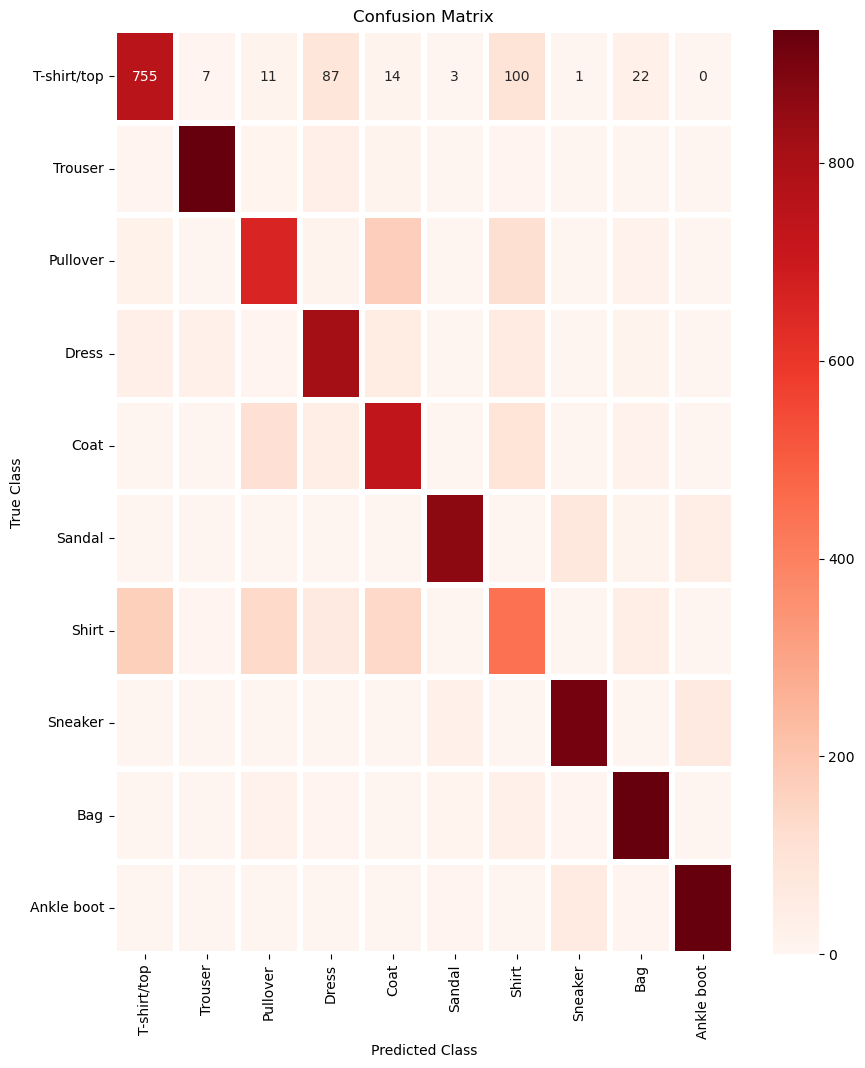

In [23]:
config_nn = {
    "hidden_layers": 4,
    "hidden_layer_sizes": 64,
    "activation_function": "sigmoid",  
    "dataset": "fashion_mnist",
    "loss_function": "cross_entropy",  
    "init": "random"  
}

config_opt = {
    "eta": 0.0005,
    "optimizer": "adam",  
    "beta": 0.9,
    "weight_decay": 0.0005,
    "epsilon": 1e-8,
    "beta2": 0.999,
    "beta1": 0.9,
    "momentum": 0.9
}

nn = Neural_Network(config_nn, log=0, console=1)
optimizer = Optimizer(nn, config_opt)

t_loss, t_acc, v_loss, v_acc = nn.fit(batch_size=64, epochs=5, optimizer=optimizer)
loss, accuracy = nn.compute_performance(nn.test_img, nn.test_true)  # evaluate on test data
print(f"Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}%")  # print test loss and accuracy
y_pred = nn.probability(nn.test_img)
generate_and_plot_confusion_matrix(y_pred, nn.test_true) # plot confusion matrox

## Question 8

In [21]:
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id,  lambda : train(loss_function = "mean_squared_error"), count = SWEEPCOUNT)
wandb.finish()

Create sweep with ID: ybvx48qp
Sweep URL: https://wandb.ai/cs24m021-iit-madras/DA6401_Assignment1/sweeps/ybvx48qp


wandb: Agent Starting Run: 0bx45nxr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4511, Train Acc=9.98%, Val Loss=0.4508, Val Acc=10.15%
Epoch 2: Train Loss=0.4513, Train Acc=9.98%, Val Loss=0.4510, Val Acc=10.15%
Epoch 3: Train Loss=0.4514, Train Acc=9.98%, Val Loss=0.4510, Val Acc=10.15%
Epoch 4: Train Loss=0.4514, Train Acc=9.98%, Val Loss=0.4510, Val Acc=10.15%
Epoch 5: Train Loss=0.4513, Train Acc=9.98%, Val Loss=0.4510, Val Acc=10.15%
Test-loss : 0.4513133660252787, Test-accuracy:10.0%
0.4513133660252787 10.0


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,▁▆██▇
val_acc,▁▁▁▁▁
val_loss,▁▅██▇
epoch,5
test_accuracy,10
train_acc,9.98333
train_loss,0.45135
val_acc,10.15


wandb: Agent Starting Run: 8nvu14fl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5742, Train Acc=9.97%, Val Loss=0.5726, Val Acc=10.30%
Epoch 2: Train Loss=0.5716, Train Acc=9.97%, Val Loss=0.5701, Val Acc=10.30%
Epoch 3: Train Loss=0.5692, Train Acc=9.97%, Val Loss=0.5677, Val Acc=10.30%
Epoch 4: Train Loss=0.5669, Train Acc=9.97%, Val Loss=0.5654, Val Acc=10.30%
Epoch 5: Train Loss=0.5647, Train Acc=9.97%, Val Loss=0.5632, Val Acc=10.30%
Test-loss : 0.564545891558782, Test-accuracy:10.0%
0.564545891558782 10.0


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▁▁▁▁
train_loss,█▆▄▃▁
val_acc,▁▁▁▁▁
val_loss,█▆▄▃▁
epoch,5
test_accuracy,10
train_acc,9.96667
train_loss,0.56469
val_acc,10.3


wandb: Agent Starting Run: 6bacneiv with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=0.4669, Train Acc=10.07%, Val Loss=0.4685, Val Acc=9.40%
Epoch 2: Train Loss=0.4640, Train Acc=10.07%, Val Loss=0.4654, Val Acc=9.40%
Epoch 3: Train Loss=0.4581, Train Acc=10.07%, Val Loss=0.4590, Val Acc=9.40%
Epoch 4: Train Loss=0.4544, Train Acc=10.07%, Val Loss=0.4550, Val Acc=9.40%
Epoch 5: Train Loss=0.4521, Train Acc=10.07%, Val Loss=0.4526, Val Acc=9.40%
Epoch 6: Train Loss=0.4510, Train Acc=10.07%, Val Loss=0.4513, Val Acc=9.40%
Epoch 7: Train Loss=0.4505, Train Acc=10.07%, Val Loss=0.4507, Val Acc=9.40%
Epoch 8: Train Loss=0.4502, Train Acc=10.07%, Val Loss=0.4503, Val Acc=9.40%
Epoch 9: Train Loss=0.4501, Train Acc=10.07%, Val Loss=0.4502, Val Acc=9.40%
Epoch 10: Train Loss=0.4500, Train Acc=10.07%, Val Loss=0.4501, Val Acc=9.40%
Test-loss : 0.4500406327678078, Test-accuracy:10.0%
0.4500406327678078 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▄▃▂▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▂▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,10.06667
train_loss,0.45003
val_acc,9.4


wandb: Agent Starting Run: sowd7v6i with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1224, Train Acc=83.62%, Val Loss=0.1274, Val Acc=82.50%
Epoch 2: Train Loss=0.1110, Train Acc=84.95%, Val Loss=0.1157, Val Acc=84.40%
Epoch 3: Train Loss=0.1047, Train Acc=85.38%, Val Loss=0.1074, Val Acc=84.78%
Epoch 4: Train Loss=0.1036, Train Acc=85.16%, Val Loss=0.1071, Val Acc=84.88%
Epoch 5: Train Loss=0.1070, Train Acc=84.49%, Val Loss=0.1126, Val Acc=83.75%
Epoch 6: Train Loss=0.1138, Train Acc=83.46%, Val Loss=0.1212, Val Acc=82.32%
Epoch 7: Train Loss=0.1065, Train Acc=84.44%, Val Loss=0.1154, Val Acc=83.53%
Epoch 8: Train Loss=0.0998, Train Acc=85.56%, Val Loss=0.1088, Val Acc=84.33%
Epoch 9: Train Loss=0.0922, Train Acc=86.98%, Val Loss=0.1021, Val Acc=85.72%
Epoch 10: Train Loss=0.0911, Train Acc=87.16%, Val Loss=0.1021, Val Acc=85.65%
Test-loss : 0.1085749313988904, Test-accuracy:84.47%
0.1085749313988904 84.47


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▄▃▁▃▅██
train_loss,█▅▄▄▅▆▄▃▁▁
val_acc,▁▅▆▆▄▁▄▅██
val_loss,█▅▂▂▄▆▅▃▁▁
epoch,10
test_accuracy,84.47
train_acc,87.16481
train_loss,0.09108
val_acc,85.65


wandb: Agent Starting Run: nesjhvg7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4501, Val Acc=10.12%
Epoch 2: Train Loss=0.4502, Train Acc=9.91%, Val Loss=0.4500, Val Acc=10.80%
Epoch 3: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 4: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 5: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 6: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 7: Train Loss=0.4501, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 8: Train Loss=0.4501, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 9: Train Loss=0.4501, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Epoch 10: Train Loss=0.4501, Train Acc=9.99%, Val Loss=0.4500, Val Acc=10.12%
Test-loss : 0.4500672001653802, Test-accuracy:10.0%
0.4500672001653802 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,█▁████████
train_loss,██▇▆▆▅▄▃▂▁
val_acc,▁█▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▃▂▂▁▁
epoch,10
test_accuracy,10
train_acc,9.98704
train_loss,0.45007
val_acc,10.11667


wandb: Agent Starting Run: nlgd8bfg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4591, Train Acc=19.24%, Val Loss=0.4609, Val Acc=18.27%
Epoch 2: Train Loss=0.3940, Train Acc=36.56%, Val Loss=0.3947, Val Acc=36.35%
Epoch 3: Train Loss=0.3542, Train Acc=44.28%, Val Loss=0.3553, Val Acc=44.37%
Epoch 4: Train Loss=0.3252, Train Acc=51.73%, Val Loss=0.3257, Val Acc=52.07%
Epoch 5: Train Loss=0.3114, Train Acc=55.60%, Val Loss=0.3113, Val Acc=54.83%
Epoch 6: Train Loss=0.3035, Train Acc=59.53%, Val Loss=0.3048, Val Acc=58.70%
Epoch 7: Train Loss=0.3109, Train Acc=60.85%, Val Loss=0.3130, Val Acc=60.02%
Epoch 8: Train Loss=0.3271, Train Acc=60.61%, Val Loss=0.3290, Val Acc=59.78%
Epoch 9: Train Loss=0.3501, Train Acc=56.14%, Val Loss=0.3515, Val Acc=55.45%
Epoch 10: Train Loss=0.3817, Train Acc=52.82%, Val Loss=0.3829, Val Acc=52.45%
Test-loss : 0.3818977969551933, Test-accuracy:52.88%
0.3818977969551933 52.88


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇███▇▇
train_loss,█▅▃▂▁▁▁▂▃▅
val_acc,▁▄▅▇▇███▇▇
val_loss,█▅▃▂▁▁▁▂▃▅
epoch,10
test_accuracy,52.88
train_acc,52.82407
train_loss,0.38171
val_acc,52.45


wandb: Agent Starting Run: euklm7c8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.7717, Train Acc=10.92%, Val Loss=0.7731, Val Acc=11.15%
Epoch 2: Train Loss=0.7714, Train Acc=10.93%, Val Loss=0.7728, Val Acc=11.13%
Epoch 3: Train Loss=0.7710, Train Acc=10.94%, Val Loss=0.7725, Val Acc=11.17%
Epoch 4: Train Loss=0.7707, Train Acc=10.97%, Val Loss=0.7722, Val Acc=11.13%
Epoch 5: Train Loss=0.7703, Train Acc=11.01%, Val Loss=0.7719, Val Acc=11.20%
Test-loss : 0.7708013612001632, Test-accuracy:10.780000000000001%
0.7708013612001632 10.780000000000001


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▂▃▅█
train_loss,█▆▄▃▁
val_acc,▃▁▅▁█
val_loss,█▆▄▃▁
epoch,5
test_accuracy,10.78
train_acc,11.00926
train_loss,0.77032
val_acc,11.2


wandb: Agent Starting Run: qdn38hyv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.8387, Train Acc=8.62%, Val Loss=0.8426, Val Acc=8.22%
Epoch 2: Train Loss=0.8368, Train Acc=8.76%, Val Loss=0.8414, Val Acc=8.30%
Epoch 3: Train Loss=0.8349, Train Acc=8.86%, Val Loss=0.8396, Val Acc=8.47%
Epoch 4: Train Loss=0.8329, Train Acc=9.04%, Val Loss=0.8370, Val Acc=8.55%
Epoch 5: Train Loss=0.8311, Train Acc=9.20%, Val Loss=0.8349, Val Acc=8.48%
Epoch 6: Train Loss=0.8296, Train Acc=9.34%, Val Loss=0.8335, Val Acc=8.78%
Epoch 7: Train Loss=0.8282, Train Acc=9.39%, Val Loss=0.8321, Val Acc=8.75%
Epoch 8: Train Loss=0.8270, Train Acc=9.48%, Val Loss=0.8308, Val Acc=8.78%
Epoch 9: Train Loss=0.8258, Train Acc=9.63%, Val Loss=0.8300, Val Acc=8.90%
Epoch 10: Train Loss=0.8243, Train Acc=9.71%, Val Loss=0.8292, Val Acc=9.07%
Test-loss : 0.8201371520046492, Test-accuracy:10.02%
0.8201371520046492 10.02


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▅▆▆▇▇█
train_loss,█▇▆▅▄▄▃▂▂▁
val_acc,▁▂▃▄▃▆▅▆▇█
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,10
test_accuracy,10.02
train_acc,9.71111
train_loss,0.8243
val_acc,9.06667


wandb: Agent Starting Run: aimahr7f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6571, Train Acc=8.81%, Val Loss=0.6541, Val Acc=9.10%
Epoch 2: Train Loss=0.5623, Train Acc=9.42%, Val Loss=0.5619, Val Acc=9.52%
Epoch 3: Train Loss=0.5239, Train Acc=10.67%, Val Loss=0.5251, Val Acc=10.48%
Epoch 4: Train Loss=0.5064, Train Acc=13.27%, Val Loss=0.5084, Val Acc=12.47%
Epoch 5: Train Loss=0.5005, Train Acc=14.65%, Val Loss=0.5026, Val Acc=13.78%
Epoch 6: Train Loss=0.4981, Train Acc=15.09%, Val Loss=0.5001, Val Acc=13.93%
Epoch 7: Train Loss=0.4956, Train Acc=15.49%, Val Loss=0.4975, Val Acc=14.72%
Epoch 8: Train Loss=0.4926, Train Acc=15.94%, Val Loss=0.4944, Val Acc=15.25%
Epoch 9: Train Loss=0.4893, Train Acc=16.48%, Val Loss=0.4911, Val Acc=15.95%
Epoch 10: Train Loss=0.4858, Train Acc=16.97%, Val Loss=0.4874, Val Acc=16.33%
Test-loss : 0.48474586046054535, Test-accuracy:17.23%
0.48474586046054535 17.23


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▅▆▆▇▇██
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▁▂▄▆▆▆▇██
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
test_accuracy,17.23
train_acc,16.97407
train_loss,0.48575
val_acc,16.33333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8hgr7198 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.7703, Train Acc=8.92%, Val Loss=0.7731, Val Acc=8.78%
Epoch 2: Train Loss=0.7701, Train Acc=8.95%, Val Loss=0.7728, Val Acc=8.82%
Epoch 3: Train Loss=0.7698, Train Acc=8.96%, Val Loss=0.7726, Val Acc=8.82%
Epoch 4: Train Loss=0.7696, Train Acc=8.97%, Val Loss=0.7724, Val Acc=8.82%
Epoch 5: Train Loss=0.7694, Train Acc=9.01%, Val Loss=0.7721, Val Acc=8.82%
Test-loss : 0.7685225580142199, Test-accuracy:9.02%
0.7685225580142199 9.02


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▃▅▅█
train_loss,█▆▄▃▁
val_acc,▁████
val_loss,█▆▄▃▁
epoch,5
test_accuracy,9.02
train_acc,9.00556
train_loss,0.76939
val_acc,8.81667


wandb: Agent Starting Run: cvrn4tg5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4954, Train Acc=11.21%, Val Loss=0.4962, Val Acc=10.77%
Epoch 2: Train Loss=0.4586, Train Acc=17.64%, Val Loss=0.4589, Val Acc=16.97%
Epoch 3: Train Loss=0.4295, Train Acc=26.07%, Val Loss=0.4296, Val Acc=26.00%
Epoch 4: Train Loss=0.4046, Train Acc=33.06%, Val Loss=0.4048, Val Acc=33.32%
Epoch 5: Train Loss=0.3857, Train Acc=37.04%, Val Loss=0.3859, Val Acc=36.88%
Test-loss : 0.38401716722857915, Test-accuracy:37.22%
0.38401716722857915 37.22


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▁▃▅▇█
train_loss,█▆▄▂▁
val_acc,▁▃▅▇█
val_loss,█▆▄▂▁
epoch,5
test_accuracy,37.22
train_acc,37.04074
train_loss,0.38566
val_acc,36.88333


wandb: Agent Starting Run: sxhjdnfi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.7603, Train Acc=8.48%, Val Loss=0.7593, Val Acc=8.50%
Epoch 2: Train Loss=0.7571, Train Acc=8.65%, Val Loss=0.7558, Val Acc=8.78%
Epoch 3: Train Loss=0.7541, Train Acc=8.90%, Val Loss=0.7521, Val Acc=9.07%
Epoch 4: Train Loss=0.7511, Train Acc=9.12%, Val Loss=0.7491, Val Acc=9.23%
Epoch 5: Train Loss=0.7484, Train Acc=9.23%, Val Loss=0.7468, Val Acc=9.52%
Epoch 6: Train Loss=0.7457, Train Acc=9.42%, Val Loss=0.7450, Val Acc=9.47%
Epoch 7: Train Loss=0.7428, Train Acc=9.63%, Val Loss=0.7438, Val Acc=9.53%
Epoch 8: Train Loss=0.7396, Train Acc=9.84%, Val Loss=0.7423, Val Acc=9.53%
Epoch 9: Train Loss=0.7365, Train Acc=10.11%, Val Loss=0.7389, Val Acc=9.95%
Epoch 10: Train Loss=0.7335, Train Acc=10.25%, Val Loss=0.7345, Val Acc=10.28%
Test-loss : 0.7323803360249638, Test-accuracy:10.25%
0.7323803360249638 10.25


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▄▅▆▆▇█
train_loss,█▇▆▆▅▄▃▃▂▁
val_acc,▁▂▃▄▅▅▅▅▇█
val_loss,█▇▆▅▄▄▄▃▂▁
epoch,10
test_accuracy,10.25
train_acc,10.2463
train_loss,0.73346
val_acc,10.28333


wandb: Agent Starting Run: kttaxhqq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.2695, Train Acc=61.83%, Val Loss=0.2694, Val Acc=61.73%
Epoch 2: Train Loss=0.2721, Train Acc=62.80%, Val Loss=0.2717, Val Acc=62.65%
Epoch 3: Train Loss=0.2758, Train Acc=62.19%, Val Loss=0.2752, Val Acc=62.15%
Epoch 4: Train Loss=0.2780, Train Acc=60.31%, Val Loss=0.2772, Val Acc=60.08%
Epoch 5: Train Loss=0.2808, Train Acc=58.89%, Val Loss=0.2799, Val Acc=59.03%
Test-loss : 0.2810262077868296, Test-accuracy:58.650000000000006%
0.2810262077868296 58.650000000000006


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▆█▇▄▁
train_loss,▁▃▅▆█
val_acc,▆█▇▃▁
val_loss,▁▃▅▆█
epoch,5
test_accuracy,58.65
train_acc,58.89259
train_loss,0.28077
val_acc,59.03333


wandb: Agent Starting Run: xgznkjb1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1: Train Loss=0.4723, Train Acc=10.02%, Val Loss=0.4729, Val Acc=9.80%
Epoch 2: Train Loss=0.4709, Train Acc=10.02%, Val Loss=0.4715, Val Acc=9.80%
Epoch 3: Train Loss=0.4697, Train Acc=10.02%, Val Loss=0.4702, Val Acc=9.80%
Epoch 4: Train Loss=0.4685, Train Acc=10.02%, Val Loss=0.4691, Val Acc=9.80%
Epoch 5: Train Loss=0.4675, Train Acc=10.02%, Val Loss=0.4680, Val Acc=9.80%
Epoch 6: Train Loss=0.4666, Train Acc=10.02%, Val Loss=0.4671, Val Acc=9.80%
Epoch 7: Train Loss=0.4657, Train Acc=10.02%, Val Loss=0.4663, Val Acc=9.80%
Epoch 8: Train Loss=0.4650, Train Acc=10.02%, Val Loss=0.4655, Val Acc=9.80%
Epoch 9: Train Loss=0.4643, Train Acc=10.02%, Val Loss=0.4648, Val Acc=9.80%
Epoch 10: Train Loss=0.4636, Train Acc=10.02%, Val Loss=0.4641, Val Acc=9.80%
Test-loss : 0.4636710145964921, Test-accuracy:10.0%
0.4636710145964921 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▄▃▃▂▂▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▃▃▂▂▁
epoch,10
test_accuracy,10
train_acc,10.02222
train_loss,0.46362
val_acc,9.8


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kpgv29er with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Epoch 2: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Epoch 3: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Epoch 4: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Epoch 5: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Epoch 6: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Epoch 7: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Epoch 8: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Epoch 9: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Epoch 10: Train Loss=0.4967, Train Acc=9.98%, Val Loss=0.4979, Val Acc=10.15%
Test-loss : 0.4967906083669064, Test-accuracy:10.0%
0.4967906083669064 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.98333
train_loss,0.49667
val_acc,10.15


wandb: Agent Starting Run: ak8sk5yu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.6417, Train Acc=15.94%, Val Loss=0.6367, Val Acc=16.25%
Epoch 2: Train Loss=0.5382, Train Acc=19.94%, Val Loss=0.5333, Val Acc=20.35%
Epoch 3: Train Loss=0.4680, Train Acc=23.33%, Val Loss=0.4687, Val Acc=22.92%
Epoch 4: Train Loss=0.4321, Train Acc=26.02%, Val Loss=0.4313, Val Acc=26.22%
Epoch 5: Train Loss=0.4036, Train Acc=31.61%, Val Loss=0.4021, Val Acc=31.78%
Epoch 6: Train Loss=0.3747, Train Acc=38.39%, Val Loss=0.3730, Val Acc=38.87%
Epoch 7: Train Loss=0.3515, Train Acc=43.37%, Val Loss=0.3512, Val Acc=43.35%
Epoch 8: Train Loss=0.3291, Train Acc=50.62%, Val Loss=0.3290, Val Acc=50.42%
Epoch 9: Train Loss=0.3127, Train Acc=55.30%, Val Loss=0.3140, Val Acc=55.30%
Epoch 10: Train Loss=0.2982, Train Acc=59.08%, Val Loss=0.3002, Val Acc=58.63%
Test-loss : 0.30194714472970174, Test-accuracy:58.53%
0.30194714472970174 58.53


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▂▃▄▅▅▇▇█
train_loss,█▆▄▄▃▃▂▂▁▁
val_acc,▁▂▂▃▄▅▅▇▇█
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
test_accuracy,58.53
train_acc,59.08148
train_loss,0.29821
val_acc,58.63333


wandb: Agent Starting Run: wvqe49r1 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 5
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.8983, Train Acc=10.17%, Val Loss=0.8965, Val Acc=10.35%
Epoch 2: Train Loss=0.8910, Train Acc=10.90%, Val Loss=0.8910, Val Acc=10.90%
Epoch 3: Train Loss=0.9004, Train Acc=9.96%, Val Loss=0.8972, Val Acc=10.28%
Epoch 4: Train Loss=0.9004, Train Acc=9.96%, Val Loss=0.8972, Val Acc=10.28%
Epoch 5: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Test-loss : 0.9, Test-accuracy:10.0%
0.9 10.0


epoch,▁▃▅▆█
test_accuracy,▁
train_acc,▃█▁▁▁
train_loss,▆▁███
val_acc,▂█▁▁▁
val_loss,▇▁███
epoch,5
test_accuracy,10
train_acc,9.96667
train_loss,0.90033
val_acc,10.3


wandb: Agent Starting Run: dtglk4m8 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.1804, Train Acc=76.13%, Val Loss=0.1855, Val Acc=74.97%
Epoch 2: Train Loss=0.1858, Train Acc=75.16%, Val Loss=0.1909, Val Acc=73.98%
Epoch 3: Train Loss=0.1998, Train Acc=72.35%, Val Loss=0.2028, Val Acc=72.28%
Epoch 4: Train Loss=0.2291, Train Acc=66.66%, Val Loss=0.2297, Val Acc=67.08%
Epoch 5: Train Loss=0.2132, Train Acc=69.75%, Val Loss=0.2147, Val Acc=69.48%
Epoch 6: Train Loss=0.2336, Train Acc=65.09%, Val Loss=0.2326, Val Acc=65.60%
Epoch 7: Train Loss=0.3448, Train Acc=36.83%, Val Loss=0.3409, Val Acc=37.92%
Epoch 8: Train Loss=0.2898, Train Acc=54.08%, Val Loss=0.2886, Val Acc=53.95%
Epoch 9: Train Loss=0.2548, Train Acc=62.49%, Val Loss=0.2550, Val Acc=62.87%
Epoch 10: Train Loss=0.3544, Train Acc=36.56%, Val Loss=0.3509, Val Acc=37.45%
Test-loss : 0.35388665079916565, Test-accuracy:36.620000000000005%
0.35388665079916565 36.620000000000005


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,██▇▆▇▆▁▄▆▁
train_loss,▁▁▂▃▂▃█▅▄█
val_acc,██▇▇▇▆▁▄▆▁
val_loss,▁▁▂▃▂▃█▅▄█
epoch,10
test_accuracy,36.62
train_acc,36.56296
train_loss,0.35437
val_acc,37.45


wandb: Agent Starting Run: xq2vnvv5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7116, Train Acc=13.49%, Val Loss=0.7139, Val Acc=13.43%
Epoch 2: Train Loss=0.5080, Train Acc=18.67%, Val Loss=0.5082, Val Acc=19.17%
Epoch 3: Train Loss=0.4328, Train Acc=25.05%, Val Loss=0.4363, Val Acc=25.00%
Epoch 4: Train Loss=0.3780, Train Acc=36.55%, Val Loss=0.3831, Val Acc=35.35%
Epoch 5: Train Loss=0.3490, Train Acc=41.50%, Val Loss=0.3537, Val Acc=40.77%
Epoch 6: Train Loss=0.3277, Train Acc=46.14%, Val Loss=0.3320, Val Acc=45.82%
Epoch 7: Train Loss=0.3111, Train Acc=49.15%, Val Loss=0.3133, Val Acc=48.88%
Epoch 8: Train Loss=0.2976, Train Acc=51.26%, Val Loss=0.3004, Val Acc=50.75%
Epoch 9: Train Loss=0.2881, Train Acc=53.02%, Val Loss=0.2908, Val Acc=52.88%
Epoch 10: Train Loss=0.2793, Train Acc=53.21%, Val Loss=0.2844, Val Acc=52.42%
Test-loss : 0.2891497824219552, Test-accuracy:51.27%
0.2891497824219552 51.27


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▅▆▇▇███
train_loss,█▅▃▃▂▂▂▁▁▁
val_acc,▁▂▃▅▆▇▇███
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,51.27
train_acc,53.21111
train_loss,0.27931
val_acc,52.41667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8cui1ykk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6759, Train Acc=18.90%, Val Loss=0.6743, Val Acc=18.92%
Epoch 2: Train Loss=0.6003, Train Acc=23.05%, Val Loss=0.6085, Val Acc=22.33%
Epoch 3: Train Loss=0.5246, Train Acc=24.61%, Val Loss=0.5271, Val Acc=24.65%
Epoch 4: Train Loss=0.4619, Train Acc=27.63%, Val Loss=0.4659, Val Acc=27.22%
Epoch 5: Train Loss=0.4255, Train Acc=29.40%, Val Loss=0.4293, Val Acc=29.05%
Epoch 6: Train Loss=0.4025, Train Acc=31.80%, Val Loss=0.4033, Val Acc=31.30%
Epoch 7: Train Loss=0.3821, Train Acc=34.16%, Val Loss=0.3820, Val Acc=34.20%
Epoch 8: Train Loss=0.3646, Train Acc=38.09%, Val Loss=0.3666, Val Acc=37.87%
Epoch 9: Train Loss=0.3519, Train Acc=40.83%, Val Loss=0.3535, Val Acc=41.03%
Epoch 10: Train Loss=0.3401, Train Acc=43.30%, Val Loss=0.3430, Val Acc=43.30%
Test-loss : 0.34704113570661255, Test-accuracy:42.03%
0.34704113570661255 42.03


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▄▅▅▇▇█
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▂▃▃▄▅▅▆▇█
val_loss,█▇▅▄▃▂▂▁▁▁
epoch,10
test_accuracy,42.03
train_acc,43.3037
train_loss,0.34014
val_acc,43.3


wandb: Agent Starting Run: 15k0sf2m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4034, Train Acc=35.81%, Val Loss=0.4031, Val Acc=35.62%
Epoch 2: Train Loss=0.3209, Train Acc=52.84%, Val Loss=0.3213, Val Acc=52.70%
Epoch 3: Train Loss=0.2778, Train Acc=58.33%, Val Loss=0.2784, Val Acc=57.78%
Epoch 4: Train Loss=0.2495, Train Acc=65.60%, Val Loss=0.2499, Val Acc=65.73%
Epoch 5: Train Loss=0.2255, Train Acc=69.23%, Val Loss=0.2256, Val Acc=69.53%
Epoch 6: Train Loss=0.2077, Train Acc=71.21%, Val Loss=0.2077, Val Acc=71.28%
Epoch 7: Train Loss=0.1955, Train Acc=72.58%, Val Loss=0.1956, Val Acc=72.42%
Epoch 8: Train Loss=0.1866, Train Acc=73.60%, Val Loss=0.1870, Val Acc=73.32%
Epoch 9: Train Loss=0.1801, Train Acc=74.36%, Val Loss=0.1807, Val Acc=73.78%
Epoch 10: Train Loss=0.1749, Train Acc=75.02%, Val Loss=0.1757, Val Acc=74.22%
Test-loss : 0.1800961712929497, Test-accuracy:73.82%
0.1800961712929497 73.82


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇████
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,73.82
train_acc,75.02037
train_loss,0.17489
val_acc,74.21667


wandb: Agent Starting Run: s9uh50tl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1119, Train Acc=84.24%, Val Loss=0.1185, Val Acc=83.42%
Epoch 2: Train Loss=0.1131, Train Acc=84.03%, Val Loss=0.1190, Val Acc=83.30%
Epoch 3: Train Loss=0.1151, Train Acc=84.01%, Val Loss=0.1223, Val Acc=82.75%
Epoch 4: Train Loss=0.1020, Train Acc=85.42%, Val Loss=0.1094, Val Acc=84.27%
Epoch 5: Train Loss=0.0931, Train Acc=87.32%, Val Loss=0.0989, Val Acc=86.25%
Epoch 6: Train Loss=0.0870, Train Acc=87.81%, Val Loss=0.0954, Val Acc=86.80%
Epoch 7: Train Loss=0.0910, Train Acc=87.25%, Val Loss=0.0982, Val Acc=86.27%
Epoch 8: Train Loss=0.0847, Train Acc=88.36%, Val Loss=0.0936, Val Acc=86.93%
Epoch 9: Train Loss=0.0963, Train Acc=86.78%, Val Loss=0.1066, Val Acc=85.53%
Epoch 10: Train Loss=0.0866, Train Acc=87.94%, Val Loss=0.0982, Val Acc=85.90%
Test-loss : 0.10296010933962359, Test-accuracy:85.88%
0.10296010933962359 85.88


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▃▆▇▆█▅▇
train_loss,▇██▅▃▂▂▁▄▁
val_acc,▂▂▁▄▇█▇█▆▆
val_loss,▇▇█▅▂▁▂▁▄▂
epoch,10
test_accuracy,85.88
train_acc,87.93519
train_loss,0.08661
val_acc,85.9


wandb: Agent Starting Run: 95r3vfx9 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 2: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 3: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 4: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 5: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 6: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9017, Val Acc=9.83%
Epoch 7: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 8: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 9: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 10: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Test-loss : 0.9, Test-accuracy:10.0%
0.9 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▃▃▃█▁▁▁▁
train_loss,█▆▆▆▆▁████
val_acc,█▆▆▆▆▁████
val_loss,▁▃▃▃▃█▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.96667
train_loss,0.90033
val_acc,10.3


wandb: Agent Starting Run: w51229mx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.7635, Train Acc=11.82%, Val Loss=0.7680, Val Acc=11.72%
Epoch 2: Train Loss=0.7463, Train Acc=12.60%, Val Loss=0.7535, Val Acc=12.07%
Epoch 3: Train Loss=0.7299, Train Acc=13.38%, Val Loss=0.7412, Val Acc=12.52%
Epoch 4: Train Loss=0.7132, Train Acc=13.96%, Val Loss=0.7230, Val Acc=13.23%
Epoch 5: Train Loss=0.6953, Train Acc=14.65%, Val Loss=0.7026, Val Acc=14.02%
Epoch 6: Train Loss=0.6688, Train Acc=15.79%, Val Loss=0.6718, Val Acc=15.68%
Epoch 7: Train Loss=0.6364, Train Acc=17.10%, Val Loss=0.6388, Val Acc=16.98%
Epoch 8: Train Loss=0.5969, Train Acc=18.20%, Val Loss=0.5976, Val Acc=18.02%
Epoch 9: Train Loss=0.5454, Train Acc=20.53%, Val Loss=0.5510, Val Acc=19.17%
Epoch 10: Train Loss=0.5034, Train Acc=23.67%, Val Loss=0.5110, Val Acc=22.33%
Test-loss : 0.5089625271755169, Test-accuracy:22.82%
0.5089625271755169 22.82


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▂▂▃▃▄▅▆█
train_loss,██▇▇▆▅▅▄▂▁
val_acc,▁▁▂▂▃▄▄▅▆█
val_loss,██▇▇▆▅▄▃▂▁
epoch,10
test_accuracy,22.82
train_acc,23.67407
train_loss,0.50345
val_acc,22.33333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: onzyzfvh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7657, Train Acc=14.14%, Val Loss=0.7598, Val Acc=15.22%
Epoch 2: Train Loss=0.6911, Train Acc=15.66%, Val Loss=0.6912, Val Acc=15.82%
Epoch 3: Train Loss=0.5109, Train Acc=14.75%, Val Loss=0.5118, Val Acc=15.02%
Epoch 4: Train Loss=0.4598, Train Acc=14.08%, Val Loss=0.4639, Val Acc=13.57%
Epoch 5: Train Loss=0.4436, Train Acc=16.55%, Val Loss=0.4452, Val Acc=16.18%
Epoch 6: Train Loss=0.4301, Train Acc=18.53%, Val Loss=0.4319, Val Acc=18.45%
Epoch 7: Train Loss=0.4186, Train Acc=19.88%, Val Loss=0.4218, Val Acc=19.57%
Epoch 8: Train Loss=0.4103, Train Acc=22.14%, Val Loss=0.4141, Val Acc=21.63%
Epoch 9: Train Loss=0.3984, Train Acc=25.33%, Val Loss=0.4011, Val Acc=25.02%
Epoch 10: Train Loss=0.3818, Train Acc=29.74%, Val Loss=0.3858, Val Acc=29.00%
Test-loss : 0.3866384002053606, Test-accuracy:29.020000000000003%
0.3866384002053606 29.020000000000003


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▁▁▂▃▄▅▆█
train_loss,█▇▃▂▂▂▂▂▁▁
val_acc,▂▂▂▁▂▃▄▅▆█
val_loss,█▇▃▂▂▂▂▂▁▁
epoch,10
test_accuracy,29.02
train_acc,29.74074
train_loss,0.38179
val_acc,29.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 69etv196 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4513, Train Acc=10.02%, Val Loss=0.4518, Val Acc=9.83%
Epoch 2: Train Loss=0.4505, Train Acc=10.07%, Val Loss=0.4508, Val Acc=9.40%
Epoch 3: Train Loss=0.4503, Train Acc=10.05%, Val Loss=0.4506, Val Acc=9.58%
Epoch 4: Train Loss=0.4502, Train Acc=10.05%, Val Loss=0.4505, Val Acc=9.58%
Epoch 5: Train Loss=0.4502, Train Acc=10.05%, Val Loss=0.4504, Val Acc=9.58%
Epoch 6: Train Loss=0.4502, Train Acc=10.05%, Val Loss=0.4504, Val Acc=9.58%
Epoch 7: Train Loss=0.4502, Train Acc=10.05%, Val Loss=0.4504, Val Acc=9.58%
Epoch 8: Train Loss=0.4502, Train Acc=10.05%, Val Loss=0.4503, Val Acc=9.58%
Epoch 9: Train Loss=0.4501, Train Acc=10.05%, Val Loss=0.4503, Val Acc=9.58%
Epoch 10: Train Loss=0.4501, Train Acc=10.05%, Val Loss=0.4503, Val Acc=9.58%
Test-loss : 0.4501475831038994, Test-accuracy:10.0%
0.4501475831038994 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁█▅▅▅▅▅▅▅▅
train_loss,█▃▂▂▁▁▁▁▁▁
val_acc,█▁▄▄▄▄▄▄▄▄
val_loss,█▃▂▂▂▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,10.0463
train_loss,0.45013
val_acc,9.58333


wandb: Agent Starting Run: 4uv0bvtk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7847, Train Acc=12.51%, Val Loss=0.7895, Val Acc=12.15%
Epoch 2: Train Loss=0.7225, Train Acc=15.64%, Val Loss=0.7286, Val Acc=15.20%
Epoch 3: Train Loss=0.6168, Train Acc=16.97%, Val Loss=0.6176, Val Acc=16.80%
Epoch 4: Train Loss=0.4913, Train Acc=16.86%, Val Loss=0.4954, Val Acc=16.85%
Epoch 5: Train Loss=0.4455, Train Acc=16.95%, Val Loss=0.4466, Val Acc=17.17%
Epoch 6: Train Loss=0.4286, Train Acc=20.76%, Val Loss=0.4299, Val Acc=21.75%
Epoch 7: Train Loss=0.4148, Train Acc=24.27%, Val Loss=0.4153, Val Acc=24.72%
Epoch 8: Train Loss=0.4039, Train Acc=27.39%, Val Loss=0.4053, Val Acc=26.97%
Epoch 9: Train Loss=0.3953, Train Acc=28.40%, Val Loss=0.3968, Val Acc=28.45%
Epoch 10: Train Loss=0.3777, Train Acc=33.78%, Val Loss=0.3785, Val Acc=34.17%
Test-loss : 0.3810478223246556, Test-accuracy:33.36%
0.3810478223246556 33.36


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▂▂▂▄▅▆▆█
train_loss,█▇▅▃▂▂▂▁▁▁
val_acc,▁▂▂▂▃▄▅▆▆█
val_loss,█▇▅▃▂▂▂▁▁▁
epoch,10
test_accuracy,33.36
train_acc,33.77593
train_loss,0.37775
val_acc,34.16667


wandb: Agent Starting Run: q949avls with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3623, Train Acc=47.39%, Val Loss=0.3633, Val Acc=47.82%
Epoch 2: Train Loss=0.2793, Train Acc=60.71%, Val Loss=0.2808, Val Acc=60.05%
Epoch 3: Train Loss=0.2462, Train Acc=64.30%, Val Loss=0.2472, Val Acc=64.53%
Epoch 4: Train Loss=0.2256, Train Acc=66.50%, Val Loss=0.2257, Val Acc=66.65%
Epoch 5: Train Loss=0.2129, Train Acc=67.95%, Val Loss=0.2125, Val Acc=68.10%
Epoch 6: Train Loss=0.2039, Train Acc=69.08%, Val Loss=0.2031, Val Acc=69.12%
Epoch 7: Train Loss=0.1967, Train Acc=70.10%, Val Loss=0.1957, Val Acc=70.47%
Epoch 8: Train Loss=0.1907, Train Acc=71.01%, Val Loss=0.1896, Val Acc=71.12%
Epoch 9: Train Loss=0.1857, Train Acc=71.78%, Val Loss=0.1847, Val Acc=71.80%
Epoch 10: Train Loss=0.1814, Train Acc=72.62%, Val Loss=0.1805, Val Acc=72.58%
Test-loss : 0.1862553884999324, Test-accuracy:71.38%
0.1862553884999324 71.38


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▆▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,71.38
train_acc,72.62037
train_loss,0.18136
val_acc,72.58333


wandb: Agent Starting Run: 5b5g4n03 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3889, Train Acc=39.80%, Val Loss=0.3895, Val Acc=38.75%
Epoch 2: Train Loss=0.3114, Train Acc=53.96%, Val Loss=0.3125, Val Acc=54.38%
Epoch 3: Train Loss=0.2659, Train Acc=60.46%, Val Loss=0.2670, Val Acc=60.15%
Epoch 4: Train Loss=0.2353, Train Acc=64.72%, Val Loss=0.2354, Val Acc=64.82%
Epoch 5: Train Loss=0.2162, Train Acc=67.61%, Val Loss=0.2159, Val Acc=67.53%
Epoch 6: Train Loss=0.2047, Train Acc=69.95%, Val Loss=0.2044, Val Acc=69.90%
Epoch 7: Train Loss=0.1969, Train Acc=71.46%, Val Loss=0.1968, Val Acc=71.40%
Epoch 8: Train Loss=0.1910, Train Acc=72.46%, Val Loss=0.1911, Val Acc=72.42%
Epoch 9: Train Loss=0.1862, Train Acc=73.12%, Val Loss=0.1865, Val Acc=73.05%
Epoch 10: Train Loss=0.1821, Train Acc=73.71%, Val Loss=0.1826, Val Acc=73.63%
Test-loss : 0.18664895390898292, Test-accuracy:72.98%
0.18664895390898292 72.98


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,72.98
train_acc,73.71296
train_loss,0.18207
val_acc,73.63333


wandb: Agent Starting Run: v2ysefsf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1047, Train Acc=85.31%, Val Loss=0.1095, Val Acc=84.35%
Epoch 2: Train Loss=0.0969, Train Acc=86.54%, Val Loss=0.1038, Val Acc=85.47%
Epoch 3: Train Loss=0.1026, Train Acc=86.22%, Val Loss=0.1106, Val Acc=85.17%
Epoch 4: Train Loss=0.0872, Train Acc=88.08%, Val Loss=0.0953, Val Acc=87.13%
Epoch 5: Train Loss=0.0856, Train Acc=88.35%, Val Loss=0.0956, Val Acc=86.65%
Epoch 6: Train Loss=0.0789, Train Acc=89.17%, Val Loss=0.0894, Val Acc=87.80%
Epoch 7: Train Loss=0.0870, Train Acc=88.14%, Val Loss=0.0978, Val Acc=86.77%
Epoch 8: Train Loss=0.0763, Train Acc=89.61%, Val Loss=0.0889, Val Acc=87.73%
Epoch 9: Train Loss=0.0779, Train Acc=89.42%, Val Loss=0.0893, Val Acc=88.03%
Epoch 10: Train Loss=0.0783, Train Acc=89.45%, Val Loss=0.0915, Val Acc=87.40%
Test-loss : 0.09893670067464125, Test-accuracy:86.66%
0.09893670067464125 86.66


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▂▆▆▇▆███
train_loss,█▆▇▄▃▂▄▁▁▁
val_acc,▁▃▃▆▅█▆▇█▇
val_loss,█▆█▃▃▁▄▁▁▂
epoch,10
test_accuracy,86.66
train_acc,89.4463
train_loss,0.07828
val_acc,87.4


wandb: Agent Starting Run: 9xy0nb3d with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.8992, Train Acc=10.08%, Val Loss=0.8968, Val Acc=10.32%
Epoch 2: Train Loss=0.8992, Train Acc=10.08%, Val Loss=0.9038, Val Acc=9.62%
Epoch 3: Train Loss=0.9032, Train Acc=9.67%, Val Loss=0.9058, Val Acc=9.42%
Epoch 4: Train Loss=0.8996, Train Acc=10.04%, Val Loss=0.9042, Val Acc=9.58%
Epoch 5: Train Loss=0.8996, Train Acc=10.04%, Val Loss=0.9042, Val Acc=9.58%
Epoch 6: Train Loss=0.8996, Train Acc=10.04%, Val Loss=0.9042, Val Acc=9.58%
Epoch 7: Train Loss=0.8996, Train Acc=10.04%, Val Loss=0.9042, Val Acc=9.58%
Epoch 8: Train Loss=0.8996, Train Acc=10.04%, Val Loss=0.9042, Val Acc=9.58%
Epoch 9: Train Loss=0.8996, Train Acc=10.04%, Val Loss=0.9042, Val Acc=9.58%
Epoch 10: Train Loss=0.8996, Train Acc=10.04%, Val Loss=0.9042, Val Acc=9.58%
Test-loss : 0.9, Test-accuracy:10.0%
0.9 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,██▁▇▇▇▇▇▇▇
train_loss,▁▁█▂▂▂▂▂▂▂
val_acc,█▃▁▂▂▂▂▂▂▂
val_loss,▁▆█▇▇▇▇▇▇▇
epoch,10
test_accuracy,10
train_acc,10.04444
train_loss,0.89956
val_acc,9.58333


wandb: Agent Starting Run: iunejr5r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1154, Train Acc=84.16%, Val Loss=0.1233, Val Acc=83.05%
Epoch 2: Train Loss=0.0986, Train Acc=86.55%, Val Loss=0.1047, Val Acc=85.70%
Epoch 3: Train Loss=0.0981, Train Acc=86.27%, Val Loss=0.1049, Val Acc=85.20%
Epoch 4: Train Loss=0.0966, Train Acc=86.53%, Val Loss=0.1016, Val Acc=85.80%
Epoch 5: Train Loss=0.0880, Train Acc=88.02%, Val Loss=0.0969, Val Acc=86.90%
Epoch 6: Train Loss=0.0865, Train Acc=88.12%, Val Loss=0.0947, Val Acc=86.70%
Epoch 7: Train Loss=0.0876, Train Acc=87.72%, Val Loss=0.0959, Val Acc=86.60%
Epoch 8: Train Loss=0.0818, Train Acc=88.74%, Val Loss=0.0918, Val Acc=87.33%
Epoch 9: Train Loss=0.0791, Train Acc=89.10%, Val Loss=0.0889, Val Acc=87.88%
Epoch 10: Train Loss=0.0899, Train Acc=87.91%, Val Loss=0.1002, Val Acc=86.58%
Test-loss : 0.10855985366415018, Test-accuracy:85.49%
0.10855985366415018 85.49


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▄▄▆▇▆▇█▆
train_loss,█▅▅▄▃▂▃▂▁▃
val_acc,▁▅▄▅▇▆▆▇█▆
val_loss,█▄▄▄▃▂▂▂▁▃
epoch,10
test_accuracy,85.49
train_acc,87.90556
train_loss,0.0899
val_acc,86.58333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dlhjj3a7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1145, Train Acc=83.83%, Val Loss=0.1176, Val Acc=83.30%
Epoch 2: Train Loss=0.1008, Train Acc=85.88%, Val Loss=0.1068, Val Acc=84.67%
Epoch 3: Train Loss=0.0964, Train Acc=86.47%, Val Loss=0.1021, Val Acc=85.37%
Epoch 4: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 5: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 6: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 7: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 8: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 9: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 10: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Test-loss : 0.9, Test-accuracy:10.0%
0.9 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,███▁▁▁▁▁▁▁
train_loss,▁▁▁███████
val_acc,███▁▁▁▁▁▁▁
val_loss,▁▁▁███████
epoch,10
test_accuracy,10
train_acc,9.96667
train_loss,0.90033
val_acc,10.3


wandb: Agent Starting Run: 5pls3l3g with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3532, Train Acc=42.06%, Val Loss=0.3531, Val Acc=41.58%
Epoch 2: Train Loss=0.2957, Train Acc=48.69%, Val Loss=0.2958, Val Acc=48.67%
Epoch 3: Train Loss=0.2297, Train Acc=63.94%, Val Loss=0.2305, Val Acc=63.90%
Epoch 4: Train Loss=0.2117, Train Acc=69.75%, Val Loss=0.2109, Val Acc=69.57%
Epoch 5: Train Loss=0.1857, Train Acc=74.15%, Val Loss=0.1861, Val Acc=74.02%
Epoch 6: Train Loss=0.1750, Train Acc=76.03%, Val Loss=0.1766, Val Acc=75.72%
Epoch 7: Train Loss=0.1721, Train Acc=76.21%, Val Loss=0.1732, Val Acc=76.28%
Epoch 8: Train Loss=0.1684, Train Acc=76.65%, Val Loss=0.1717, Val Acc=76.25%
Epoch 9: Train Loss=0.1629, Train Acc=77.36%, Val Loss=0.1660, Val Acc=77.48%
Epoch 10: Train Loss=0.1540, Train Acc=78.33%, Val Loss=0.1557, Val Acc=78.15%
Test-loss : 0.16083033194990506, Test-accuracy:77.28%
0.16083033194990506 77.28


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▅▆▇█████
train_loss,█▆▄▃▂▂▂▂▁▁
val_acc,▁▂▅▆▇█████
val_loss,█▆▄▃▂▂▂▂▁▁
epoch,10
test_accuracy,77.28
train_acc,78.32593
train_loss,0.15398
val_acc,78.15


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9d37ydkj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4342, Train Acc=17.63%, Val Loss=0.4361, Val Acc=17.40%
Epoch 2: Train Loss=0.3938, Train Acc=29.64%, Val Loss=0.3912, Val Acc=30.07%
Epoch 3: Train Loss=0.3525, Train Acc=40.48%, Val Loss=0.3512, Val Acc=41.03%
Epoch 4: Train Loss=0.2887, Train Acc=56.11%, Val Loss=0.2912, Val Acc=55.42%
Epoch 5: Train Loss=0.2472, Train Acc=63.71%, Val Loss=0.2494, Val Acc=62.98%
Epoch 6: Train Loss=0.2337, Train Acc=64.91%, Val Loss=0.2379, Val Acc=63.90%
Epoch 7: Train Loss=0.2262, Train Acc=66.22%, Val Loss=0.2295, Val Acc=65.77%
Epoch 8: Train Loss=0.2076, Train Acc=69.57%, Val Loss=0.2110, Val Acc=68.63%
Epoch 9: Train Loss=0.2055, Train Acc=70.46%, Val Loss=0.2105, Val Acc=69.52%
Epoch 10: Train Loss=0.2017, Train Acc=70.95%, Val Loss=0.2087, Val Acc=69.37%
Test-loss : 0.20556688015961663, Test-accuracy:70.14%
0.20556688015961663 70.14


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▆▇▇▇███
train_loss,█▇▆▄▂▂▂▁▁▁
val_acc,▁▃▄▆▇▇▇███
val_loss,█▇▅▄▂▂▂▁▁▁
epoch,10
test_accuracy,70.14
train_acc,70.9537
train_loss,0.20168
val_acc,69.36667


wandb: Agent Starting Run: y6ogammy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1250, Train Acc=83.59%, Val Loss=0.1286, Val Acc=83.08%
Epoch 2: Train Loss=0.1078, Train Acc=85.45%, Val Loss=0.1114, Val Acc=84.75%
Epoch 3: Train Loss=0.0991, Train Acc=86.52%, Val Loss=0.1026, Val Acc=85.97%
Epoch 4: Train Loss=0.0928, Train Acc=87.43%, Val Loss=0.0970, Val Acc=86.95%
Epoch 5: Train Loss=0.0913, Train Acc=87.69%, Val Loss=0.0963, Val Acc=86.93%
Epoch 6: Train Loss=0.0883, Train Acc=88.12%, Val Loss=0.0945, Val Acc=86.92%
Epoch 7: Train Loss=0.0849, Train Acc=88.61%, Val Loss=0.0927, Val Acc=87.20%
Epoch 8: Train Loss=0.0834, Train Acc=88.82%, Val Loss=0.0920, Val Acc=87.12%
Epoch 9: Train Loss=0.0820, Train Acc=88.96%, Val Loss=0.0911, Val Acc=87.43%
Epoch 10: Train Loss=0.0805, Train Acc=89.10%, Val Loss=0.0902, Val Acc=87.57%
Test-loss : 0.09877388123086989, Test-accuracy:86.65%
0.09877388123086989 86.65


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▆▇▇▇▇▇██
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test_accuracy,86.65
train_acc,89.1037
train_loss,0.08051
val_acc,87.56667


wandb: Agent Starting Run: tn4dld6r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1214, Train Acc=83.43%, Val Loss=0.1255, Val Acc=82.68%
Epoch 2: Train Loss=0.1097, Train Acc=84.87%, Val Loss=0.1136, Val Acc=84.18%
Epoch 3: Train Loss=0.0969, Train Acc=86.77%, Val Loss=0.1000, Val Acc=86.23%
Epoch 4: Train Loss=0.0932, Train Acc=87.31%, Val Loss=0.0984, Val Acc=86.35%
Epoch 5: Train Loss=0.0914, Train Acc=87.53%, Val Loss=0.0974, Val Acc=86.12%
Epoch 6: Train Loss=0.0924, Train Acc=87.39%, Val Loss=0.1001, Val Acc=86.03%
Epoch 7: Train Loss=0.0911, Train Acc=87.42%, Val Loss=0.0988, Val Acc=85.90%
Epoch 8: Train Loss=0.0881, Train Acc=87.77%, Val Loss=0.0970, Val Acc=86.35%
Epoch 9: Train Loss=0.0859, Train Acc=88.09%, Val Loss=0.0953, Val Acc=86.58%
Epoch 10: Train Loss=0.0813, Train Acc=88.73%, Val Loss=0.0914, Val Acc=87.13%
Test-loss : 0.10115412118196736, Test-accuracy:86.04%
0.10115412118196736 86.04


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▆▆▇▇█
train_loss,█▆▄▃▃▃▃▂▂▁
val_acc,▁▃▇▇▆▆▆▇▇█
val_loss,█▆▃▂▂▃▃▂▂▁
epoch,10
test_accuracy,86.04
train_acc,88.72778
train_loss,0.0813
val_acc,87.13333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xptr3xl2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1460, Train Acc=79.26%, Val Loss=0.1503, Val Acc=78.63%
Epoch 2: Train Loss=0.1306, Train Acc=81.49%, Val Loss=0.1352, Val Acc=80.68%
Epoch 3: Train Loss=0.1233, Train Acc=82.69%, Val Loss=0.1282, Val Acc=81.93%
Epoch 4: Train Loss=0.1167, Train Acc=83.74%, Val Loss=0.1227, Val Acc=82.57%
Epoch 5: Train Loss=0.1116, Train Acc=84.51%, Val Loss=0.1195, Val Acc=83.12%
Epoch 6: Train Loss=0.1090, Train Acc=84.89%, Val Loss=0.1178, Val Acc=83.52%
Epoch 7: Train Loss=0.1066, Train Acc=85.30%, Val Loss=0.1162, Val Acc=84.07%
Epoch 8: Train Loss=0.1026, Train Acc=85.89%, Val Loss=0.1135, Val Acc=84.57%
Epoch 9: Train Loss=0.0998, Train Acc=86.29%, Val Loss=0.1116, Val Acc=84.57%
Epoch 10: Train Loss=0.0979, Train Acc=86.53%, Val Loss=0.1110, Val Acc=84.72%
Test-loss : 0.12067785772872623, Test-accuracy:83.55%
0.12067785772872623 83.55


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,83.55
train_acc,86.53148
train_loss,0.09792
val_acc,84.71667


wandb: Agent Starting Run: 12lq44jx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1099, Train Acc=84.50%, Val Loss=0.1145, Val Acc=83.82%
Epoch 2: Train Loss=0.0979, Train Acc=86.48%, Val Loss=0.1045, Val Acc=85.25%
Epoch 3: Train Loss=0.0942, Train Acc=86.80%, Val Loss=0.1010, Val Acc=85.92%
Epoch 4: Train Loss=0.0866, Train Acc=87.93%, Val Loss=0.0944, Val Acc=86.60%
Epoch 5: Train Loss=0.0873, Train Acc=87.93%, Val Loss=0.0971, Val Acc=86.37%
Epoch 6: Train Loss=0.0797, Train Acc=89.12%, Val Loss=0.0909, Val Acc=87.20%
Epoch 7: Train Loss=0.0805, Train Acc=88.94%, Val Loss=0.0910, Val Acc=87.48%
Epoch 8: Train Loss=0.0791, Train Acc=89.05%, Val Loss=0.0925, Val Acc=87.25%
Epoch 9: Train Loss=0.0765, Train Acc=89.52%, Val Loss=0.0931, Val Acc=87.08%
Epoch 10: Train Loss=0.0729, Train Acc=90.09%, Val Loss=0.0903, Val Acc=87.75%
Test-loss : 0.09632342306255136, Test-accuracy:86.99%
0.09632342306255136 86.99


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▅▇▇▇▇█
train_loss,█▆▅▄▄▂▂▂▂▁
val_acc,▁▄▅▆▆▇█▇▇█
val_loss,█▅▄▂▃▁▁▂▂▁
epoch,10
test_accuracy,86.99
train_acc,90.09444
train_loss,0.07293
val_acc,87.75


wandb: Agent Starting Run: 2rjulia6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.2764, Train Acc=59.03%, Val Loss=0.2763, Val Acc=59.05%
Epoch 2: Train Loss=0.2801, Train Acc=59.79%, Val Loss=0.2796, Val Acc=59.72%
Epoch 3: Train Loss=0.2831, Train Acc=58.60%, Val Loss=0.2823, Val Acc=58.58%
Epoch 4: Train Loss=0.2851, Train Acc=58.19%, Val Loss=0.2843, Val Acc=58.22%
Epoch 5: Train Loss=0.2859, Train Acc=58.12%, Val Loss=0.2850, Val Acc=58.12%
Epoch 6: Train Loss=0.2871, Train Acc=58.02%, Val Loss=0.2861, Val Acc=57.93%
Epoch 7: Train Loss=0.2877, Train Acc=57.78%, Val Loss=0.2867, Val Acc=57.98%
Epoch 8: Train Loss=0.2879, Train Acc=57.66%, Val Loss=0.2869, Val Acc=57.88%
Epoch 9: Train Loss=0.2879, Train Acc=57.62%, Val Loss=0.2868, Val Acc=57.77%
Epoch 10: Train Loss=0.2879, Train Acc=57.62%, Val Loss=0.2868, Val Acc=57.75%
Test-loss : 0.28805613249360434, Test-accuracy:57.52%
0.28805613249360434 57.52


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▆█▄▃▃▂▂▁▁▁
train_loss,▁▃▅▆▇▇████
val_acc,▆█▄▃▂▂▂▁▁▁
val_loss,▁▃▅▆▇▇████
epoch,10
test_accuracy,57.52
train_acc,57.61667
train_loss,0.28786
val_acc,57.75


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pt8rlbo5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1991, Train Acc=71.10%, Val Loss=0.2025, Val Acc=69.97%
Epoch 2: Train Loss=0.1415, Train Acc=82.06%, Val Loss=0.1446, Val Acc=81.28%
Epoch 3: Train Loss=0.1211, Train Acc=84.34%, Val Loss=0.1255, Val Acc=83.60%
Epoch 4: Train Loss=0.1091, Train Acc=85.62%, Val Loss=0.1146, Val Acc=84.53%
Epoch 5: Train Loss=0.1007, Train Acc=86.65%, Val Loss=0.1068, Val Acc=85.55%
Epoch 6: Train Loss=0.0958, Train Acc=87.21%, Val Loss=0.1027, Val Acc=85.97%
Epoch 7: Train Loss=0.0929, Train Acc=87.57%, Val Loss=0.1006, Val Acc=86.25%
Epoch 8: Train Loss=0.0902, Train Acc=87.82%, Val Loss=0.0988, Val Acc=86.50%
Epoch 9: Train Loss=0.0882, Train Acc=88.08%, Val Loss=0.0976, Val Acc=86.55%
Epoch 10: Train Loss=0.0857, Train Acc=88.43%, Val Loss=0.0957, Val Acc=86.92%
Test-loss : 0.10294842087560664, Test-accuracy:85.72%
0.10294842087560664 85.72


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▆▇▇█████
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▆▇▇▇█████
val_loss,█▄▃▂▂▁▁▁▁▁
epoch,10
test_accuracy,85.72
train_acc,88.43333
train_loss,0.08569
val_acc,86.91667


wandb: Agent Starting Run: jwj2v4h9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1331, Train Acc=81.13%, Val Loss=0.1356, Val Acc=80.50%
Epoch 2: Train Loss=0.1051, Train Acc=85.16%, Val Loss=0.1101, Val Acc=83.85%
Epoch 3: Train Loss=0.1028, Train Acc=85.67%, Val Loss=0.1071, Val Acc=84.82%
Epoch 4: Train Loss=0.0954, Train Acc=86.85%, Val Loss=0.0990, Val Acc=86.03%
Epoch 5: Train Loss=0.0897, Train Acc=87.20%, Val Loss=0.0938, Val Acc=86.92%
Epoch 6: Train Loss=0.0922, Train Acc=87.19%, Val Loss=0.0987, Val Acc=86.52%
Epoch 7: Train Loss=0.0849, Train Acc=87.99%, Val Loss=0.0897, Val Acc=87.25%
Epoch 8: Train Loss=0.0865, Train Acc=88.01%, Val Loss=0.0940, Val Acc=86.70%
Epoch 9: Train Loss=0.0821, Train Acc=88.65%, Val Loss=0.0900, Val Acc=87.18%
Epoch 10: Train Loss=0.0904, Train Acc=87.95%, Val Loss=0.0985, Val Acc=86.93%
Test-loss : 0.10780154851295713, Test-accuracy:85.45%
0.10780154851295713 85.45


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▅▆▇▇▇▇█▇
train_loss,█▄▄▃▂▂▁▂▁▂
val_acc,▁▄▅▇█▇█▇██
val_loss,█▄▄▂▂▂▁▂▁▂
epoch,10
test_accuracy,85.45
train_acc,87.9537
train_loss,0.09037
val_acc,86.93333


wandb: Agent Starting Run: vs8cpuif with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1615, Train Acc=76.64%, Val Loss=0.1671, Val Acc=75.50%
Epoch 2: Train Loss=0.1459, Train Acc=79.44%, Val Loss=0.1532, Val Acc=77.75%
Epoch 3: Train Loss=0.1348, Train Acc=81.17%, Val Loss=0.1439, Val Acc=79.67%
Epoch 4: Train Loss=0.1262, Train Acc=82.34%, Val Loss=0.1354, Val Acc=80.88%
Epoch 5: Train Loss=0.1211, Train Acc=83.08%, Val Loss=0.1303, Val Acc=81.50%
Epoch 6: Train Loss=0.1170, Train Acc=83.61%, Val Loss=0.1267, Val Acc=82.25%
Epoch 7: Train Loss=0.1133, Train Acc=84.21%, Val Loss=0.1236, Val Acc=82.68%
Epoch 8: Train Loss=0.1100, Train Acc=84.65%, Val Loss=0.1210, Val Acc=82.97%
Epoch 9: Train Loss=0.1076, Train Acc=84.98%, Val Loss=0.1194, Val Acc=83.30%
Epoch 10: Train Loss=0.1054, Train Acc=85.33%, Val Loss=0.1179, Val Acc=83.45%
Test-loss : 0.1216610850574197, Test-accuracy:83.04%
0.1216610850574197 83.04


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▆▅▃▃▂▂▁▁▁
epoch,10
test_accuracy,83.04
train_acc,85.33148
train_loss,0.10539
val_acc,83.45


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rmockufb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1199, Train Acc=83.57%, Val Loss=0.1256, Val Acc=82.72%
Epoch 2: Train Loss=0.0993, Train Acc=86.40%, Val Loss=0.1042, Val Acc=85.63%
Epoch 3: Train Loss=0.0925, Train Acc=87.27%, Val Loss=0.0986, Val Acc=86.20%
Epoch 4: Train Loss=0.0880, Train Acc=87.70%, Val Loss=0.0943, Val Acc=86.88%
Epoch 5: Train Loss=0.0884, Train Acc=87.69%, Val Loss=0.0971, Val Acc=86.43%
Epoch 6: Train Loss=0.0790, Train Acc=89.27%, Val Loss=0.0898, Val Acc=87.67%
Epoch 7: Train Loss=0.0811, Train Acc=88.88%, Val Loss=0.0919, Val Acc=87.37%
Epoch 8: Train Loss=0.0782, Train Acc=89.41%, Val Loss=0.0916, Val Acc=87.43%
Epoch 9: Train Loss=0.0800, Train Acc=89.10%, Val Loss=0.0905, Val Acc=87.58%
Epoch 10: Train Loss=0.0773, Train Acc=89.45%, Val Loss=0.0924, Val Acc=87.43%
Test-loss : 0.09906597330299549, Test-accuracy:86.58%
0.09906597330299549 86.58


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆█▇███
train_loss,█▅▃▃▃▁▂▁▁▁
val_acc,▁▅▆▇▆█████
val_loss,█▄▃▂▂▁▁▁▁▂
epoch,10
test_accuracy,86.58
train_acc,89.45185
train_loss,0.0773
val_acc,87.43333


wandb: Agent Starting Run: i5dtytbm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4607, Train Acc=12.73%, Val Loss=0.4607, Val Acc=13.28%
Epoch 2: Train Loss=0.4352, Train Acc=20.86%, Val Loss=0.4353, Val Acc=21.78%
Epoch 3: Train Loss=0.3891, Train Acc=31.23%, Val Loss=0.3886, Val Acc=31.60%
Epoch 4: Train Loss=0.3628, Train Acc=36.37%, Val Loss=0.3637, Val Acc=36.50%
Epoch 5: Train Loss=0.3425, Train Acc=40.63%, Val Loss=0.3427, Val Acc=40.97%
Epoch 6: Train Loss=0.3284, Train Acc=43.16%, Val Loss=0.3296, Val Acc=43.30%
Epoch 7: Train Loss=0.3202, Train Acc=45.14%, Val Loss=0.3211, Val Acc=45.33%
Epoch 8: Train Loss=0.3139, Train Acc=45.68%, Val Loss=0.3134, Val Acc=45.88%
Epoch 9: Train Loss=0.3027, Train Acc=49.02%, Val Loss=0.3059, Val Acc=48.80%
Epoch 10: Train Loss=0.2882, Train Acc=52.21%, Val Loss=0.2916, Val Acc=51.52%
Test-loss : 0.2918382606878768, Test-accuracy:51.7%
0.2918382606878768 51.7


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▄▅▆▆▇▇▇█
train_loss,█▇▅▄▃▃▂▂▂▁
val_acc,▁▃▄▅▆▆▇▇██
val_loss,█▇▅▄▃▃▂▂▂▁
epoch,10
test_accuracy,51.7
train_acc,52.20926
train_loss,0.2882
val_acc,51.51667


wandb: Agent Starting Run: 2uk91xxu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1394, Train Acc=80.20%, Val Loss=0.1404, Val Acc=79.95%
Epoch 2: Train Loss=0.1230, Train Acc=82.70%, Val Loss=0.1266, Val Acc=81.95%
Epoch 3: Train Loss=0.1147, Train Acc=83.78%, Val Loss=0.1197, Val Acc=83.47%
Epoch 4: Train Loss=0.1088, Train Acc=84.77%, Val Loss=0.1154, Val Acc=84.15%
Epoch 5: Train Loss=0.1051, Train Acc=85.28%, Val Loss=0.1135, Val Acc=84.27%
Epoch 6: Train Loss=0.0999, Train Acc=86.19%, Val Loss=0.1104, Val Acc=84.67%
Epoch 7: Train Loss=0.0979, Train Acc=86.46%, Val Loss=0.1100, Val Acc=84.87%
Epoch 8: Train Loss=0.0954, Train Acc=86.97%, Val Loss=0.1081, Val Acc=85.13%
Epoch 9: Train Loss=0.0937, Train Acc=87.12%, Val Loss=0.1070, Val Acc=85.45%
Epoch 10: Train Loss=0.0915, Train Acc=87.53%, Val Loss=0.1060, Val Acc=85.55%
Test-loss : 0.11329187974006875, Test-accuracy:84.61%
0.11329187974006875 84.61


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,84.61
train_acc,87.52963
train_loss,0.09149
val_acc,85.55


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5f49e7a0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4373, Train Acc=16.43%, Val Loss=0.4362, Val Acc=16.87%
Epoch 2: Train Loss=0.3903, Train Acc=28.55%, Val Loss=0.3886, Val Acc=29.08%
Epoch 3: Train Loss=0.3855, Train Acc=27.95%, Val Loss=0.3864, Val Acc=28.32%
Epoch 4: Train Loss=0.3391, Train Acc=41.48%, Val Loss=0.3416, Val Acc=41.40%
Epoch 5: Train Loss=0.2970, Train Acc=49.56%, Val Loss=0.2960, Val Acc=50.45%
Epoch 6: Train Loss=0.2709, Train Acc=58.54%, Val Loss=0.2710, Val Acc=57.60%
Epoch 7: Train Loss=0.2548, Train Acc=59.01%, Val Loss=0.2589, Val Acc=58.95%
Epoch 8: Train Loss=0.2331, Train Acc=62.97%, Val Loss=0.2355, Val Acc=62.78%
Epoch 9: Train Loss=0.2359, Train Acc=63.34%, Val Loss=0.2423, Val Acc=62.15%
Epoch 10: Train Loss=0.2317, Train Acc=64.13%, Val Loss=0.2346, Val Acc=64.17%
Test-loss : 0.23395297050504169, Test-accuracy:63.85999999999999%
0.23395297050504169 63.85999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▃▅▆▇▇███
train_loss,█▆▆▅▃▂▂▁▁▁
val_acc,▁▃▃▅▆▇▇███
val_loss,█▆▆▅▃▂▂▁▁▁
epoch,10
test_accuracy,63.86
train_acc,64.12963
train_loss,0.23166
val_acc,64.16667


wandb: Agent Starting Run: fn1fo70s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1129, Train Acc=83.92%, Val Loss=0.1162, Val Acc=83.35%
Epoch 2: Train Loss=0.1110, Train Acc=84.51%, Val Loss=0.1181, Val Acc=83.65%
Epoch 3: Train Loss=0.0890, Train Acc=87.54%, Val Loss=0.0960, Val Acc=86.47%
Epoch 4: Train Loss=0.1008, Train Acc=86.04%, Val Loss=0.1088, Val Acc=85.00%
Epoch 5: Train Loss=0.0866, Train Acc=87.97%, Val Loss=0.0943, Val Acc=86.75%
Epoch 6: Train Loss=0.0879, Train Acc=87.73%, Val Loss=0.0972, Val Acc=86.53%
Epoch 7: Train Loss=0.0822, Train Acc=88.71%, Val Loss=0.0923, Val Acc=87.53%
Epoch 8: Train Loss=0.0796, Train Acc=88.84%, Val Loss=0.0920, Val Acc=87.17%
Epoch 9: Train Loss=0.0803, Train Acc=88.91%, Val Loss=0.0906, Val Acc=87.45%
Epoch 10: Train Loss=0.0894, Train Acc=87.96%, Val Loss=0.1017, Val Acc=86.20%
Test-loss : 0.11219323243989436, Test-accuracy:85.1%
0.11219323243989436 85.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▆▄▇▆███▇
train_loss,██▃▅▂▃▂▁▁▃
val_acc,▁▂▆▄▇▆█▇█▆
val_loss,██▂▆▂▃▁▁▁▄
epoch,10
test_accuracy,85.1
train_acc,87.95556
train_loss,0.08937
val_acc,86.2


wandb: Agent Starting Run: 4wozwveu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4269, Train Acc=24.18%, Val Loss=0.4302, Val Acc=23.43%
Epoch 2: Train Loss=0.3910, Train Acc=31.56%, Val Loss=0.3959, Val Acc=30.48%
Epoch 3: Train Loss=0.3698, Train Acc=33.66%, Val Loss=0.3730, Val Acc=32.75%
Epoch 4: Train Loss=0.3350, Train Acc=42.53%, Val Loss=0.3371, Val Acc=42.50%
Epoch 5: Train Loss=0.3054, Train Acc=52.29%, Val Loss=0.3058, Val Acc=52.08%
Epoch 6: Train Loss=0.2764, Train Acc=56.84%, Val Loss=0.2799, Val Acc=56.22%
Epoch 7: Train Loss=0.2567, Train Acc=60.00%, Val Loss=0.2614, Val Acc=59.33%
Epoch 8: Train Loss=0.2438, Train Acc=62.02%, Val Loss=0.2504, Val Acc=60.97%
Epoch 9: Train Loss=0.2350, Train Acc=63.79%, Val Loss=0.2398, Val Acc=62.92%
Epoch 10: Train Loss=0.2221, Train Acc=65.23%, Val Loss=0.2292, Val Acc=63.90%
Test-loss : 0.22942335804084252, Test-accuracy:64.19%
0.22942335804084252 64.19


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▆▇▇▇██
train_loss,█▇▆▅▄▃▂▂▁▁
val_acc,▁▂▃▄▆▇▇▇██
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,10
test_accuracy,64.19
train_acc,65.22593
train_loss,0.22213
val_acc,63.9


wandb: Agent Starting Run: 5a94aeee with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1481, Train Acc=78.95%, Val Loss=0.1529, Val Acc=78.07%
Epoch 2: Train Loss=0.1291, Train Acc=81.91%, Val Loss=0.1342, Val Acc=81.13%
Epoch 3: Train Loss=0.1202, Train Acc=83.31%, Val Loss=0.1273, Val Acc=81.90%
Epoch 4: Train Loss=0.1130, Train Acc=84.37%, Val Loss=0.1215, Val Acc=82.72%
Epoch 5: Train Loss=0.1077, Train Acc=85.08%, Val Loss=0.1175, Val Acc=83.27%
Epoch 6: Train Loss=0.1029, Train Acc=85.75%, Val Loss=0.1145, Val Acc=83.62%
Epoch 7: Train Loss=0.0993, Train Acc=86.31%, Val Loss=0.1124, Val Acc=84.03%
Epoch 8: Train Loss=0.0962, Train Acc=86.74%, Val Loss=0.1105, Val Acc=84.50%
Epoch 9: Train Loss=0.0935, Train Acc=87.10%, Val Loss=0.1090, Val Acc=84.63%
Epoch 10: Train Loss=0.0915, Train Acc=87.39%, Val Loss=0.1081, Val Acc=84.62%
Test-loss : 0.11382846913380872, Test-accuracy:84.04%
0.11382846913380872 84.04


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,84.04
train_acc,87.39444
train_loss,0.0915
val_acc,84.61667


wandb: Agent Starting Run: nqlwhiq2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1469, Train Acc=81.88%, Val Loss=0.1502, Val Acc=81.07%
Epoch 2: Train Loss=0.1177, Train Acc=84.55%, Val Loss=0.1228, Val Acc=83.35%
Epoch 3: Train Loss=0.1121, Train Acc=84.80%, Val Loss=0.1170, Val Acc=84.05%
Epoch 4: Train Loss=0.1025, Train Acc=86.13%, Val Loss=0.1090, Val Acc=84.95%
Epoch 5: Train Loss=0.0968, Train Acc=87.01%, Val Loss=0.1038, Val Acc=85.55%
Epoch 6: Train Loss=0.0926, Train Acc=87.51%, Val Loss=0.1016, Val Acc=85.93%
Epoch 7: Train Loss=0.0906, Train Acc=87.73%, Val Loss=0.0990, Val Acc=86.47%
Epoch 8: Train Loss=0.0896, Train Acc=87.81%, Val Loss=0.0982, Val Acc=86.20%
Epoch 9: Train Loss=0.0874, Train Acc=87.93%, Val Loss=0.0963, Val Acc=86.55%
Epoch 10: Train Loss=0.0883, Train Acc=87.76%, Val Loss=0.0975, Val Acc=86.28%
Test-loss : 0.10627384907588722, Test-accuracy:85.25%
0.10627384907588722 85.25


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▄▆▇█████
train_loss,█▅▄▃▂▂▁▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▄▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,85.25
train_acc,87.76296
train_loss,0.08831
val_acc,86.28333


wandb: Agent Starting Run: 6hhc9g63 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1080, Train Acc=84.81%, Val Loss=0.1146, Val Acc=84.02%
Epoch 2: Train Loss=0.0984, Train Acc=86.51%, Val Loss=0.1043, Val Acc=85.67%
Epoch 3: Train Loss=0.0926, Train Acc=87.09%, Val Loss=0.1016, Val Acc=85.45%
Epoch 4: Train Loss=0.0897, Train Acc=87.53%, Val Loss=0.0999, Val Acc=86.10%
Epoch 5: Train Loss=0.0900, Train Acc=87.38%, Val Loss=0.1011, Val Acc=85.73%
Epoch 6: Train Loss=0.0821, Train Acc=88.68%, Val Loss=0.0929, Val Acc=87.12%
Epoch 7: Train Loss=0.0790, Train Acc=89.17%, Val Loss=0.0888, Val Acc=87.72%
Epoch 8: Train Loss=0.0813, Train Acc=88.88%, Val Loss=0.0933, Val Acc=86.97%
Epoch 9: Train Loss=0.0818, Train Acc=88.52%, Val Loss=0.0954, Val Acc=86.62%
Epoch 10: Train Loss=0.0792, Train Acc=89.16%, Val Loss=0.0943, Val Acc=87.10%
Test-loss : 0.10260041419846759, Test-accuracy:85.91%
0.10260041419846759 85.91


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▅▅▇██▇█
train_loss,█▆▄▄▄▂▁▂▂▁
val_acc,▁▄▄▅▄▇█▇▆▇
val_loss,█▅▄▄▄▂▁▂▃▂
epoch,10
test_accuracy,85.91
train_acc,89.16111
train_loss,0.07918
val_acc,87.1


wandb: Agent Starting Run: dwx5zorn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1252, Train Acc=83.15%, Val Loss=0.1286, Val Acc=82.53%
Epoch 2: Train Loss=0.1144, Train Acc=83.97%, Val Loss=0.1181, Val Acc=83.53%
Epoch 3: Train Loss=0.1046, Train Acc=85.46%, Val Loss=0.1088, Val Acc=84.72%
Epoch 4: Train Loss=0.0954, Train Acc=86.88%, Val Loss=0.1006, Val Acc=86.02%
Epoch 5: Train Loss=0.0891, Train Acc=87.73%, Val Loss=0.0953, Val Acc=86.53%
Epoch 6: Train Loss=0.0870, Train Acc=88.08%, Val Loss=0.0940, Val Acc=86.90%
Epoch 7: Train Loss=0.0859, Train Acc=88.18%, Val Loss=0.0936, Val Acc=87.00%
Epoch 8: Train Loss=0.0841, Train Acc=88.48%, Val Loss=0.0931, Val Acc=87.00%
Epoch 9: Train Loss=0.0837, Train Acc=88.54%, Val Loss=0.0934, Val Acc=86.97%
Epoch 10: Train Loss=0.0825, Train Acc=88.68%, Val Loss=0.0926, Val Acc=87.07%
Test-loss : 0.10178868050350637, Test-accuracy:86.15%
0.10178868050350637 86.15


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▄▆▇▇▇███
train_loss,█▆▅▃▂▂▂▁▁▁
val_acc,▁▃▄▆▇█████
val_loss,█▆▄▃▂▁▁▁▁▁
epoch,10
test_accuracy,86.15
train_acc,88.67778
train_loss,0.08245
val_acc,87.06667


wandb: Agent Starting Run: 56el2xqd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1198, Train Acc=83.21%, Val Loss=0.1235, Val Acc=82.55%
Epoch 2: Train Loss=0.1168, Train Acc=83.75%, Val Loss=0.1217, Val Acc=83.05%
Epoch 3: Train Loss=0.1153, Train Acc=83.28%, Val Loss=0.1193, Val Acc=82.85%
Epoch 4: Train Loss=0.1035, Train Acc=85.63%, Val Loss=0.1111, Val Acc=84.47%
Epoch 5: Train Loss=0.1087, Train Acc=84.69%, Val Loss=0.1166, Val Acc=83.42%
Epoch 6: Train Loss=0.1041, Train Acc=85.85%, Val Loss=0.1127, Val Acc=84.40%
Epoch 7: Train Loss=0.1037, Train Acc=85.44%, Val Loss=0.1096, Val Acc=84.87%
Epoch 8: Train Loss=0.0942, Train Acc=86.51%, Val Loss=0.1006, Val Acc=85.67%
Epoch 9: Train Loss=0.0880, Train Acc=87.96%, Val Loss=0.0943, Val Acc=87.35%
Epoch 10: Train Loss=0.0918, Train Acc=87.27%, Val Loss=0.0986, Val Acc=86.25%
Test-loss : 0.10574422044534877, Test-accuracy:85.39999999999999%
0.10574422044534877 85.39999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▁▅▃▅▄▆█▇
train_loss,█▇▇▄▆▅▄▂▁▂
val_acc,▁▂▁▄▂▄▄▆█▆
val_loss,██▇▅▆▅▅▃▁▂
epoch,10
test_accuracy,85.4
train_acc,87.27037
train_loss,0.09185
val_acc,86.25


wandb: Agent Starting Run: 6zd4bnck with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1053, Train Acc=84.97%, Val Loss=0.1089, Val Acc=84.32%
Epoch 2: Train Loss=0.0985, Train Acc=86.05%, Val Loss=0.1046, Val Acc=85.12%
Epoch 3: Train Loss=0.0950, Train Acc=86.69%, Val Loss=0.1014, Val Acc=85.85%
Epoch 4: Train Loss=0.0934, Train Acc=86.96%, Val Loss=0.0995, Val Acc=85.78%
Epoch 5: Train Loss=0.0941, Train Acc=86.90%, Val Loss=0.1027, Val Acc=85.58%
Epoch 6: Train Loss=0.0940, Train Acc=86.70%, Val Loss=0.1015, Val Acc=85.82%
Epoch 7: Train Loss=0.0846, Train Acc=88.12%, Val Loss=0.0937, Val Acc=86.90%
Epoch 8: Train Loss=0.0819, Train Acc=88.57%, Val Loss=0.0910, Val Acc=87.43%
Epoch 9: Train Loss=0.0791, Train Acc=89.02%, Val Loss=0.0923, Val Acc=87.37%
Epoch 10: Train Loss=0.0854, Train Acc=88.16%, Val Loss=0.0972, Val Acc=86.50%
Test-loss : 0.10403153572937758, Test-accuracy:85.69%
0.10403153572937758 85.69


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▄▄▄▆▇█▇
train_loss,█▆▅▅▅▅▂▂▁▃
val_acc,▁▃▄▄▄▄▇██▆
val_loss,█▆▅▄▆▅▂▁▂▃
epoch,10
test_accuracy,85.69
train_acc,88.16481
train_loss,0.0854
val_acc,86.5


wandb: Agent Starting Run: vporxtms with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1473, Train Acc=79.72%, Val Loss=0.1522, Val Acc=78.57%
Epoch 2: Train Loss=0.1256, Train Acc=82.81%, Val Loss=0.1303, Val Acc=82.13%
Epoch 3: Train Loss=0.1170, Train Acc=83.77%, Val Loss=0.1224, Val Acc=82.88%
Epoch 4: Train Loss=0.1081, Train Acc=85.16%, Val Loss=0.1139, Val Acc=84.28%
Epoch 5: Train Loss=0.1043, Train Acc=85.80%, Val Loss=0.1109, Val Acc=84.78%
Epoch 6: Train Loss=0.0988, Train Acc=86.32%, Val Loss=0.1048, Val Acc=85.28%
Epoch 7: Train Loss=0.0942, Train Acc=87.04%, Val Loss=0.1013, Val Acc=85.87%
Epoch 8: Train Loss=0.0941, Train Acc=87.06%, Val Loss=0.1018, Val Acc=85.83%
Epoch 9: Train Loss=0.0964, Train Acc=86.64%, Val Loss=0.1050, Val Acc=85.23%
Epoch 10: Train Loss=0.0862, Train Acc=88.15%, Val Loss=0.0960, Val Acc=86.65%
Test-loss : 0.10453922725704884, Test-accuracy:85.56%
0.10453922725704884 85.56


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▄▆▆▆▇▇▇█
train_loss,█▆▅▄▃▂▂▂▂▁
val_acc,▁▄▅▆▆▇▇▇▇█
val_loss,█▅▄▃▃▂▂▂▂▁
epoch,10
test_accuracy,85.56
train_acc,88.15185
train_loss,0.08625
val_acc,86.65


wandb: Agent Starting Run: uv6h4rx7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1176, Train Acc=83.25%, Val Loss=0.1230, Val Acc=82.18%
Epoch 2: Train Loss=0.1015, Train Acc=85.89%, Val Loss=0.1049, Val Acc=85.38%
Epoch 3: Train Loss=0.0991, Train Acc=86.11%, Val Loss=0.1056, Val Acc=85.00%
Epoch 4: Train Loss=0.0967, Train Acc=86.69%, Val Loss=0.1023, Val Acc=85.85%
Epoch 5: Train Loss=0.0974, Train Acc=86.20%, Val Loss=0.1032, Val Acc=85.35%
Epoch 6: Train Loss=0.0883, Train Acc=87.70%, Val Loss=0.0954, Val Acc=86.72%
Epoch 7: Train Loss=0.0841, Train Acc=88.35%, Val Loss=0.0915, Val Acc=87.27%
Epoch 8: Train Loss=0.0827, Train Acc=88.65%, Val Loss=0.0927, Val Acc=87.20%
Epoch 9: Train Loss=0.0834, Train Acc=88.43%, Val Loss=0.0910, Val Acc=87.50%
Epoch 10: Train Loss=0.0879, Train Acc=88.06%, Val Loss=0.0973, Val Acc=86.98%
Test-loss : 0.10624648804917074, Test-accuracy:85.7%
0.10624648804917074 85.7


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▅▅▇███▇
train_loss,█▅▄▄▄▂▁▁▁▂
val_acc,▁▅▅▆▅▇███▇
val_loss,█▄▄▃▄▂▁▁▁▂
epoch,10
test_accuracy,85.7
train_acc,88.06111
train_loss,0.08791
val_acc,86.98333


wandb: Agent Starting Run: rwasma0y with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4050, Train Acc=27.79%, Val Loss=0.4087, Val Acc=26.58%
Epoch 2: Train Loss=0.3459, Train Acc=42.76%, Val Loss=0.3474, Val Acc=43.18%
Epoch 3: Train Loss=0.2921, Train Acc=55.24%, Val Loss=0.2968, Val Acc=54.45%
Epoch 4: Train Loss=0.2604, Train Acc=61.05%, Val Loss=0.2660, Val Acc=59.60%
Epoch 5: Train Loss=0.2408, Train Acc=65.33%, Val Loss=0.2431, Val Acc=65.32%
Epoch 6: Train Loss=0.2226, Train Acc=67.41%, Val Loss=0.2273, Val Acc=66.38%
Epoch 7: Train Loss=0.2077, Train Acc=70.52%, Val Loss=0.2125, Val Acc=69.53%
Epoch 8: Train Loss=0.2024, Train Acc=70.72%, Val Loss=0.2088, Val Acc=69.82%
Epoch 9: Train Loss=0.1910, Train Acc=73.10%, Val Loss=0.1955, Val Acc=72.53%
Epoch 10: Train Loss=0.1867, Train Acc=73.74%, Val Loss=0.1937, Val Acc=72.87%
Test-loss : 0.19378278744056524, Test-accuracy:72.54%
0.19378278744056524 72.54


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▇▇████
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,72.54
train_acc,73.74444
train_loss,0.18671
val_acc,72.86667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: viinia47 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1138, Train Acc=84.00%, Val Loss=0.1188, Val Acc=83.28%
Epoch 2: Train Loss=0.0938, Train Acc=87.02%, Val Loss=0.0988, Val Acc=86.18%
Epoch 3: Train Loss=0.0885, Train Acc=87.81%, Val Loss=0.0962, Val Acc=86.88%
Epoch 4: Train Loss=0.0858, Train Acc=88.24%, Val Loss=0.0940, Val Acc=86.92%
Epoch 5: Train Loss=0.0851, Train Acc=88.33%, Val Loss=0.0958, Val Acc=86.53%
Epoch 6: Train Loss=0.0803, Train Acc=89.00%, Val Loss=0.0909, Val Acc=87.42%
Epoch 7: Train Loss=0.0866, Train Acc=88.14%, Val Loss=0.0976, Val Acc=86.63%
Epoch 8: Train Loss=0.0847, Train Acc=88.44%, Val Loss=0.0975, Val Acc=86.58%
Epoch 9: Train Loss=0.0820, Train Acc=88.83%, Val Loss=0.0961, Val Acc=86.50%
Epoch 10: Train Loss=0.0815, Train Acc=89.01%, Val Loss=0.0958, Val Acc=87.02%
Test-loss : 0.10045212532465328, Test-accuracy:86.64%
0.10045212532465328 86.64


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▆▇▇█▇▇██
train_loss,█▄▃▂▂▁▂▂▁▁
val_acc,▁▆▇▇▇█▇▇▆▇
val_loss,█▃▂▂▂▁▃▃▂▂
epoch,10
test_accuracy,86.64
train_acc,89.00556
train_loss,0.08153
val_acc,87.01667


wandb: Agent Starting Run: c1b4co77 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3169, Train Acc=50.35%, Val Loss=0.3187, Val Acc=50.00%
Epoch 2: Train Loss=0.2601, Train Acc=60.99%, Val Loss=0.2665, Val Acc=59.32%
Epoch 3: Train Loss=0.2298, Train Acc=65.55%, Val Loss=0.2327, Val Acc=65.28%
Epoch 4: Train Loss=0.2141, Train Acc=68.09%, Val Loss=0.2168, Val Acc=67.62%
Epoch 5: Train Loss=0.2017, Train Acc=70.31%, Val Loss=0.2068, Val Acc=69.45%
Epoch 6: Train Loss=0.1927, Train Acc=71.78%, Val Loss=0.1982, Val Acc=70.70%
Epoch 7: Train Loss=0.1865, Train Acc=72.69%, Val Loss=0.1915, Val Acc=71.82%
Epoch 8: Train Loss=0.1794, Train Acc=74.01%, Val Loss=0.1868, Val Acc=72.57%
Epoch 9: Train Loss=0.1745, Train Acc=74.82%, Val Loss=0.1824, Val Acc=73.37%
Epoch 10: Train Loss=0.1702, Train Acc=75.09%, Val Loss=0.1777, Val Acc=73.55%
Test-loss : 0.180159982274178, Test-accuracy:73.52%
0.180159982274178 73.52


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,73.52
train_acc,75.08889
train_loss,0.17023
val_acc,73.55


wandb: Agent Starting Run: l4mu8o29 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1144, Train Acc=84.20%, Val Loss=0.1174, Val Acc=83.83%
Epoch 2: Train Loss=0.1243, Train Acc=82.79%, Val Loss=0.1324, Val Acc=81.43%
Epoch 3: Train Loss=0.1116, Train Acc=84.87%, Val Loss=0.1196, Val Acc=83.88%
Epoch 4: Train Loss=0.0990, Train Acc=86.20%, Val Loss=0.1036, Val Acc=85.32%
Epoch 5: Train Loss=0.1100, Train Acc=84.26%, Val Loss=0.1150, Val Acc=83.33%
Epoch 6: Train Loss=0.0893, Train Acc=87.72%, Val Loss=0.0958, Val Acc=86.88%
Epoch 7: Train Loss=0.0867, Train Acc=87.72%, Val Loss=0.0946, Val Acc=86.47%
Epoch 8: Train Loss=0.0982, Train Acc=85.93%, Val Loss=0.1032, Val Acc=85.33%
Epoch 9: Train Loss=0.0957, Train Acc=86.54%, Val Loss=0.1038, Val Acc=85.53%
Epoch 10: Train Loss=0.0891, Train Acc=87.38%, Val Loss=0.0969, Val Acc=86.03%
Test-loss : 0.10686422449913326, Test-accuracy:84.87%
0.10686422449913326 84.87


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▃▁▄▆▃██▅▆█
train_loss,▆█▆▃▅▁▁▃▃▁
val_acc,▄▁▄▆▃█▇▆▆▇
val_loss,▅█▆▃▅▁▁▃▃▁
epoch,10
test_accuracy,84.87
train_acc,87.37593
train_loss,0.08911
val_acc,86.03333


wandb: Agent Starting Run: x9bw24xj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1999, Train Acc=70.76%, Val Loss=0.2000, Val Acc=70.95%
Epoch 2: Train Loss=0.1502, Train Acc=77.97%, Val Loss=0.1569, Val Acc=76.70%
Epoch 3: Train Loss=0.1164, Train Acc=83.85%, Val Loss=0.1216, Val Acc=83.05%
Epoch 4: Train Loss=0.1058, Train Acc=85.39%, Val Loss=0.1087, Val Acc=84.83%
Epoch 5: Train Loss=0.1005, Train Acc=86.16%, Val Loss=0.1061, Val Acc=85.25%
Epoch 6: Train Loss=0.0911, Train Acc=87.27%, Val Loss=0.0989, Val Acc=86.02%
Epoch 7: Train Loss=0.0949, Train Acc=86.51%, Val Loss=0.1033, Val Acc=85.17%
Epoch 8: Train Loss=0.0870, Train Acc=87.92%, Val Loss=0.0952, Val Acc=86.67%
Epoch 9: Train Loss=0.0870, Train Acc=88.08%, Val Loss=0.0956, Val Acc=87.03%
Epoch 10: Train Loss=0.0802, Train Acc=88.79%, Val Loss=0.0904, Val Acc=87.80%
Test-loss : 0.09762535964189735, Test-accuracy:86.33999999999999%
0.09762535964189735 86.33999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▇▇▇▇███
train_loss,█▅▃▂▂▂▂▁▁▁
val_acc,▁▃▆▇▇▇▇███
val_loss,█▅▃▂▂▂▂▁▁▁
epoch,10
test_accuracy,86.34
train_acc,88.78704
train_loss,0.08019
val_acc,87.8


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d2suz5rt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1251, Train Acc=82.55%, Val Loss=0.1258, Val Acc=82.45%
Epoch 2: Train Loss=0.1204, Train Acc=83.62%, Val Loss=0.1244, Val Acc=82.98%
Epoch 3: Train Loss=0.1022, Train Acc=85.82%, Val Loss=0.1065, Val Acc=85.43%
Epoch 4: Train Loss=0.1147, Train Acc=83.22%, Val Loss=0.1212, Val Acc=82.00%
Epoch 5: Train Loss=0.0958, Train Acc=86.99%, Val Loss=0.1038, Val Acc=85.93%
Epoch 6: Train Loss=0.0972, Train Acc=86.70%, Val Loss=0.1045, Val Acc=85.88%
Epoch 7: Train Loss=0.1002, Train Acc=85.67%, Val Loss=0.1060, Val Acc=85.12%
Epoch 8: Train Loss=0.1005, Train Acc=85.75%, Val Loss=0.1073, Val Acc=84.75%
Epoch 9: Train Loss=0.1027, Train Acc=85.26%, Val Loss=0.1097, Val Acc=84.60%
Epoch 10: Train Loss=0.0920, Train Acc=87.25%, Val Loss=0.0987, Val Acc=86.60%
Test-loss : 0.10744590778051966, Test-accuracy:85.14%
0.10744590778051966 85.14


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▆▂█▇▆▆▅█
train_loss,█▇▃▆▂▂▃▃▃▁
val_acc,▂▂▆▁▇▇▆▅▅█
val_loss,██▃▇▂▂▃▃▄▁
epoch,10
test_accuracy,85.14
train_acc,87.25185
train_loss,0.09201
val_acc,86.6


wandb: Agent Starting Run: 0c40wkaq with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 2: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 3: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 4: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 5: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 6: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 7: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 8: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 9: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 10: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Test-loss : 0.9, Test-accuracy:10.0%
0.9 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.98519
train_loss,0.90015
val_acc,10.13333


wandb: Agent Starting Run: 9ng44zy1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4021, Train Acc=36.08%, Val Loss=0.4046, Val Acc=35.60%
Epoch 2: Train Loss=0.3329, Train Acc=49.81%, Val Loss=0.3357, Val Acc=48.82%
Epoch 3: Train Loss=0.2784, Train Acc=66.19%, Val Loss=0.2801, Val Acc=66.45%
Epoch 4: Train Loss=0.2391, Train Acc=70.27%, Val Loss=0.2424, Val Acc=69.67%
Epoch 5: Train Loss=0.2146, Train Acc=71.90%, Val Loss=0.2192, Val Acc=71.28%
Epoch 6: Train Loss=0.1960, Train Acc=73.03%, Val Loss=0.1996, Val Acc=72.25%
Epoch 7: Train Loss=0.1872, Train Acc=73.98%, Val Loss=0.1907, Val Acc=73.38%
Epoch 8: Train Loss=0.1805, Train Acc=74.92%, Val Loss=0.1839, Val Acc=74.58%
Epoch 9: Train Loss=0.1750, Train Acc=75.58%, Val Loss=0.1785, Val Acc=75.13%
Epoch 10: Train Loss=0.1705, Train Acc=76.23%, Val Loss=0.1739, Val Acc=75.93%
Test-loss : 0.17543391425607122, Test-accuracy:75.21%
0.17543391425607122 75.21


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▆▇▇▇████
train_loss,█▆▄▃▂▂▂▁▁▁
val_acc,▁▃▆▇▇▇████
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,75.21
train_acc,76.22963
train_loss,0.17046
val_acc,75.93333


wandb: Agent Starting Run: mvlho8rn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0988, Train Acc=86.30%, Val Loss=0.1016, Val Acc=85.68%
Epoch 2: Train Loss=0.0914, Train Acc=87.34%, Val Loss=0.0972, Val Acc=86.47%
Epoch 3: Train Loss=0.0866, Train Acc=88.13%, Val Loss=0.0940, Val Acc=86.70%
Epoch 4: Train Loss=0.0809, Train Acc=88.90%, Val Loss=0.0896, Val Acc=87.72%
Epoch 5: Train Loss=0.0793, Train Acc=89.21%, Val Loss=0.0896, Val Acc=87.67%
Epoch 6: Train Loss=0.0768, Train Acc=89.61%, Val Loss=0.0879, Val Acc=87.78%
Epoch 7: Train Loss=0.0767, Train Acc=89.62%, Val Loss=0.0896, Val Acc=87.67%
Epoch 8: Train Loss=0.0743, Train Acc=89.99%, Val Loss=0.0878, Val Acc=87.82%
Epoch 9: Train Loss=0.0741, Train Acc=89.89%, Val Loss=0.0886, Val Acc=87.75%
Epoch 10: Train Loss=0.0755, Train Acc=89.78%, Val Loss=0.0912, Val Acc=87.57%
Test-loss : 0.09954973776022165, Test-accuracy:86.39%
0.09954973776022165 86.39


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▆▇▇▇███
train_loss,█▆▅▃▂▂▂▁▁▁
val_acc,▁▄▄██████▇
val_loss,█▆▄▂▂▁▂▁▁▃
epoch,10
test_accuracy,86.39
train_acc,89.78333
train_loss,0.07548
val_acc,87.56667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1920d345 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1638, Train Acc=76.84%, Val Loss=0.1696, Val Acc=75.88%
Epoch 2: Train Loss=0.1430, Train Acc=79.80%, Val Loss=0.1488, Val Acc=78.72%
Epoch 3: Train Loss=0.1316, Train Acc=81.64%, Val Loss=0.1380, Val Acc=80.63%
Epoch 4: Train Loss=0.1243, Train Acc=82.71%, Val Loss=0.1319, Val Acc=81.13%
Epoch 5: Train Loss=0.1195, Train Acc=83.45%, Val Loss=0.1286, Val Acc=81.33%
Epoch 6: Train Loss=0.1156, Train Acc=83.94%, Val Loss=0.1254, Val Acc=81.92%
Epoch 7: Train Loss=0.1126, Train Acc=84.30%, Val Loss=0.1227, Val Acc=82.30%
Epoch 8: Train Loss=0.1097, Train Acc=84.71%, Val Loss=0.1202, Val Acc=82.93%
Epoch 9: Train Loss=0.1073, Train Acc=85.09%, Val Loss=0.1183, Val Acc=83.27%
Epoch 10: Train Loss=0.1049, Train Acc=85.41%, Val Loss=0.1166, Val Acc=83.65%
Test-loss : 0.12250549217704301, Test-accuracy:82.78%
0.12250549217704301 82.78


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▆▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,82.78
train_acc,85.41111
train_loss,0.10493
val_acc,83.65


wandb: Agent Starting Run: 8yybkhtr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0947, Train Acc=86.80%, Val Loss=0.0982, Val Acc=85.97%
Epoch 2: Train Loss=0.0901, Train Acc=87.36%, Val Loss=0.0959, Val Acc=86.15%
Epoch 3: Train Loss=0.0866, Train Acc=87.89%, Val Loss=0.0936, Val Acc=86.92%
Epoch 4: Train Loss=0.0901, Train Acc=87.55%, Val Loss=0.0983, Val Acc=86.18%
Epoch 5: Train Loss=0.0792, Train Acc=89.07%, Val Loss=0.0895, Val Acc=87.28%
Epoch 6: Train Loss=0.0794, Train Acc=89.08%, Val Loss=0.0919, Val Acc=87.13%
Epoch 7: Train Loss=0.0777, Train Acc=89.24%, Val Loss=0.0900, Val Acc=87.38%
Epoch 8: Train Loss=0.0743, Train Acc=89.82%, Val Loss=0.0891, Val Acc=87.63%
Epoch 9: Train Loss=0.0692, Train Acc=90.58%, Val Loss=0.0857, Val Acc=87.98%
Epoch 10: Train Loss=0.0653, Train Acc=91.08%, Val Loss=0.0835, Val Acc=88.47%
Test-loss : 0.09105234967344727, Test-accuracy:87.69%
0.09105234967344727 87.69


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▂▅▅▅▆▇█
train_loss,█▇▆▇▄▄▄▃▂▁
val_acc,▁▂▄▂▅▄▅▆▇█
val_loss,█▇▆█▄▅▄▄▂▁
epoch,10
test_accuracy,87.69
train_acc,91.08333
train_loss,0.06534
val_acc,88.46667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tsbshk69 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1137, Train Acc=84.11%, Val Loss=0.1166, Val Acc=83.50%
Epoch 2: Train Loss=0.0968, Train Acc=86.68%, Val Loss=0.1009, Val Acc=85.42%
Epoch 3: Train Loss=0.0909, Train Acc=87.48%, Val Loss=0.0961, Val Acc=86.63%
Epoch 4: Train Loss=0.0893, Train Acc=87.69%, Val Loss=0.0949, Val Acc=86.85%
Epoch 5: Train Loss=0.0870, Train Acc=88.09%, Val Loss=0.0934, Val Acc=86.97%
Epoch 6: Train Loss=0.0851, Train Acc=88.26%, Val Loss=0.0929, Val Acc=87.13%
Epoch 7: Train Loss=0.0831, Train Acc=88.53%, Val Loss=0.0903, Val Acc=87.53%
Epoch 8: Train Loss=0.0795, Train Acc=89.21%, Val Loss=0.0885, Val Acc=87.70%
Epoch 9: Train Loss=0.0787, Train Acc=89.31%, Val Loss=0.0887, Val Acc=87.85%
Epoch 10: Train Loss=0.0761, Train Acc=89.75%, Val Loss=0.0878, Val Acc=87.77%
Test-loss : 0.09639473760403755, Test-accuracy:87.08%
0.09639473760403755 87.08


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▅▆▆▆▇▇█
train_loss,█▅▄▃▃▃▂▂▁▁
val_acc,▁▄▆▆▇▇▇███
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,87.08
train_acc,89.74815
train_loss,0.07611
val_acc,87.76667


wandb: Agent Starting Run: ca36xrle with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1315, Train Acc=81.94%, Val Loss=0.1353, Val Acc=80.92%
Epoch 2: Train Loss=0.1149, Train Acc=83.98%, Val Loss=0.1200, Val Acc=82.63%
Epoch 3: Train Loss=0.1067, Train Acc=85.12%, Val Loss=0.1127, Val Acc=84.13%
Epoch 4: Train Loss=0.0979, Train Acc=86.54%, Val Loss=0.1053, Val Acc=85.20%
Epoch 5: Train Loss=0.0931, Train Acc=87.33%, Val Loss=0.1019, Val Acc=85.42%
Epoch 6: Train Loss=0.0901, Train Acc=87.71%, Val Loss=0.0999, Val Acc=85.62%
Epoch 7: Train Loss=0.0877, Train Acc=88.09%, Val Loss=0.0983, Val Acc=85.92%
Epoch 8: Train Loss=0.0857, Train Acc=88.23%, Val Loss=0.0977, Val Acc=86.27%
Epoch 9: Train Loss=0.0827, Train Acc=88.73%, Val Loss=0.0955, Val Acc=86.60%
Epoch 10: Train Loss=0.0798, Train Acc=89.16%, Val Loss=0.0936, Val Acc=87.12%
Test-loss : 0.09785903494696907, Test-accuracy:86.48%
0.09785903494696907 86.48


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▆▅▃▃▂▂▂▁▁
val_acc,▁▃▅▆▆▆▇▇▇█
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,10
test_accuracy,86.48
train_acc,89.16481
train_loss,0.0798
val_acc,87.11667


wandb: Agent Starting Run: vb02qbc1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1506, Train Acc=78.37%, Val Loss=0.1563, Val Acc=77.70%
Epoch 2: Train Loss=0.1336, Train Acc=80.98%, Val Loss=0.1412, Val Acc=79.37%
Epoch 3: Train Loss=0.1226, Train Acc=82.66%, Val Loss=0.1304, Val Acc=81.18%
Epoch 4: Train Loss=0.1161, Train Acc=83.69%, Val Loss=0.1250, Val Acc=82.18%
Epoch 5: Train Loss=0.1132, Train Acc=84.22%, Val Loss=0.1229, Val Acc=82.88%
Epoch 6: Train Loss=0.1080, Train Acc=84.99%, Val Loss=0.1195, Val Acc=83.37%
Epoch 7: Train Loss=0.1049, Train Acc=85.50%, Val Loss=0.1181, Val Acc=83.60%
Epoch 8: Train Loss=0.1019, Train Acc=86.04%, Val Loss=0.1163, Val Acc=84.15%
Epoch 9: Train Loss=0.0995, Train Acc=86.38%, Val Loss=0.1150, Val Acc=84.33%
Epoch 10: Train Loss=0.0975, Train Acc=86.62%, Val Loss=0.1143, Val Acc=84.40%
Test-loss : 0.11908641834688326, Test-accuracy:83.71%
0.11908641834688326 83.71


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇███
train_loss,█▆▄▃▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,83.71
train_acc,86.61667
train_loss,0.0975
val_acc,84.4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: koyk91a7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1040, Train Acc=85.80%, Val Loss=0.1074, Val Acc=85.12%
Epoch 2: Train Loss=0.0912, Train Acc=87.31%, Val Loss=0.0987, Val Acc=85.85%
Epoch 3: Train Loss=0.0902, Train Acc=87.46%, Val Loss=0.0982, Val Acc=86.47%
Epoch 4: Train Loss=0.0870, Train Acc=87.94%, Val Loss=0.0952, Val Acc=86.70%
Epoch 5: Train Loss=0.0815, Train Acc=88.81%, Val Loss=0.0906, Val Acc=87.47%
Epoch 6: Train Loss=0.0800, Train Acc=89.06%, Val Loss=0.0902, Val Acc=87.57%
Epoch 7: Train Loss=0.0745, Train Acc=89.86%, Val Loss=0.0875, Val Acc=88.13%
Epoch 8: Train Loss=0.0764, Train Acc=89.46%, Val Loss=0.0901, Val Acc=87.70%
Epoch 9: Train Loss=0.0748, Train Acc=89.69%, Val Loss=0.0904, Val Acc=87.67%
Epoch 10: Train Loss=0.0704, Train Acc=90.43%, Val Loss=0.0889, Val Acc=87.93%
Test-loss : 0.09648228317768458, Test-accuracy:87.02%
0.09648228317768458 87.02


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▄▆▆▇▇▇█
train_loss,█▅▅▄▃▃▂▂▂▁
val_acc,▁▃▄▅▆▇█▇▇█
val_loss,█▅▅▄▂▂▁▂▂▁
epoch,10
test_accuracy,87.02
train_acc,90.43333
train_loss,0.07035
val_acc,87.93333


wandb: Agent Starting Run: 1qmrsgss with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1346, Train Acc=82.57%, Val Loss=0.1391, Val Acc=81.70%
Epoch 2: Train Loss=0.1074, Train Acc=85.47%, Val Loss=0.1118, Val Acc=84.72%
Epoch 3: Train Loss=0.1009, Train Acc=86.31%, Val Loss=0.1066, Val Acc=85.35%
Epoch 4: Train Loss=0.0950, Train Acc=87.07%, Val Loss=0.1017, Val Acc=85.97%
Epoch 5: Train Loss=0.0917, Train Acc=87.51%, Val Loss=0.0990, Val Acc=86.43%
Epoch 6: Train Loss=0.0879, Train Acc=87.99%, Val Loss=0.0956, Val Acc=87.03%
Epoch 7: Train Loss=0.0821, Train Acc=88.89%, Val Loss=0.0911, Val Acc=87.83%
Epoch 8: Train Loss=0.0806, Train Acc=89.16%, Val Loss=0.0902, Val Acc=87.72%
Epoch 9: Train Loss=0.0765, Train Acc=89.73%, Val Loss=0.0873, Val Acc=88.03%
Epoch 10: Train Loss=0.0769, Train Acc=89.62%, Val Loss=0.0878, Val Acc=87.95%
Test-loss : 0.09605788815247719, Test-accuracy:86.99%
0.09605788815247719 86.99


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▅▆▆▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▆▇████
val_loss,█▄▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.99
train_acc,89.62222
train_loss,0.07686
val_acc,87.95


wandb: Agent Starting Run: kn8kf62z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1035, Train Acc=85.63%, Val Loss=0.1083, Val Acc=85.00%
Epoch 2: Train Loss=0.0980, Train Acc=86.31%, Val Loss=0.1058, Val Acc=85.15%
Epoch 3: Train Loss=0.0942, Train Acc=86.71%, Val Loss=0.1017, Val Acc=85.47%
Epoch 4: Train Loss=0.0849, Train Acc=88.23%, Val Loss=0.0948, Val Acc=86.82%
Epoch 5: Train Loss=0.0825, Train Acc=88.61%, Val Loss=0.0922, Val Acc=87.28%
Epoch 6: Train Loss=0.0755, Train Acc=89.63%, Val Loss=0.0859, Val Acc=88.00%
Epoch 7: Train Loss=0.0732, Train Acc=89.85%, Val Loss=0.0868, Val Acc=87.93%
Epoch 8: Train Loss=0.0765, Train Acc=89.44%, Val Loss=0.0884, Val Acc=87.40%
Epoch 9: Train Loss=0.0726, Train Acc=90.08%, Val Loss=0.0885, Val Acc=87.93%
Epoch 10: Train Loss=0.0686, Train Acc=90.68%, Val Loss=0.0861, Val Acc=88.63%
Test-loss : 0.09395706288998527, Test-accuracy:87.19%
0.09395706288998527 87.19


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▅▅▇▇▆▇█
train_loss,█▇▆▄▄▂▂▃▂▁
val_acc,▁▁▂▅▅▇▇▆▇█
val_loss,█▇▆▄▃▁▁▂▂▁
epoch,10
test_accuracy,87.19
train_acc,90.67963
train_loss,0.0686
val_acc,88.63333


wandb: Agent Starting Run: gclzkvqe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3037, Train Acc=53.33%, Val Loss=0.3042, Val Acc=52.83%
Epoch 2: Train Loss=0.2503, Train Acc=61.48%, Val Loss=0.2572, Val Acc=60.37%
Epoch 3: Train Loss=0.2285, Train Acc=64.96%, Val Loss=0.2315, Val Acc=64.62%
Epoch 4: Train Loss=0.2161, Train Acc=66.45%, Val Loss=0.2213, Val Acc=65.48%
Epoch 5: Train Loss=0.2023, Train Acc=68.15%, Val Loss=0.2043, Val Acc=67.83%
Epoch 6: Train Loss=0.1951, Train Acc=69.63%, Val Loss=0.2016, Val Acc=68.25%
Epoch 7: Train Loss=0.1903, Train Acc=69.72%, Val Loss=0.1933, Val Acc=69.42%
Epoch 8: Train Loss=0.1823, Train Acc=72.86%, Val Loss=0.1901, Val Acc=71.25%
Epoch 9: Train Loss=0.1773, Train Acc=73.98%, Val Loss=0.1836, Val Acc=72.47%
Epoch 10: Train Loss=0.1740, Train Acc=74.79%, Val Loss=0.1792, Val Acc=74.18%
Test-loss : 0.18280231768003474, Test-accuracy:73.18%
0.18280231768003474 73.18


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▅▆▆▆▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▃▅▅▆▆▆▇▇█
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,10
test_accuracy,73.18
train_acc,74.78519
train_loss,0.174
val_acc,74.18333


wandb: Agent Starting Run: 4lposps5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1386, Train Acc=80.40%, Val Loss=0.1419, Val Acc=79.58%
Epoch 2: Train Loss=0.1235, Train Acc=82.69%, Val Loss=0.1291, Val Acc=81.47%
Epoch 3: Train Loss=0.1152, Train Acc=83.84%, Val Loss=0.1236, Val Acc=82.78%
Epoch 4: Train Loss=0.1121, Train Acc=84.40%, Val Loss=0.1206, Val Acc=83.35%
Epoch 5: Train Loss=0.1063, Train Acc=85.10%, Val Loss=0.1150, Val Acc=83.87%
Epoch 6: Train Loss=0.1019, Train Acc=85.88%, Val Loss=0.1120, Val Acc=84.37%
Epoch 7: Train Loss=0.1000, Train Acc=86.18%, Val Loss=0.1112, Val Acc=84.53%
Epoch 8: Train Loss=0.0976, Train Acc=86.44%, Val Loss=0.1105, Val Acc=84.67%
Epoch 9: Train Loss=0.0978, Train Acc=86.54%, Val Loss=0.1109, Val Acc=84.47%
Epoch 10: Train Loss=0.0950, Train Acc=86.94%, Val Loss=0.1079, Val Acc=85.15%
Test-loss : 0.11732274754563866, Test-accuracy:83.95%
0.11732274754563866 83.95


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▁▁▁
val_acc,▁▃▅▆▆▇▇▇▇█
val_loss,█▅▄▄▂▂▂▂▂▁
epoch,10
test_accuracy,83.95
train_acc,86.94259
train_loss,0.09498
val_acc,85.15


wandb: Agent Starting Run: k57qy6pg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1256, Train Acc=82.40%, Val Loss=0.1303, Val Acc=81.72%
Epoch 2: Train Loss=0.1086, Train Acc=84.81%, Val Loss=0.1133, Val Acc=84.15%
Epoch 3: Train Loss=0.1041, Train Acc=85.43%, Val Loss=0.1104, Val Acc=84.82%
Epoch 4: Train Loss=0.1064, Train Acc=84.94%, Val Loss=0.1149, Val Acc=83.80%
Epoch 5: Train Loss=0.0979, Train Acc=86.28%, Val Loss=0.1070, Val Acc=85.13%
Epoch 6: Train Loss=0.1023, Train Acc=85.84%, Val Loss=0.1128, Val Acc=84.25%
Epoch 7: Train Loss=0.0958, Train Acc=86.76%, Val Loss=0.1072, Val Acc=84.83%
Epoch 8: Train Loss=0.0909, Train Acc=87.45%, Val Loss=0.1020, Val Acc=85.75%
Epoch 9: Train Loss=0.0933, Train Acc=86.96%, Val Loss=0.1057, Val Acc=85.27%
Epoch 10: Train Loss=0.0914, Train Acc=87.40%, Val Loss=0.1050, Val Acc=85.40%
Test-loss : 0.10910945335059159, Test-accuracy:85.26%
0.10910945335059159 85.26


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▅▆▆▇█▇█
train_loss,█▅▄▄▂▃▂▁▁▁
val_acc,▁▅▆▅▇▅▆█▇▇
val_loss,█▄▃▄▂▄▂▁▂▂
epoch,10
test_accuracy,85.26
train_acc,87.3963
train_loss,0.09142
val_acc,85.4


wandb: Agent Starting Run: 0wh8norq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3102, Train Acc=53.04%, Val Loss=0.3088, Val Acc=53.05%
Epoch 2: Train Loss=0.2467, Train Acc=63.10%, Val Loss=0.2485, Val Acc=62.72%
Epoch 3: Train Loss=0.2210, Train Acc=65.95%, Val Loss=0.2224, Val Acc=65.75%
Epoch 4: Train Loss=0.2070, Train Acc=67.75%, Val Loss=0.2116, Val Acc=67.43%
Epoch 5: Train Loss=0.1955, Train Acc=69.55%, Val Loss=0.1993, Val Acc=69.03%
Epoch 6: Train Loss=0.1898, Train Acc=70.36%, Val Loss=0.1944, Val Acc=69.82%
Epoch 7: Train Loss=0.1834, Train Acc=71.30%, Val Loss=0.1874, Val Acc=70.75%
Epoch 8: Train Loss=0.1793, Train Acc=72.34%, Val Loss=0.1829, Val Acc=72.12%
Epoch 9: Train Loss=0.1755, Train Acc=73.57%, Val Loss=0.1779, Val Acc=73.77%
Epoch 10: Train Loss=0.1686, Train Acc=74.82%, Val Loss=0.1734, Val Acc=74.30%
Test-loss : 0.17856576616706654, Test-accuracy:73.07000000000001%
0.17856576616706654 73.07000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▂▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,73.07
train_acc,74.81667
train_loss,0.16855
val_acc,74.3


wandb: Agent Starting Run: 91mp03r0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1152, Train Acc=84.30%, Val Loss=0.1226, Val Acc=83.05%
Epoch 2: Train Loss=0.0900, Train Acc=87.44%, Val Loss=0.0962, Val Acc=86.82%
Epoch 3: Train Loss=0.0828, Train Acc=88.49%, Val Loss=0.0899, Val Acc=87.60%
Epoch 4: Train Loss=0.0789, Train Acc=89.14%, Val Loss=0.0880, Val Acc=87.80%
Epoch 5: Train Loss=0.0768, Train Acc=89.48%, Val Loss=0.0869, Val Acc=87.92%
Epoch 6: Train Loss=0.0727, Train Acc=90.03%, Val Loss=0.0857, Val Acc=88.32%
Epoch 7: Train Loss=0.0778, Train Acc=89.38%, Val Loss=0.0913, Val Acc=87.70%
Epoch 8: Train Loss=0.0764, Train Acc=89.54%, Val Loss=0.0901, Val Acc=87.92%
Epoch 9: Train Loss=0.0787, Train Acc=89.24%, Val Loss=0.0927, Val Acc=87.75%
Epoch 10: Train Loss=0.0778, Train Acc=89.35%, Val Loss=0.0931, Val Acc=87.47%
Test-loss : 0.10241075234483923, Test-accuracy:86.29%
0.10241075234483923 86.29


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▆▇▇█▇▇▇▇
train_loss,█▄▃▂▂▁▂▂▂▂
val_acc,▁▆▇▇▇█▇▇▇▇
val_loss,█▃▂▁▁▁▂▂▂▂
epoch,10
test_accuracy,86.29
train_acc,89.3537
train_loss,0.0778
val_acc,87.46667


wandb: Agent Starting Run: viasagoa with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1378, Train Acc=82.77%, Val Loss=0.1422, Val Acc=82.30%
Epoch 2: Train Loss=0.1152, Train Acc=84.76%, Val Loss=0.1198, Val Acc=83.77%
Epoch 3: Train Loss=0.1075, Train Acc=85.53%, Val Loss=0.1127, Val Acc=84.63%
Epoch 4: Train Loss=0.1020, Train Acc=86.30%, Val Loss=0.1080, Val Acc=85.08%
Epoch 5: Train Loss=0.0978, Train Acc=86.85%, Val Loss=0.1044, Val Acc=85.77%
Epoch 6: Train Loss=0.0948, Train Acc=87.19%, Val Loss=0.1017, Val Acc=86.10%
Epoch 7: Train Loss=0.0915, Train Acc=87.76%, Val Loss=0.0987, Val Acc=86.50%
Epoch 8: Train Loss=0.0888, Train Acc=88.09%, Val Loss=0.0963, Val Acc=86.92%
Epoch 9: Train Loss=0.0863, Train Acc=88.42%, Val Loss=0.0939, Val Acc=87.32%
Epoch 10: Train Loss=0.0836, Train Acc=88.79%, Val Loss=0.0918, Val Acc=87.45%
Test-loss : 0.09966957144233733, Test-accuracy:86.31%
0.09966957144233733 86.31


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▃▄▅▆▆▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,86.31
train_acc,88.78889
train_loss,0.08361
val_acc,87.45


wandb: Agent Starting Run: ev2za4ha with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1468, Train Acc=79.11%, Val Loss=0.1503, Val Acc=78.88%
Epoch 2: Train Loss=0.1280, Train Acc=81.94%, Val Loss=0.1337, Val Acc=81.07%
Epoch 3: Train Loss=0.1206, Train Acc=82.96%, Val Loss=0.1292, Val Acc=81.35%
Epoch 4: Train Loss=0.1157, Train Acc=83.83%, Val Loss=0.1248, Val Acc=82.05%
Epoch 5: Train Loss=0.1095, Train Acc=84.63%, Val Loss=0.1196, Val Acc=82.92%
Epoch 6: Train Loss=0.1052, Train Acc=85.24%, Val Loss=0.1163, Val Acc=83.32%
Epoch 7: Train Loss=0.1028, Train Acc=85.64%, Val Loss=0.1145, Val Acc=83.60%
Epoch 8: Train Loss=0.1010, Train Acc=85.88%, Val Loss=0.1136, Val Acc=83.88%
Epoch 9: Train Loss=0.0981, Train Acc=86.27%, Val Loss=0.1123, Val Acc=84.23%
Epoch 10: Train Loss=0.0954, Train Acc=86.72%, Val Loss=0.1109, Val Acc=84.18%
Test-loss : 0.11857338651000446, Test-accuracy:83.3%
0.11857338651000446 83.3


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▅▆▇▇▇██
train_loss,█▅▄▄▃▂▂▂▁▁
val_acc,▁▄▄▅▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,83.3
train_acc,86.72037
train_loss,0.09538
val_acc,84.18333


wandb: Agent Starting Run: kli5hdqm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1175, Train Acc=84.38%, Val Loss=0.1214, Val Acc=83.50%
Epoch 2: Train Loss=0.1041, Train Acc=85.77%, Val Loss=0.1088, Val Acc=85.08%
Epoch 3: Train Loss=0.1032, Train Acc=86.09%, Val Loss=0.1086, Val Acc=85.00%
Epoch 4: Train Loss=0.0974, Train Acc=86.44%, Val Loss=0.1028, Val Acc=85.60%
Epoch 5: Train Loss=0.0927, Train Acc=87.00%, Val Loss=0.0979, Val Acc=86.23%
Epoch 6: Train Loss=0.0927, Train Acc=87.08%, Val Loss=0.0976, Val Acc=86.40%
Epoch 7: Train Loss=0.0893, Train Acc=87.56%, Val Loss=0.0952, Val Acc=86.42%
Epoch 8: Train Loss=0.0888, Train Acc=87.61%, Val Loss=0.0971, Val Acc=86.25%
Epoch 9: Train Loss=0.0959, Train Acc=86.04%, Val Loss=0.1040, Val Acc=84.75%
Epoch 10: Train Loss=0.0939, Train Acc=86.22%, Val Loss=0.1026, Val Acc=84.87%
Test-loss : 0.11100402623447979, Test-accuracy:83.67%
0.11100402623447979 83.67


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▅▇▇██▅▅
train_loss,█▅▄▃▂▂▁▁▃▂
val_acc,▁▅▅▆████▄▄
val_loss,█▅▅▃▂▂▁▂▃▃
epoch,10
test_accuracy,83.67
train_acc,86.21667
train_loss,0.09386
val_acc,84.86667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 64pz3w2k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1014, Train Acc=85.73%, Val Loss=0.1074, Val Acc=84.65%
Epoch 2: Train Loss=0.0938, Train Acc=86.82%, Val Loss=0.1023, Val Acc=85.27%
Epoch 3: Train Loss=0.0885, Train Acc=87.67%, Val Loss=0.0979, Val Acc=86.35%
Epoch 4: Train Loss=0.0889, Train Acc=87.73%, Val Loss=0.0991, Val Acc=86.38%
Epoch 5: Train Loss=0.0848, Train Acc=88.35%, Val Loss=0.0958, Val Acc=87.07%
Epoch 6: Train Loss=0.0797, Train Acc=89.11%, Val Loss=0.0914, Val Acc=87.43%
Epoch 7: Train Loss=0.0777, Train Acc=89.44%, Val Loss=0.0907, Val Acc=87.82%
Epoch 8: Train Loss=0.0750, Train Acc=89.75%, Val Loss=0.0901, Val Acc=87.57%
Epoch 9: Train Loss=0.0781, Train Acc=89.41%, Val Loss=0.0928, Val Acc=87.40%
Epoch 10: Train Loss=0.0769, Train Acc=89.62%, Val Loss=0.0924, Val Acc=87.50%
Test-loss : 0.10189765429762794, Test-accuracy:86.17%
0.10189765429762794 86.17


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▄▆▇▇█▇█
train_loss,█▆▅▅▄▂▂▁▂▂
val_acc,▁▂▅▅▆▇█▇▇▇
val_loss,█▆▄▅▃▂▁▁▂▂
epoch,10
test_accuracy,86.17
train_acc,89.61667
train_loss,0.07694
val_acc,87.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5sn6j7el with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1437, Train Acc=79.31%, Val Loss=0.1463, Val Acc=78.90%
Epoch 2: Train Loss=0.1108, Train Acc=84.29%, Val Loss=0.1131, Val Acc=84.18%
Epoch 3: Train Loss=0.0991, Train Acc=86.12%, Val Loss=0.1027, Val Acc=85.62%
Epoch 4: Train Loss=0.0948, Train Acc=86.83%, Val Loss=0.0998, Val Acc=86.12%
Epoch 5: Train Loss=0.0901, Train Acc=87.48%, Val Loss=0.0963, Val Acc=86.58%
Epoch 6: Train Loss=0.0847, Train Acc=88.26%, Val Loss=0.0922, Val Acc=87.28%
Epoch 7: Train Loss=0.0844, Train Acc=88.35%, Val Loss=0.0931, Val Acc=87.28%
Epoch 8: Train Loss=0.0821, Train Acc=88.66%, Val Loss=0.0924, Val Acc=87.28%
Epoch 9: Train Loss=0.0780, Train Acc=89.31%, Val Loss=0.0891, Val Acc=88.00%
Epoch 10: Train Loss=0.0748, Train Acc=89.71%, Val Loss=0.0874, Val Acc=87.97%
Test-loss : 0.09713531378137429, Test-accuracy:86.44%
0.09713531378137429 86.44


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▆▇▇▇▇██
train_loss,█▅▃▃▃▂▂▂▁▁
val_acc,▁▅▆▇▇▇▇▇██
val_loss,█▄▃▂▂▂▂▂▁▁
epoch,10
test_accuracy,86.44
train_acc,89.70741
train_loss,0.07476
val_acc,87.96667


wandb: Agent Starting Run: d06o01o9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4636, Train Acc=13.91%, Val Loss=0.4635, Val Acc=14.80%
Epoch 2: Train Loss=0.4460, Train Acc=14.05%, Val Loss=0.4464, Val Acc=14.05%
Epoch 3: Train Loss=0.4292, Train Acc=18.19%, Val Loss=0.4310, Val Acc=17.87%
Epoch 4: Train Loss=0.4151, Train Acc=19.54%, Val Loss=0.4157, Val Acc=19.95%
Epoch 5: Train Loss=0.4022, Train Acc=24.64%, Val Loss=0.4024, Val Acc=24.38%
Epoch 6: Train Loss=0.3903, Train Acc=27.33%, Val Loss=0.3927, Val Acc=26.65%
Epoch 7: Train Loss=0.3784, Train Acc=29.55%, Val Loss=0.3834, Val Acc=28.68%
Epoch 8: Train Loss=0.3739, Train Acc=30.04%, Val Loss=0.3771, Val Acc=29.45%
Epoch 9: Train Loss=0.3681, Train Acc=31.25%, Val Loss=0.3698, Val Acc=30.65%
Epoch 10: Train Loss=0.3645, Train Acc=32.25%, Val Loss=0.3665, Val Acc=32.08%
Test-loss : 0.36727816998221635, Test-accuracy:32.01%
0.36727816998221635 32.01


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▃▃▅▆▇▇██
train_loss,█▇▆▅▄▃▂▂▁▁
val_acc,▁▁▂▃▅▆▇▇▇█
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,10
test_accuracy,32.01
train_acc,32.25
train_loss,0.36449
val_acc,32.08333


wandb: Agent Starting Run: cpff1w8s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2449, Train Acc=64.43%, Val Loss=0.2465, Val Acc=63.20%
Epoch 2: Train Loss=0.1908, Train Acc=72.50%, Val Loss=0.1911, Val Acc=72.03%
Epoch 3: Train Loss=0.1724, Train Acc=75.26%, Val Loss=0.1729, Val Acc=74.73%
Epoch 4: Train Loss=0.1614, Train Acc=76.97%, Val Loss=0.1625, Val Acc=76.62%
Epoch 5: Train Loss=0.1538, Train Acc=78.12%, Val Loss=0.1555, Val Acc=77.62%
Epoch 6: Train Loss=0.1480, Train Acc=79.06%, Val Loss=0.1500, Val Acc=78.65%
Epoch 7: Train Loss=0.1433, Train Acc=79.70%, Val Loss=0.1455, Val Acc=79.20%
Epoch 8: Train Loss=0.1392, Train Acc=80.31%, Val Loss=0.1419, Val Acc=79.78%
Epoch 9: Train Loss=0.1357, Train Acc=80.86%, Val Loss=0.1390, Val Acc=80.12%
Epoch 10: Train Loss=0.1326, Train Acc=81.38%, Val Loss=0.1365, Val Acc=80.70%
Test-loss : 0.14441386921910013, Test-accuracy:79.72%
0.14441386921910013 79.72


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▃▃▂▂▂▁▁▁
val_acc,▁▅▆▆▇▇▇███
val_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,79.72
train_acc,81.37778
train_loss,0.1326
val_acc,80.7


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v4yvxo1a with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3312, Train Acc=46.61%, Val Loss=0.3313, Val Acc=47.13%
Epoch 2: Train Loss=0.2703, Train Acc=59.49%, Val Loss=0.2694, Val Acc=59.22%
Epoch 3: Train Loss=0.2582, Train Acc=61.03%, Val Loss=0.2568, Val Acc=60.87%
Epoch 4: Train Loss=0.2343, Train Acc=64.61%, Val Loss=0.2356, Val Acc=64.02%
Epoch 5: Train Loss=0.2255, Train Acc=65.90%, Val Loss=0.2248, Val Acc=66.02%
Epoch 6: Train Loss=0.2070, Train Acc=68.43%, Val Loss=0.2098, Val Acc=68.15%
Epoch 7: Train Loss=0.2071, Train Acc=68.27%, Val Loss=0.2116, Val Acc=67.78%
Epoch 8: Train Loss=0.2012, Train Acc=69.03%, Val Loss=0.2022, Val Acc=68.77%
Epoch 9: Train Loss=0.1957, Train Acc=69.53%, Val Loss=0.1948, Val Acc=69.72%
Epoch 10: Train Loss=0.1957, Train Acc=69.60%, Val Loss=0.2011, Val Acc=68.85%
Test-loss : 0.19840890047698975, Test-accuracy:69.34%
0.19840890047698975 69.34


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▅▆▇█████
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▅▅▆▇█▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,69.34
train_acc,69.60185
train_loss,0.1957
val_acc,68.85


wandb: Agent Starting Run: 5j84lgjk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1433, Train Acc=79.69%, Val Loss=0.1481, Val Acc=78.73%
Epoch 2: Train Loss=0.1283, Train Acc=81.89%, Val Loss=0.1353, Val Acc=80.58%
Epoch 3: Train Loss=0.1187, Train Acc=83.31%, Val Loss=0.1261, Val Acc=82.02%
Epoch 4: Train Loss=0.1121, Train Acc=84.37%, Val Loss=0.1212, Val Acc=82.80%
Epoch 5: Train Loss=0.1072, Train Acc=85.07%, Val Loss=0.1174, Val Acc=83.18%
Epoch 6: Train Loss=0.1032, Train Acc=85.70%, Val Loss=0.1140, Val Acc=83.72%
Epoch 7: Train Loss=0.1002, Train Acc=86.13%, Val Loss=0.1119, Val Acc=84.15%
Epoch 8: Train Loss=0.0977, Train Acc=86.51%, Val Loss=0.1100, Val Acc=84.45%
Epoch 9: Train Loss=0.0956, Train Acc=86.75%, Val Loss=0.1087, Val Acc=84.80%
Epoch 10: Train Loss=0.0938, Train Acc=87.05%, Val Loss=0.1082, Val Acc=84.77%
Test-loss : 0.11556313506292507, Test-accuracy:83.75%
0.11556313506292507 83.75


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▆▅▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,83.75
train_acc,87.0537
train_loss,0.09384
val_acc,84.76667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uu4kivij with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4534, Train Acc=12.86%, Val Loss=0.4534, Val Acc=12.57%
Epoch 2: Train Loss=0.4299, Train Acc=19.59%, Val Loss=0.4277, Val Acc=19.63%
Epoch 3: Train Loss=0.4047, Train Acc=26.11%, Val Loss=0.4040, Val Acc=26.32%
Epoch 4: Train Loss=0.3924, Train Acc=28.22%, Val Loss=0.3901, Val Acc=28.75%
Epoch 5: Train Loss=0.3792, Train Acc=31.60%, Val Loss=0.3773, Val Acc=31.88%
Epoch 6: Train Loss=0.3531, Train Acc=39.61%, Val Loss=0.3483, Val Acc=40.67%
Epoch 7: Train Loss=0.3195, Train Acc=47.00%, Val Loss=0.3196, Val Acc=47.20%
Epoch 8: Train Loss=0.3023, Train Acc=51.88%, Val Loss=0.3032, Val Acc=51.62%
Epoch 9: Train Loss=0.2872, Train Acc=54.69%, Val Loss=0.2873, Val Acc=54.58%
Epoch 10: Train Loss=0.2665, Train Acc=59.67%, Val Loss=0.2684, Val Acc=59.38%
Test-loss : 0.26978872666818215, Test-accuracy:59.19%
0.26978872666818215 59.19


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▃▄▅▆▇▇█
train_loss,█▇▆▆▅▄▃▂▂▁
val_acc,▁▂▃▃▄▅▆▇▇█
val_loss,█▇▆▆▅▄▃▂▂▁
epoch,10
test_accuracy,59.19
train_acc,59.67222
train_loss,0.26651
val_acc,59.38333


wandb: Agent Starting Run: laquahy8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4673, Train Acc=13.32%, Val Loss=0.4661, Val Acc=14.10%
Epoch 2: Train Loss=0.4494, Train Acc=12.80%, Val Loss=0.4491, Val Acc=12.95%
Epoch 3: Train Loss=0.4344, Train Acc=17.72%, Val Loss=0.4335, Val Acc=18.05%
Epoch 4: Train Loss=0.4194, Train Acc=21.00%, Val Loss=0.4198, Val Acc=21.08%
Epoch 5: Train Loss=0.4074, Train Acc=23.94%, Val Loss=0.4063, Val Acc=24.67%
Epoch 6: Train Loss=0.3723, Train Acc=34.22%, Val Loss=0.3711, Val Acc=34.15%
Epoch 7: Train Loss=0.3435, Train Acc=42.52%, Val Loss=0.3427, Val Acc=42.08%
Epoch 8: Train Loss=0.3209, Train Acc=49.76%, Val Loss=0.3244, Val Acc=48.83%
Epoch 9: Train Loss=0.2915, Train Acc=54.40%, Val Loss=0.2923, Val Acc=54.38%
Epoch 10: Train Loss=0.2716, Train Acc=58.06%, Val Loss=0.2723, Val Acc=57.78%
Test-loss : 0.2763606157862534, Test-accuracy:57.14%
0.2763606157862534 57.14


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▂▂▃▄▆▇▇█
train_loss,█▇▇▆▆▅▄▃▂▁
val_acc,▁▁▂▂▃▄▆▇▇█
val_loss,█▇▇▆▆▅▄▃▂▁
epoch,10
test_accuracy,57.14
train_acc,58.06481
train_loss,0.27162
val_acc,57.78333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 096sf716 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.8046, Train Acc=11.38%, Val Loss=0.8045, Val Acc=11.43%
Epoch 2: Train Loss=0.7726, Train Acc=13.56%, Val Loss=0.7805, Val Acc=12.55%
Epoch 3: Train Loss=0.7417, Train Acc=14.63%, Val Loss=0.7435, Val Acc=14.43%
Epoch 4: Train Loss=0.7048, Train Acc=14.89%, Val Loss=0.7076, Val Acc=14.75%
Epoch 5: Train Loss=0.6256, Train Acc=15.27%, Val Loss=0.6240, Val Acc=15.32%
Epoch 6: Train Loss=0.5126, Train Acc=16.32%, Val Loss=0.5149, Val Acc=15.73%
Epoch 7: Train Loss=0.4702, Train Acc=16.78%, Val Loss=0.4699, Val Acc=16.35%
Epoch 8: Train Loss=0.4520, Train Acc=18.37%, Val Loss=0.4536, Val Acc=17.93%
Epoch 9: Train Loss=0.4400, Train Acc=20.20%, Val Loss=0.4442, Val Acc=18.90%
Epoch 10: Train Loss=0.4296, Train Acc=22.38%, Val Loss=0.4319, Val Acc=21.97%
Test-loss : 0.4326992866502078, Test-accuracy:21.85%
0.4326992866502078 21.85


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▃▃▄▄▅▇█
train_loss,█▇▇▆▅▃▂▁▁▁
val_acc,▁▂▃▃▄▄▄▅▆█
val_loss,██▇▆▅▃▂▁▁▁
epoch,10
test_accuracy,21.85
train_acc,22.37593
train_loss,0.42961
val_acc,21.96667


wandb: Agent Starting Run: t4h1nvv8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4507, Train Acc=9.91%, Val Loss=0.4507, Val Acc=10.80%
Epoch 2: Train Loss=0.4503, Train Acc=9.91%, Val Loss=0.4503, Val Acc=10.80%
Epoch 3: Train Loss=0.4502, Train Acc=9.91%, Val Loss=0.4501, Val Acc=10.80%
Epoch 4: Train Loss=0.4502, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 5: Train Loss=0.4502, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 6: Train Loss=0.4502, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 7: Train Loss=0.4502, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 8: Train Loss=0.4502, Train Acc=10.01%, Val Loss=0.4501, Val Acc=9.88%
Epoch 9: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4501, Val Acc=10.12%
Epoch 10: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4501, Val Acc=10.12%
Test-loss : 0.4502309232607223, Test-accuracy:10.0%
0.4502309232607223 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁█████▆▆
train_loss,█▃▁▁▁▁▂▂▂▂
val_acc,███▁▁▁▁▁▃▃
val_loss,█▃▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.98704
train_loss,0.45024
val_acc,10.11667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 23llhli0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1192, Train Acc=83.64%, Val Loss=0.1209, Val Acc=83.47%
Epoch 2: Train Loss=0.1085, Train Acc=84.67%, Val Loss=0.1135, Val Acc=84.02%
Epoch 3: Train Loss=0.1012, Train Acc=85.89%, Val Loss=0.1067, Val Acc=84.90%
Epoch 4: Train Loss=0.1017, Train Acc=85.63%, Val Loss=0.1073, Val Acc=84.50%
Epoch 5: Train Loss=0.0990, Train Acc=86.19%, Val Loss=0.1046, Val Acc=85.48%
Epoch 6: Train Loss=0.0966, Train Acc=86.37%, Val Loss=0.1020, Val Acc=85.48%
Epoch 7: Train Loss=0.0850, Train Acc=88.07%, Val Loss=0.0931, Val Acc=87.08%
Epoch 8: Train Loss=0.0914, Train Acc=87.35%, Val Loss=0.1002, Val Acc=86.42%
Epoch 9: Train Loss=0.0870, Train Acc=88.02%, Val Loss=0.0958, Val Acc=86.70%
Epoch 10: Train Loss=0.0853, Train Acc=88.22%, Val Loss=0.0927, Val Acc=87.28%
Test-loss : 0.10537591985372119, Test-accuracy:85.39999999999999%
0.10537591985372119 85.39999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▄▅▅█▇██
train_loss,█▆▄▄▄▃▁▂▁▁
val_acc,▁▂▄▃▅▅█▆▇█
val_loss,█▆▄▅▄▃▁▃▂▁
epoch,10
test_accuracy,85.4
train_acc,88.22037
train_loss,0.08533
val_acc,87.28333


wandb: Agent Starting Run: 9wixzf6e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0947, Train Acc=86.75%, Val Loss=0.0995, Val Acc=86.02%
Epoch 2: Train Loss=0.0832, Train Acc=88.48%, Val Loss=0.0900, Val Acc=87.48%
Epoch 3: Train Loss=0.0815, Train Acc=88.73%, Val Loss=0.0892, Val Acc=87.63%
Epoch 4: Train Loss=0.0763, Train Acc=89.46%, Val Loss=0.0866, Val Acc=87.97%
Epoch 5: Train Loss=0.0756, Train Acc=89.62%, Val Loss=0.0868, Val Acc=87.98%
Epoch 6: Train Loss=0.0755, Train Acc=89.55%, Val Loss=0.0868, Val Acc=87.90%
Epoch 7: Train Loss=0.0729, Train Acc=90.00%, Val Loss=0.0875, Val Acc=88.07%
Epoch 8: Train Loss=0.0717, Train Acc=90.16%, Val Loss=0.0867, Val Acc=88.08%
Epoch 9: Train Loss=0.0704, Train Acc=90.42%, Val Loss=0.0860, Val Acc=88.25%
Epoch 10: Train Loss=0.0717, Train Acc=90.26%, Val Loss=0.0901, Val Acc=87.78%
Test-loss : 0.09817495853375229, Test-accuracy:86.82%
0.09817495853375229 86.82


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▆▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▆▆▇▇▇▇▇█▇
val_loss,█▃▃▁▁▁▂▁▁▃
epoch,10
test_accuracy,86.82
train_acc,90.26111
train_loss,0.07169
val_acc,87.78333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ojeo04rx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7362, Train Acc=13.75%, Val Loss=0.7419, Val Acc=13.22%
Epoch 2: Train Loss=0.6585, Train Acc=16.11%, Val Loss=0.6571, Val Acc=16.12%
Epoch 3: Train Loss=0.5408, Train Acc=17.53%, Val Loss=0.5449, Val Acc=17.22%
Epoch 4: Train Loss=0.4579, Train Acc=22.51%, Val Loss=0.4621, Val Acc=21.60%
Epoch 5: Train Loss=0.4198, Train Acc=26.37%, Val Loss=0.4249, Val Acc=25.58%
Epoch 6: Train Loss=0.3939, Train Acc=32.09%, Val Loss=0.3987, Val Acc=31.08%
Epoch 7: Train Loss=0.3750, Train Acc=35.41%, Val Loss=0.3805, Val Acc=34.57%
Epoch 8: Train Loss=0.3559, Train Acc=41.51%, Val Loss=0.3618, Val Acc=40.37%
Epoch 9: Train Loss=0.3419, Train Acc=44.22%, Val Loss=0.3495, Val Acc=42.70%
Epoch 10: Train Loss=0.3314, Train Acc=46.25%, Val Loss=0.3400, Val Acc=44.63%
Test-loss : 0.34035350827117383, Test-accuracy:44.82%
0.34035350827117383 44.82


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▂▃▄▅▆▇██
train_loss,█▇▅▃▃▂▂▁▁▁
val_acc,▁▂▂▃▄▅▆▇██
val_loss,█▇▅▃▂▂▂▁▁▁
epoch,10
test_accuracy,44.82
train_acc,46.24815
train_loss,0.33142
val_acc,44.63333


wandb: Agent Starting Run: 1zjt3zv2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4361, Train Acc=22.51%, Val Loss=0.4343, Val Acc=22.40%
Epoch 2: Train Loss=0.3807, Train Acc=32.02%, Val Loss=0.3819, Val Acc=31.53%
Epoch 3: Train Loss=0.3471, Train Acc=35.60%, Val Loss=0.3474, Val Acc=35.82%
Epoch 4: Train Loss=0.3188, Train Acc=42.59%, Val Loss=0.3199, Val Acc=42.03%
Epoch 5: Train Loss=0.2995, Train Acc=45.96%, Val Loss=0.3044, Val Acc=44.72%
Epoch 6: Train Loss=0.2792, Train Acc=53.91%, Val Loss=0.2829, Val Acc=53.18%
Epoch 7: Train Loss=0.2482, Train Acc=60.76%, Val Loss=0.2534, Val Acc=59.98%
Epoch 8: Train Loss=0.2308, Train Acc=64.08%, Val Loss=0.2368, Val Acc=63.38%
Epoch 9: Train Loss=0.2189, Train Acc=65.94%, Val Loss=0.2263, Val Acc=65.13%
Epoch 10: Train Loss=0.2109, Train Acc=67.08%, Val Loss=0.2174, Val Acc=66.17%
Test-loss : 0.21721779361925883, Test-accuracy:66.01%
0.21721779361925883 66.01


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▅▆▇███
train_loss,█▆▅▄▄▃▂▂▁▁
val_acc,▁▂▃▄▅▆▇███
val_loss,█▆▅▄▄▃▂▂▁▁
epoch,10
test_accuracy,66.01
train_acc,67.07963
train_loss,0.21095
val_acc,66.16667


wandb: Agent Starting Run: 855x7ftx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1191, Train Acc=83.63%, Val Loss=0.1220, Val Acc=83.03%
Epoch 2: Train Loss=0.1063, Train Acc=85.42%, Val Loss=0.1099, Val Acc=84.63%
Epoch 3: Train Loss=0.0974, Train Acc=86.74%, Val Loss=0.1019, Val Acc=85.95%
Epoch 4: Train Loss=0.0941, Train Acc=87.21%, Val Loss=0.0992, Val Acc=86.40%
Epoch 5: Train Loss=0.0915, Train Acc=87.53%, Val Loss=0.0971, Val Acc=86.70%
Epoch 6: Train Loss=0.0883, Train Acc=87.96%, Val Loss=0.0945, Val Acc=86.82%
Epoch 7: Train Loss=0.0850, Train Acc=88.51%, Val Loss=0.0920, Val Acc=87.47%
Epoch 8: Train Loss=0.0874, Train Acc=88.16%, Val Loss=0.0939, Val Acc=87.13%
Epoch 9: Train Loss=0.0793, Train Acc=89.11%, Val Loss=0.0867, Val Acc=88.08%
Epoch 10: Train Loss=0.0763, Train Acc=89.57%, Val Loss=0.0846, Val Acc=88.22%
Test-loss : 0.09376419442167185, Test-accuracy:87.13%
0.09376419442167185 87.13


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▇▆▇█
train_loss,█▆▄▄▃▃▂▃▁▁
val_acc,▁▃▅▆▆▆▇▇██
val_loss,█▆▄▄▃▃▂▃▁▁
epoch,10
test_accuracy,87.13
train_acc,89.56667
train_loss,0.07634
val_acc,88.21667


wandb: Agent Starting Run: ivm6yvk0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7804, Train Acc=10.11%, Val Loss=0.7812, Val Acc=9.92%
Epoch 2: Train Loss=0.7533, Train Acc=11.51%, Val Loss=0.7571, Val Acc=10.98%
Epoch 3: Train Loss=0.7291, Train Acc=12.52%, Val Loss=0.7302, Val Acc=12.55%
Epoch 4: Train Loss=0.7019, Train Acc=13.65%, Val Loss=0.7057, Val Acc=13.60%
Epoch 5: Train Loss=0.6731, Train Acc=14.28%, Val Loss=0.6797, Val Acc=13.72%
Epoch 6: Train Loss=0.6350, Train Acc=14.84%, Val Loss=0.6395, Val Acc=14.25%
Epoch 7: Train Loss=0.5797, Train Acc=15.16%, Val Loss=0.5888, Val Acc=14.28%
Epoch 8: Train Loss=0.5211, Train Acc=16.36%, Val Loss=0.5264, Val Acc=15.47%
Epoch 9: Train Loss=0.4879, Train Acc=17.56%, Val Loss=0.4921, Val Acc=17.10%
Epoch 10: Train Loss=0.4724, Train Acc=18.35%, Val Loss=0.4767, Val Acc=18.05%
Test-loss : 0.4756687338403156, Test-accuracy:18.34%
0.4756687338403156 18.34


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▅▅▅▆▇█
train_loss,█▇▇▆▆▅▃▂▁▁
val_acc,▁▂▃▄▄▅▅▆▇█
val_loss,█▇▇▆▆▅▄▂▁▁
epoch,10
test_accuracy,18.34
train_acc,18.34815
train_loss,0.47238
val_acc,18.05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i6cacmap with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1111, Train Acc=84.51%, Val Loss=0.1143, Val Acc=84.47%
Epoch 2: Train Loss=0.0985, Train Acc=86.21%, Val Loss=0.1020, Val Acc=85.50%
Epoch 3: Train Loss=0.0919, Train Acc=87.17%, Val Loss=0.0967, Val Acc=86.37%
Epoch 4: Train Loss=0.0890, Train Acc=87.56%, Val Loss=0.0950, Val Acc=86.52%
Epoch 5: Train Loss=0.0858, Train Acc=88.08%, Val Loss=0.0943, Val Acc=86.55%
Epoch 6: Train Loss=0.0814, Train Acc=88.71%, Val Loss=0.0908, Val Acc=87.03%
Epoch 7: Train Loss=0.0801, Train Acc=88.87%, Val Loss=0.0901, Val Acc=87.03%
Epoch 8: Train Loss=0.0759, Train Acc=89.54%, Val Loss=0.0870, Val Acc=87.68%
Epoch 9: Train Loss=0.0795, Train Acc=88.97%, Val Loss=0.0939, Val Acc=86.77%
Epoch 10: Train Loss=0.0755, Train Acc=89.61%, Val Loss=0.0913, Val Acc=87.47%
Test-loss : 0.09850507366705116, Test-accuracy:86.35000000000001%
0.09850507366705116 86.35000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇█▇█
train_loss,█▆▄▄▃▂▂▁▂▁
val_acc,▁▃▅▅▆▇▇█▆█
val_loss,█▅▄▃▃▂▂▁▃▂
epoch,10
test_accuracy,86.35
train_acc,89.61481
train_loss,0.07551
val_acc,87.46667


wandb: Agent Starting Run: wuhcvjdz with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 2: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 3: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 4: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 5: Train Loss=0.9123, Train Acc=8.77%, Val Loss=0.9117, Val Acc=8.83%
Epoch 6: Train Loss=0.9004, Train Acc=9.96%, Val Loss=0.8988, Val Acc=10.12%
Epoch 7: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 8: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 9: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 10: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Test-loss : 0.9, Test-accuracy:10.0%
0.9 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,████▁█████
train_loss,▁▁▁▁█▁▁▁▁▁
val_acc,████▁█████
val_loss,▁▁▁▁█▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.98333
train_loss,0.90017
val_acc,10.15


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qzex0oqm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1098, Train Acc=84.79%, Val Loss=0.1159, Val Acc=83.82%
Epoch 2: Train Loss=0.0995, Train Acc=85.94%, Val Loss=0.1054, Val Acc=84.80%
Epoch 3: Train Loss=0.0856, Train Acc=88.32%, Val Loss=0.0929, Val Acc=87.17%
Epoch 4: Train Loss=0.0909, Train Acc=87.12%, Val Loss=0.0990, Val Acc=85.87%
Epoch 5: Train Loss=0.0842, Train Acc=88.28%, Val Loss=0.0948, Val Acc=86.77%
Epoch 6: Train Loss=0.0810, Train Acc=88.86%, Val Loss=0.0904, Val Acc=87.32%
Epoch 7: Train Loss=0.0838, Train Acc=88.22%, Val Loss=0.0944, Val Acc=86.70%
Epoch 8: Train Loss=0.0859, Train Acc=87.83%, Val Loss=0.0986, Val Acc=85.93%
Epoch 9: Train Loss=0.0828, Train Acc=88.65%, Val Loss=0.0955, Val Acc=86.85%
Epoch 10: Train Loss=0.0748, Train Acc=89.53%, Val Loss=0.0884, Val Acc=87.88%
Test-loss : 0.09590845990098731, Test-accuracy:86.74%
0.09590845990098731 86.74


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▆▄▆▇▆▅▇█
train_loss,█▆▃▄▃▂▃▃▃▁
val_acc,▁▃▇▅▆▇▆▅▆█
val_loss,█▅▂▄▃▂▃▄▃▁
epoch,10
test_accuracy,86.74
train_acc,89.52593
train_loss,0.07483
val_acc,87.88333


wandb: Agent Starting Run: wbutr5h7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.6689, Train Acc=15.32%, Val Loss=0.6745, Val Acc=14.88%
Epoch 2: Train Loss=0.5018, Train Acc=17.31%, Val Loss=0.5067, Val Acc=17.10%
Epoch 3: Train Loss=0.4517, Train Acc=19.48%, Val Loss=0.4532, Val Acc=19.45%
Epoch 4: Train Loss=0.4266, Train Acc=22.63%, Val Loss=0.4279, Val Acc=22.80%
Epoch 5: Train Loss=0.4038, Train Acc=26.68%, Val Loss=0.4070, Val Acc=26.72%
Epoch 6: Train Loss=0.3832, Train Acc=31.60%, Val Loss=0.3888, Val Acc=30.98%
Epoch 7: Train Loss=0.3643, Train Acc=35.84%, Val Loss=0.3705, Val Acc=35.05%
Epoch 8: Train Loss=0.3488, Train Acc=39.28%, Val Loss=0.3551, Val Acc=38.18%
Epoch 9: Train Loss=0.3310, Train Acc=45.43%, Val Loss=0.3377, Val Acc=44.17%
Epoch 10: Train Loss=0.3119, Train Acc=48.18%, Val Loss=0.3200, Val Acc=46.52%
Test-loss : 0.3192582589641514, Test-accuracy:46.69%
0.3192582589641514 46.69


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▂▃▃▄▅▆▇█
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▁▂▃▄▅▅▆▇█
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,46.69
train_acc,48.17778
train_loss,0.31189
val_acc,46.51667


wandb: Agent Starting Run: q74sarvp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3863, Train Acc=29.00%, Val Loss=0.3897, Val Acc=28.43%
Epoch 2: Train Loss=0.3033, Train Acc=48.50%, Val Loss=0.3048, Val Acc=48.85%
Epoch 3: Train Loss=0.2530, Train Acc=60.99%, Val Loss=0.2541, Val Acc=60.65%
Epoch 4: Train Loss=0.2328, Train Acc=62.76%, Val Loss=0.2319, Val Acc=63.17%
Epoch 5: Train Loss=0.2204, Train Acc=64.16%, Val Loss=0.2185, Val Acc=64.02%
Epoch 6: Train Loss=0.2055, Train Acc=69.41%, Val Loss=0.2087, Val Acc=68.93%
Epoch 7: Train Loss=0.1959, Train Acc=71.02%, Val Loss=0.2025, Val Acc=70.22%
Epoch 8: Train Loss=0.1933, Train Acc=71.01%, Val Loss=0.1971, Val Acc=70.78%
Epoch 9: Train Loss=0.1888, Train Acc=72.47%, Val Loss=0.1943, Val Acc=71.38%
Epoch 10: Train Loss=0.1757, Train Acc=74.59%, Val Loss=0.1825, Val Acc=73.50%
Test-loss : 0.18301802496843816, Test-accuracy:73.63%
0.18301802496843816 73.63


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▆▆▇▇▇██
train_loss,█▅▄▃▂▂▂▂▁▁
val_acc,▁▄▆▆▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,73.63
train_acc,74.58704
train_loss,0.17566
val_acc,73.5


wandb: Agent Starting Run: 9tuzpae8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1002, Train Acc=85.99%, Val Loss=0.1039, Val Acc=85.58%
Epoch 2: Train Loss=0.0934, Train Acc=86.99%, Val Loss=0.0993, Val Acc=86.13%
Epoch 3: Train Loss=0.0874, Train Acc=87.90%, Val Loss=0.0952, Val Acc=86.57%
Epoch 4: Train Loss=0.0830, Train Acc=88.59%, Val Loss=0.0913, Val Acc=87.37%
Epoch 5: Train Loss=0.0799, Train Acc=89.02%, Val Loss=0.0905, Val Acc=87.35%
Epoch 6: Train Loss=0.0795, Train Acc=89.11%, Val Loss=0.0924, Val Acc=87.23%
Epoch 7: Train Loss=0.0779, Train Acc=89.34%, Val Loss=0.0920, Val Acc=87.35%
Epoch 8: Train Loss=0.0821, Train Acc=88.73%, Val Loss=0.0981, Val Acc=86.83%
Epoch 9: Train Loss=0.0786, Train Acc=89.21%, Val Loss=0.0965, Val Acc=86.72%
Epoch 10: Train Loss=0.0784, Train Acc=89.15%, Val Loss=0.0952, Val Acc=86.98%
Test-loss : 0.10139134391496536, Test-accuracy:86.32%
0.10139134391496536 86.32


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▇██▇██
train_loss,█▆▄▃▂▁▁▂▁▁
val_acc,▁▃▅██▇█▆▅▆
val_loss,█▆▃▁▁▂▂▅▄▃
epoch,10
test_accuracy,86.32
train_acc,89.1463
train_loss,0.07839
val_acc,86.98333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: taby9c9k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1151, Train Acc=83.92%, Val Loss=0.1192, Val Acc=83.40%
Epoch 2: Train Loss=0.1027, Train Acc=85.81%, Val Loss=0.1083, Val Acc=84.72%
Epoch 3: Train Loss=0.0959, Train Acc=86.81%, Val Loss=0.1029, Val Acc=85.60%
Epoch 4: Train Loss=0.0911, Train Acc=87.44%, Val Loss=0.0994, Val Acc=86.28%
Epoch 5: Train Loss=0.0874, Train Acc=88.00%, Val Loss=0.0967, Val Acc=86.77%
Epoch 6: Train Loss=0.0843, Train Acc=88.51%, Val Loss=0.0946, Val Acc=87.13%
Epoch 7: Train Loss=0.0817, Train Acc=88.95%, Val Loss=0.0929, Val Acc=87.35%
Epoch 8: Train Loss=0.0793, Train Acc=89.31%, Val Loss=0.0915, Val Acc=87.60%
Epoch 9: Train Loss=0.0773, Train Acc=89.62%, Val Loss=0.0903, Val Acc=87.65%
Epoch 10: Train Loss=0.0754, Train Acc=89.90%, Val Loss=0.0894, Val Acc=87.72%
Test-loss : 0.09577694128177452, Test-accuracy:86.74%
0.09577694128177452 86.74


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,86.74
train_acc,89.8963
train_loss,0.07539
val_acc,87.71667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u1oyyfed with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2397, Train Acc=64.75%, Val Loss=0.2448, Val Acc=62.88%
Epoch 2: Train Loss=0.1913, Train Acc=72.27%, Val Loss=0.1953, Val Acc=71.32%
Epoch 3: Train Loss=0.1725, Train Acc=75.21%, Val Loss=0.1763, Val Acc=74.63%
Epoch 4: Train Loss=0.1616, Train Acc=76.85%, Val Loss=0.1657, Val Acc=76.20%
Epoch 5: Train Loss=0.1538, Train Acc=78.11%, Val Loss=0.1587, Val Acc=77.23%
Epoch 6: Train Loss=0.1477, Train Acc=78.97%, Val Loss=0.1532, Val Acc=77.90%
Epoch 7: Train Loss=0.1428, Train Acc=79.70%, Val Loss=0.1487, Val Acc=78.57%
Epoch 8: Train Loss=0.1386, Train Acc=80.37%, Val Loss=0.1449, Val Acc=79.30%
Epoch 9: Train Loss=0.1350, Train Acc=80.87%, Val Loss=0.1417, Val Acc=79.78%
Epoch 10: Train Loss=0.1318, Train Acc=81.38%, Val Loss=0.1389, Val Acc=80.25%
Test-loss : 0.1432840587280706, Test-accuracy:79.42%
0.1432840587280706 79.42


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▆▆▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,79.42
train_acc,81.38333
train_loss,0.13176
val_acc,80.25


wandb: Agent Starting Run: vr6rl90b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1807, Train Acc=73.92%, Val Loss=0.1872, Val Acc=72.25%
Epoch 2: Train Loss=0.1549, Train Acc=78.07%, Val Loss=0.1612, Val Acc=76.98%
Epoch 3: Train Loss=0.1415, Train Acc=80.27%, Val Loss=0.1481, Val Acc=78.90%
Epoch 4: Train Loss=0.1342, Train Acc=81.34%, Val Loss=0.1404, Val Acc=80.05%
Epoch 5: Train Loss=0.1292, Train Acc=82.14%, Val Loss=0.1354, Val Acc=80.75%
Epoch 6: Train Loss=0.1251, Train Acc=82.73%, Val Loss=0.1316, Val Acc=81.52%
Epoch 7: Train Loss=0.1219, Train Acc=83.22%, Val Loss=0.1290, Val Acc=82.00%
Epoch 8: Train Loss=0.1191, Train Acc=83.70%, Val Loss=0.1270, Val Acc=82.27%
Epoch 9: Train Loss=0.1166, Train Acc=84.02%, Val Loss=0.1251, Val Acc=82.52%
Epoch 10: Train Loss=0.1142, Train Acc=84.35%, Val Loss=0.1236, Val Acc=82.80%
Test-loss : 0.12744496192709354, Test-accuracy:82.34%
0.12744496192709354 82.34


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,82.34
train_acc,84.35185
train_loss,0.11424
val_acc,82.8


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mvjhtcqd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4518, Train Acc=15.86%, Val Loss=0.4541, Val Acc=15.87%
Epoch 2: Train Loss=0.4226, Train Acc=24.23%, Val Loss=0.4241, Val Acc=24.67%
Epoch 3: Train Loss=0.3976, Train Acc=29.82%, Val Loss=0.4009, Val Acc=29.58%
Epoch 4: Train Loss=0.3813, Train Acc=34.30%, Val Loss=0.3814, Val Acc=34.67%
Epoch 5: Train Loss=0.3674, Train Acc=36.31%, Val Loss=0.3681, Val Acc=36.53%
Epoch 6: Train Loss=0.3500, Train Acc=38.26%, Val Loss=0.3462, Val Acc=38.52%
Epoch 7: Train Loss=0.3361, Train Acc=42.59%, Val Loss=0.3417, Val Acc=41.43%
Epoch 8: Train Loss=0.3134, Train Acc=49.49%, Val Loss=0.3182, Val Acc=48.93%
Epoch 9: Train Loss=0.2967, Train Acc=52.48%, Val Loss=0.2992, Val Acc=52.08%
Epoch 10: Train Loss=0.2869, Train Acc=53.80%, Val Loss=0.2933, Val Acc=52.98%
Test-loss : 0.2891426830451887, Test-accuracy:53.39%
0.2891426830451887 53.39


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▄▅▅▆▇██
train_loss,█▇▆▅▄▄▃▂▁▁
val_acc,▁▃▄▅▅▅▆▇██
val_loss,█▇▆▅▄▃▃▂▁▁
epoch,10
test_accuracy,53.39
train_acc,53.7963
train_loss,0.28686
val_acc,52.98333


wandb: Agent Starting Run: epmw0mpb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4517, Train Acc=12.85%, Val Loss=0.4528, Val Acc=12.77%
Epoch 2: Train Loss=0.4244, Train Acc=19.67%, Val Loss=0.4275, Val Acc=18.82%
Epoch 3: Train Loss=0.3979, Train Acc=26.91%, Val Loss=0.3986, Val Acc=27.03%
Epoch 4: Train Loss=0.3786, Train Acc=31.58%, Val Loss=0.3812, Val Acc=31.08%
Epoch 5: Train Loss=0.3648, Train Acc=34.31%, Val Loss=0.3664, Val Acc=34.03%
Epoch 6: Train Loss=0.3515, Train Acc=37.35%, Val Loss=0.3552, Val Acc=36.37%
Epoch 7: Train Loss=0.3353, Train Acc=41.13%, Val Loss=0.3393, Val Acc=40.65%
Epoch 8: Train Loss=0.3195, Train Acc=44.80%, Val Loss=0.3241, Val Acc=44.20%
Epoch 9: Train Loss=0.3063, Train Acc=46.22%, Val Loss=0.3061, Val Acc=46.22%
Epoch 10: Train Loss=0.3000, Train Acc=47.20%, Val Loss=0.2998, Val Acc=47.48%
Test-loss : 0.30320677829478754, Test-accuracy:46.5%
0.30320677829478754 46.5


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▄▅▅▆▇███
train_loss,█▇▆▅▄▃▃▂▁▁
val_acc,▁▂▄▅▅▆▇▇██
val_loss,█▇▆▅▄▄▃▂▁▁
epoch,10
test_accuracy,46.5
train_acc,47.20185
train_loss,0.29999
val_acc,47.48333


wandb: Agent Starting Run: 4hkm5ymi with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3295, Train Acc=56.53%, Val Loss=0.3310, Val Acc=56.10%
Epoch 2: Train Loss=0.2609, Train Acc=65.94%, Val Loss=0.2631, Val Acc=65.80%
Epoch 3: Train Loss=0.2221, Train Acc=70.32%, Val Loss=0.2246, Val Acc=69.73%
Epoch 4: Train Loss=0.1961, Train Acc=74.02%, Val Loss=0.1987, Val Acc=72.90%
Epoch 5: Train Loss=0.1796, Train Acc=76.22%, Val Loss=0.1826, Val Acc=75.02%
Epoch 6: Train Loss=0.1684, Train Acc=77.64%, Val Loss=0.1717, Val Acc=76.72%
Epoch 7: Train Loss=0.1591, Train Acc=78.51%, Val Loss=0.1628, Val Acc=77.55%
Epoch 8: Train Loss=0.1511, Train Acc=79.18%, Val Loss=0.1551, Val Acc=78.10%
Epoch 9: Train Loss=0.1448, Train Acc=79.71%, Val Loss=0.1489, Val Acc=78.70%
Epoch 10: Train Loss=0.1400, Train Acc=80.17%, Val Loss=0.1442, Val Acc=79.37%
Test-loss : 0.1448014647757335, Test-accuracy:79.31%
0.1448014647757335 79.31


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,79.31
train_acc,80.16667
train_loss,0.14005
val_acc,79.36667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5v25djxr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1201, Train Acc=83.62%, Val Loss=0.1245, Val Acc=82.95%
Epoch 2: Train Loss=0.1008, Train Acc=86.22%, Val Loss=0.1056, Val Acc=85.48%
Epoch 3: Train Loss=0.0938, Train Acc=87.27%, Val Loss=0.0989, Val Acc=86.53%
Epoch 4: Train Loss=0.0920, Train Acc=87.44%, Val Loss=0.0983, Val Acc=86.48%
Epoch 5: Train Loss=0.0902, Train Acc=87.70%, Val Loss=0.0980, Val Acc=86.50%
Epoch 6: Train Loss=0.0871, Train Acc=88.02%, Val Loss=0.0959, Val Acc=86.93%
Epoch 7: Train Loss=0.0877, Train Acc=87.90%, Val Loss=0.0983, Val Acc=86.43%
Epoch 8: Train Loss=0.0854, Train Acc=88.23%, Val Loss=0.0958, Val Acc=87.15%
Epoch 9: Train Loss=0.0826, Train Acc=88.75%, Val Loss=0.0937, Val Acc=87.18%
Epoch 10: Train Loss=0.0788, Train Acc=89.29%, Val Loss=0.0925, Val Acc=87.18%
Test-loss : 0.09779191824710251, Test-accuracy:86.49%
0.09779191824710251 86.49


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▆▆▆▆▇▇█
train_loss,█▅▄▃▃▂▂▂▂▁
val_acc,▁▅▇▇▇█▇███
val_loss,█▄▂▂▂▂▂▂▁▁
epoch,10
test_accuracy,86.49
train_acc,89.29074
train_loss,0.07882
val_acc,87.18333


wandb: Agent Starting Run: txbv702s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2973, Train Acc=56.50%, Val Loss=0.2984, Val Acc=56.30%
Epoch 2: Train Loss=0.2320, Train Acc=66.26%, Val Loss=0.2333, Val Acc=65.87%
Epoch 3: Train Loss=0.2041, Train Acc=70.51%, Val Loss=0.2064, Val Acc=69.53%
Epoch 4: Train Loss=0.1881, Train Acc=73.00%, Val Loss=0.1913, Val Acc=71.87%
Epoch 5: Train Loss=0.1772, Train Acc=74.82%, Val Loss=0.1812, Val Acc=73.58%
Epoch 6: Train Loss=0.1691, Train Acc=75.95%, Val Loss=0.1738, Val Acc=74.87%
Epoch 7: Train Loss=0.1629, Train Acc=76.95%, Val Loss=0.1677, Val Acc=75.73%
Epoch 8: Train Loss=0.1578, Train Acc=77.74%, Val Loss=0.1626, Val Acc=76.58%
Epoch 9: Train Loss=0.1536, Train Acc=78.35%, Val Loss=0.1584, Val Acc=77.20%
Epoch 10: Train Loss=0.1500, Train Acc=78.88%, Val Loss=0.1548, Val Acc=77.67%
Test-loss : 0.15991941028893156, Test-accuracy:77.03%
0.15991941028893156 77.03


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,77.03
train_acc,78.88148
train_loss,0.14995
val_acc,77.66667


wandb: Agent Starting Run: l0pwap6n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3594, Train Acc=34.44%, Val Loss=0.3610, Val Acc=34.12%
Epoch 2: Train Loss=0.3237, Train Acc=44.84%, Val Loss=0.3251, Val Acc=44.30%
Epoch 3: Train Loss=0.2807, Train Acc=53.78%, Val Loss=0.2825, Val Acc=53.68%
Epoch 4: Train Loss=0.2354, Train Acc=64.96%, Val Loss=0.2368, Val Acc=64.63%
Epoch 5: Train Loss=0.2140, Train Acc=68.13%, Val Loss=0.2154, Val Acc=68.00%
Epoch 6: Train Loss=0.1999, Train Acc=70.94%, Val Loss=0.2064, Val Acc=69.55%
Epoch 7: Train Loss=0.1950, Train Acc=71.05%, Val Loss=0.2047, Val Acc=69.88%
Epoch 8: Train Loss=0.1872, Train Acc=71.88%, Val Loss=0.1936, Val Acc=71.15%
Epoch 9: Train Loss=0.1799, Train Acc=74.58%, Val Loss=0.1874, Val Acc=73.70%
Epoch 10: Train Loss=0.1737, Train Acc=75.67%, Val Loss=0.1794, Val Acc=74.80%
Test-loss : 0.1782094679362393, Test-accuracy:74.28%
0.1782094679362393 74.28


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▆▇▇▇▇██
train_loss,█▇▅▃▃▂▂▂▁▁
val_acc,▁▃▄▆▇▇▇▇██
val_loss,█▇▅▃▂▂▂▂▁▁
epoch,10
test_accuracy,74.28
train_acc,75.67037
train_loss,0.1737
val_acc,74.8


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e9e9vhkr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2498, Train Acc=62.30%, Val Loss=0.2559, Val Acc=61.75%
Epoch 2: Train Loss=0.2078, Train Acc=69.20%, Val Loss=0.2146, Val Acc=67.50%
Epoch 3: Train Loss=0.1937, Train Acc=70.76%, Val Loss=0.1994, Val Acc=69.32%
Epoch 4: Train Loss=0.1800, Train Acc=73.46%, Val Loss=0.1871, Val Acc=72.62%
Epoch 5: Train Loss=0.1708, Train Acc=75.12%, Val Loss=0.1738, Val Acc=74.75%
Epoch 6: Train Loss=0.1649, Train Acc=76.50%, Val Loss=0.1708, Val Acc=75.53%
Epoch 7: Train Loss=0.1562, Train Acc=77.31%, Val Loss=0.1627, Val Acc=76.12%
Epoch 8: Train Loss=0.1584, Train Acc=77.37%, Val Loss=0.1636, Val Acc=76.03%
Epoch 9: Train Loss=0.1483, Train Acc=79.31%, Val Loss=0.1523, Val Acc=78.72%
Epoch 10: Train Loss=0.1620, Train Acc=77.23%, Val Loss=0.1650, Val Acc=76.73%
Test-loss : 0.17171511984418636, Test-accuracy:75.28%
0.17171511984418636 75.28


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▄▆▆▇▇▇█▇
train_loss,█▅▄▃▃▂▂▂▁▂
val_acc,▁▃▄▅▆▇▇▇█▇
val_loss,█▅▄▃▂▂▂▂▁▂
epoch,10
test_accuracy,75.28
train_acc,77.22778
train_loss,0.16201
val_acc,76.73333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y7gnmgs8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1190, Train Acc=83.29%, Val Loss=0.1259, Val Acc=82.43%
Epoch 2: Train Loss=0.1070, Train Acc=85.42%, Val Loss=0.1142, Val Acc=84.47%
Epoch 3: Train Loss=0.0900, Train Acc=87.62%, Val Loss=0.0973, Val Acc=86.62%
Epoch 4: Train Loss=0.0902, Train Acc=88.06%, Val Loss=0.0993, Val Acc=86.70%
Epoch 5: Train Loss=0.0833, Train Acc=88.56%, Val Loss=0.0934, Val Acc=86.98%
Epoch 6: Train Loss=0.0807, Train Acc=88.93%, Val Loss=0.0906, Val Acc=87.38%
Epoch 7: Train Loss=0.0799, Train Acc=89.02%, Val Loss=0.0876, Val Acc=88.07%
Epoch 8: Train Loss=0.0826, Train Acc=88.63%, Val Loss=0.0914, Val Acc=87.27%
Epoch 9: Train Loss=0.0937, Train Acc=86.89%, Val Loss=0.1044, Val Acc=85.47%
Epoch 10: Train Loss=0.0774, Train Acc=89.26%, Val Loss=0.0896, Val Acc=87.63%
Test-loss : 0.09932930353935024, Test-accuracy:86.45%
0.09932930353935024 86.45


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▆▇▇██▇▅█
train_loss,█▆▃▃▂▂▁▂▄▁
val_acc,▁▄▆▆▇▇█▇▅▇
val_loss,█▆▃▃▂▂▁▂▄▁
epoch,10
test_accuracy,86.45
train_acc,89.26296
train_loss,0.0774
val_acc,87.63333


wandb: Agent Starting Run: shilpknw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0968, Train Acc=86.41%, Val Loss=0.1021, Val Acc=85.60%
Epoch 2: Train Loss=0.0882, Train Acc=87.70%, Val Loss=0.0951, Val Acc=86.52%
Epoch 3: Train Loss=0.0820, Train Acc=88.62%, Val Loss=0.0907, Val Acc=87.63%
Epoch 4: Train Loss=0.0803, Train Acc=88.87%, Val Loss=0.0903, Val Acc=88.05%
Epoch 5: Train Loss=0.0762, Train Acc=89.52%, Val Loss=0.0876, Val Acc=88.05%
Epoch 6: Train Loss=0.0728, Train Acc=90.01%, Val Loss=0.0863, Val Acc=88.27%
Epoch 7: Train Loss=0.0707, Train Acc=90.28%, Val Loss=0.0855, Val Acc=88.12%
Epoch 8: Train Loss=0.0688, Train Acc=90.60%, Val Loss=0.0842, Val Acc=88.35%
Epoch 9: Train Loss=0.0672, Train Acc=90.79%, Val Loss=0.0846, Val Acc=88.27%
Epoch 10: Train Loss=0.0667, Train Acc=90.89%, Val Loss=0.0850, Val Acc=88.50%
Test-loss : 0.09352920041963707, Test-accuracy:87.22%
0.09352920041963707 87.22


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇███
train_loss,█▆▅▄▃▂▂▁▁▁
val_acc,▁▃▆▇▇▇▇█▇█
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,87.22
train_acc,90.88519
train_loss,0.06674
val_acc,88.5


wandb: Agent Starting Run: pveh2424 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4171, Train Acc=23.95%, Val Loss=0.4190, Val Acc=23.35%
Epoch 2: Train Loss=0.3162, Train Acc=46.88%, Val Loss=0.3176, Val Acc=46.65%
Epoch 3: Train Loss=0.2595, Train Acc=59.90%, Val Loss=0.2614, Val Acc=59.28%
Epoch 4: Train Loss=0.2317, Train Acc=63.07%, Val Loss=0.2347, Val Acc=61.98%
Epoch 5: Train Loss=0.2097, Train Acc=68.44%, Val Loss=0.2113, Val Acc=67.63%
Epoch 6: Train Loss=0.1976, Train Acc=70.46%, Val Loss=0.2013, Val Acc=69.18%
Epoch 7: Train Loss=0.1907, Train Acc=70.86%, Val Loss=0.1941, Val Acc=70.20%
Epoch 8: Train Loss=0.1887, Train Acc=70.07%, Val Loss=0.1932, Val Acc=69.03%
Epoch 9: Train Loss=0.1802, Train Acc=71.83%, Val Loss=0.1851, Val Acc=71.17%
Epoch 10: Train Loss=0.1784, Train Acc=73.11%, Val Loss=0.1814, Val Acc=72.72%
Test-loss : 0.18410387619058888, Test-accuracy:72.02%
0.18410387619058888 72.02


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▇▇█████
train_loss,█▅▃▃▂▂▁▁▁▁
val_acc,▁▄▆▆▇▇█▇██
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,72.02
train_acc,73.11296
train_loss,0.17842
val_acc,72.71667


wandb: Agent Starting Run: hlegq602 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0989, Train Acc=86.20%, Val Loss=0.1044, Val Acc=85.08%
Epoch 2: Train Loss=0.0917, Train Acc=87.30%, Val Loss=0.0986, Val Acc=86.10%
Epoch 3: Train Loss=0.0855, Train Acc=88.32%, Val Loss=0.0932, Val Acc=86.90%
Epoch 4: Train Loss=0.0815, Train Acc=88.81%, Val Loss=0.0901, Val Acc=87.30%
Epoch 5: Train Loss=0.0789, Train Acc=89.22%, Val Loss=0.0889, Val Acc=87.37%
Epoch 6: Train Loss=0.0768, Train Acc=89.46%, Val Loss=0.0882, Val Acc=87.67%
Epoch 7: Train Loss=0.0771, Train Acc=89.53%, Val Loss=0.0895, Val Acc=87.72%
Epoch 8: Train Loss=0.0726, Train Acc=90.20%, Val Loss=0.0862, Val Acc=87.90%
Epoch 9: Train Loss=0.0714, Train Acc=90.33%, Val Loss=0.0868, Val Acc=87.82%
Epoch 10: Train Loss=0.0698, Train Acc=90.55%, Val Loss=0.0874, Val Acc=87.83%
Test-loss : 0.09482803646012533, Test-accuracy:87.29%
0.09482803646012533 87.29


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▆▇██
train_loss,█▆▅▄▃▃▃▂▁▁
val_acc,▁▄▆▇▇▇████
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,87.29
train_acc,90.5537
train_loss,0.06977
val_acc,87.83333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4yettr1x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2661, Train Acc=56.49%, Val Loss=0.2711, Val Acc=55.45%
Epoch 2: Train Loss=0.2285, Train Acc=62.74%, Val Loss=0.2341, Val Acc=62.00%
Epoch 3: Train Loss=0.2038, Train Acc=69.63%, Val Loss=0.2125, Val Acc=68.45%
Epoch 4: Train Loss=0.1953, Train Acc=69.25%, Val Loss=0.2034, Val Acc=68.42%
Epoch 5: Train Loss=0.1792, Train Acc=74.75%, Val Loss=0.1872, Val Acc=73.30%
Epoch 6: Train Loss=0.1765, Train Acc=74.38%, Val Loss=0.1850, Val Acc=72.98%
Epoch 7: Train Loss=0.1732, Train Acc=75.55%, Val Loss=0.1812, Val Acc=74.18%
Epoch 8: Train Loss=0.1672, Train Acc=75.92%, Val Loss=0.1756, Val Acc=74.38%
Epoch 9: Train Loss=0.1623, Train Acc=76.95%, Val Loss=0.1670, Val Acc=76.12%
Epoch 10: Train Loss=0.1581, Train Acc=77.40%, Val Loss=0.1666, Val Acc=75.68%
Test-loss : 0.16708589633479257, Test-accuracy:75.81%
0.16708589633479257 75.81


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▇▇▇███
train_loss,█▆▄▃▂▂▂▂▁▁
val_acc,▁▃▅▅▇▇▇▇██
val_loss,█▆▄▃▂▂▂▂▁▁
epoch,10
test_accuracy,75.81
train_acc,77.40185
train_loss,0.15815
val_acc,75.68333


wandb: Agent Starting Run: m9utzmhx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1199, Train Acc=83.25%, Val Loss=0.1230, Val Acc=82.30%
Epoch 2: Train Loss=0.1114, Train Acc=84.28%, Val Loss=0.1152, Val Acc=83.63%
Epoch 3: Train Loss=0.1013, Train Acc=85.73%, Val Loss=0.1081, Val Acc=84.73%
Epoch 4: Train Loss=0.0972, Train Acc=86.24%, Val Loss=0.1044, Val Acc=84.98%
Epoch 5: Train Loss=0.0993, Train Acc=86.03%, Val Loss=0.1077, Val Acc=84.72%
Epoch 6: Train Loss=0.1030, Train Acc=85.70%, Val Loss=0.1113, Val Acc=84.40%
Epoch 7: Train Loss=0.1041, Train Acc=85.20%, Val Loss=0.1111, Val Acc=83.80%
Epoch 8: Train Loss=0.0919, Train Acc=87.46%, Val Loss=0.1016, Val Acc=85.48%
Epoch 9: Train Loss=0.0894, Train Acc=87.60%, Val Loss=0.0969, Val Acc=86.20%
Epoch 10: Train Loss=0.0860, Train Acc=88.05%, Val Loss=0.0955, Val Acc=86.33%
Test-loss : 0.10362262877084183, Test-accuracy:85.37%
0.10362262877084183 85.37


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▅▅▄▇▇█
train_loss,█▆▄▃▄▅▅▂▂▁
val_acc,▁▃▅▆▅▅▄▇██
val_loss,█▆▄▃▄▅▅▃▁▁
epoch,10
test_accuracy,85.37
train_acc,88.04815
train_loss,0.08604
val_acc,86.33333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xyj9h3oq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1183, Train Acc=83.61%, Val Loss=0.1216, Val Acc=82.73%
Epoch 2: Train Loss=0.1068, Train Acc=85.31%, Val Loss=0.1113, Val Acc=84.23%
Epoch 3: Train Loss=0.1003, Train Acc=86.24%, Val Loss=0.1057, Val Acc=85.12%
Epoch 4: Train Loss=0.0957, Train Acc=86.93%, Val Loss=0.1017, Val Acc=85.93%
Epoch 5: Train Loss=0.0920, Train Acc=87.48%, Val Loss=0.0987, Val Acc=86.40%
Epoch 6: Train Loss=0.0890, Train Acc=87.92%, Val Loss=0.0962, Val Acc=86.75%
Epoch 7: Train Loss=0.0865, Train Acc=88.29%, Val Loss=0.0942, Val Acc=87.13%
Epoch 8: Train Loss=0.0843, Train Acc=88.66%, Val Loss=0.0924, Val Acc=87.32%
Epoch 9: Train Loss=0.0823, Train Acc=88.93%, Val Loss=0.0910, Val Acc=87.48%
Epoch 10: Train Loss=0.0805, Train Acc=89.19%, Val Loss=0.0897, Val Acc=87.55%
Test-loss : 0.09604855498180832, Test-accuracy:86.61%
0.09604855498180832 86.61


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▆▆▇▇███
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
test_accuracy,86.61
train_acc,89.19259
train_loss,0.08055
val_acc,87.55


wandb: Agent Starting Run: omzrecsz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2588, Train Acc=61.95%, Val Loss=0.2576, Val Acc=61.53%
Epoch 2: Train Loss=0.2074, Train Acc=68.97%, Val Loss=0.2085, Val Acc=68.33%
Epoch 3: Train Loss=0.1886, Train Acc=72.26%, Val Loss=0.1913, Val Acc=71.50%
Epoch 4: Train Loss=0.1762, Train Acc=74.42%, Val Loss=0.1799, Val Acc=73.53%
Epoch 5: Train Loss=0.1671, Train Acc=76.09%, Val Loss=0.1711, Val Acc=75.48%
Epoch 6: Train Loss=0.1605, Train Acc=76.99%, Val Loss=0.1647, Val Acc=76.47%
Epoch 7: Train Loss=0.1554, Train Acc=77.80%, Val Loss=0.1600, Val Acc=77.47%
Epoch 8: Train Loss=0.1513, Train Acc=78.43%, Val Loss=0.1562, Val Acc=77.83%
Epoch 9: Train Loss=0.1479, Train Acc=78.97%, Val Loss=0.1530, Val Acc=78.02%
Epoch 10: Train Loss=0.1450, Train Acc=79.42%, Val Loss=0.1502, Val Acc=78.32%
Test-loss : 0.15038442089454784, Test-accuracy:78.34%
0.15038442089454784 78.34


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,78.34
train_acc,79.41852
train_loss,0.14495
val_acc,78.31667


wandb: Agent Starting Run: 9cj0dvxp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1292, Train Acc=81.49%, Val Loss=0.1362, Val Acc=80.13%
Epoch 2: Train Loss=0.1177, Train Acc=83.26%, Val Loss=0.1265, Val Acc=81.80%
Epoch 3: Train Loss=0.1103, Train Acc=84.43%, Val Loss=0.1212, Val Acc=82.68%
Epoch 4: Train Loss=0.1044, Train Acc=85.48%, Val Loss=0.1178, Val Acc=83.43%
Epoch 5: Train Loss=0.1001, Train Acc=86.06%, Val Loss=0.1157, Val Acc=83.98%
Epoch 6: Train Loss=0.0960, Train Acc=86.72%, Val Loss=0.1130, Val Acc=84.20%
Epoch 7: Train Loss=0.0934, Train Acc=87.11%, Val Loss=0.1126, Val Acc=84.57%
Epoch 8: Train Loss=0.0934, Train Acc=87.15%, Val Loss=0.1134, Val Acc=84.33%
Epoch 9: Train Loss=0.0881, Train Acc=87.94%, Val Loss=0.1086, Val Acc=85.07%
Epoch 10: Train Loss=0.0865, Train Acc=88.12%, Val Loss=0.1085, Val Acc=85.17%
Test-loss : 0.11554362410398762, Test-accuracy:84.39999999999999%
0.11554362410398762 84.39999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,84.4
train_acc,88.11852
train_loss,0.08653
val_acc,85.16667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0asq50vm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1093, Train Acc=84.76%, Val Loss=0.1135, Val Acc=83.77%
Epoch 2: Train Loss=0.1012, Train Acc=85.87%, Val Loss=0.1056, Val Acc=85.20%
Epoch 3: Train Loss=0.0965, Train Acc=86.53%, Val Loss=0.1020, Val Acc=85.73%
Epoch 4: Train Loss=0.0914, Train Acc=87.27%, Val Loss=0.0980, Val Acc=86.32%
Epoch 5: Train Loss=0.0877, Train Acc=87.87%, Val Loss=0.0945, Val Acc=86.90%
Epoch 6: Train Loss=0.0811, Train Acc=88.76%, Val Loss=0.0903, Val Acc=87.52%
Epoch 7: Train Loss=0.0763, Train Acc=89.43%, Val Loss=0.0873, Val Acc=87.85%
Epoch 8: Train Loss=0.0764, Train Acc=89.45%, Val Loss=0.0894, Val Acc=87.50%
Epoch 9: Train Loss=0.0763, Train Acc=89.47%, Val Loss=0.0902, Val Acc=87.58%
Epoch 10: Train Loss=0.0757, Train Acc=89.59%, Val Loss=0.0910, Val Acc=87.45%
Test-loss : 0.09650530719926498, Test-accuracy:86.91%
0.09650530719926498 86.91


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇████
train_loss,█▆▅▄▃▂▁▁▁▁
val_acc,▁▃▄▅▆▇█▇█▇
val_loss,█▆▅▄▃▂▁▂▂▂
epoch,10
test_accuracy,86.91
train_acc,89.59074
train_loss,0.07573
val_acc,87.45


wandb: Agent Starting Run: xph66mec with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1024, Train Acc=85.98%, Val Loss=0.1079, Val Acc=85.15%
Epoch 2: Train Loss=0.0899, Train Acc=87.51%, Val Loss=0.0945, Val Acc=86.65%
Epoch 3: Train Loss=0.0841, Train Acc=88.37%, Val Loss=0.0922, Val Acc=87.07%
Epoch 4: Train Loss=0.0807, Train Acc=88.83%, Val Loss=0.0899, Val Acc=87.42%
Epoch 5: Train Loss=0.0800, Train Acc=89.07%, Val Loss=0.0907, Val Acc=87.45%
Epoch 6: Train Loss=0.0767, Train Acc=89.54%, Val Loss=0.0900, Val Acc=87.48%
Epoch 7: Train Loss=0.0766, Train Acc=89.60%, Val Loss=0.0890, Val Acc=87.87%
Epoch 8: Train Loss=0.0744, Train Acc=89.94%, Val Loss=0.0868, Val Acc=88.38%
Epoch 9: Train Loss=0.0826, Train Acc=88.87%, Val Loss=0.0977, Val Acc=86.67%
Epoch 10: Train Loss=0.0686, Train Acc=90.60%, Val Loss=0.0864, Val Acc=88.23%
Test-loss : 0.09470103762375175, Test-accuracy:87.22%
0.09470103762375175 87.22


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▆▇▅█
train_loss,█▅▄▄▃▃▃▂▄▁
val_acc,▁▄▅▆▆▆▇█▄█
val_loss,█▄▃▂▂▂▂▁▅▁
epoch,10
test_accuracy,87.22
train_acc,90.59815
train_loss,0.06865
val_acc,88.23333


wandb: Agent Starting Run: 883xuykc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1296, Train Acc=82.06%, Val Loss=0.1330, Val Acc=81.55%
Epoch 2: Train Loss=0.1185, Train Acc=83.61%, Val Loss=0.1237, Val Acc=82.73%
Epoch 3: Train Loss=0.1080, Train Acc=85.01%, Val Loss=0.1140, Val Acc=83.97%
Epoch 4: Train Loss=0.1027, Train Acc=85.65%, Val Loss=0.1097, Val Acc=84.58%
Epoch 5: Train Loss=0.0960, Train Acc=86.63%, Val Loss=0.1041, Val Acc=85.43%
Epoch 6: Train Loss=0.0918, Train Acc=87.24%, Val Loss=0.1004, Val Acc=85.93%
Epoch 7: Train Loss=0.0879, Train Acc=87.96%, Val Loss=0.0965, Val Acc=86.72%
Epoch 8: Train Loss=0.0846, Train Acc=88.33%, Val Loss=0.0940, Val Acc=87.07%
Epoch 9: Train Loss=0.0746, Train Acc=89.79%, Val Loss=0.0849, Val Acc=88.10%
Epoch 10: Train Loss=0.0758, Train Acc=89.72%, Val Loss=0.0880, Val Acc=87.73%
Test-loss : 0.09658122713714629, Test-accuracy:86.64%
0.09658122713714629 86.64


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▄▄▅▆▆▇██
train_loss,█▇▅▅▄▃▃▂▁▁
val_acc,▁▂▄▄▅▆▇▇██
val_loss,█▇▅▅▄▃▃▂▁▁
epoch,10
test_accuracy,86.64
train_acc,89.72222
train_loss,0.07578
val_acc,87.73333


wandb: Agent Starting Run: aqvy2l28 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3864, Train Acc=39.08%, Val Loss=0.3888, Val Acc=38.58%
Epoch 2: Train Loss=0.3067, Train Acc=56.37%, Val Loss=0.3082, Val Acc=56.20%
Epoch 3: Train Loss=0.2628, Train Acc=64.50%, Val Loss=0.2635, Val Acc=64.42%
Epoch 4: Train Loss=0.2312, Train Acc=68.34%, Val Loss=0.2319, Val Acc=68.48%
Epoch 5: Train Loss=0.2096, Train Acc=71.37%, Val Loss=0.2110, Val Acc=71.40%
Epoch 6: Train Loss=0.1953, Train Acc=72.86%, Val Loss=0.1977, Val Acc=72.48%
Epoch 7: Train Loss=0.1860, Train Acc=73.85%, Val Loss=0.1887, Val Acc=73.47%
Epoch 8: Train Loss=0.1792, Train Acc=74.72%, Val Loss=0.1821, Val Acc=74.32%
Epoch 9: Train Loss=0.1736, Train Acc=75.42%, Val Loss=0.1765, Val Acc=74.95%
Epoch 10: Train Loss=0.1690, Train Acc=76.07%, Val Loss=0.1718, Val Acc=75.68%
Test-loss : 0.17245127081779985, Test-accuracy:75.77000000000001%
0.17245127081779985 75.77000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▇▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▆▇▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,75.77
train_acc,76.06852
train_loss,0.16898
val_acc,75.68333


wandb: Agent Starting Run: bqgne4qo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4064, Train Acc=31.91%, Val Loss=0.4066, Val Acc=31.70%
Epoch 2: Train Loss=0.3531, Train Acc=42.29%, Val Loss=0.3540, Val Acc=41.78%
Epoch 3: Train Loss=0.3237, Train Acc=46.78%, Val Loss=0.3255, Val Acc=46.78%
Epoch 4: Train Loss=0.3036, Train Acc=49.45%, Val Loss=0.3090, Val Acc=48.57%
Epoch 5: Train Loss=0.2838, Train Acc=53.58%, Val Loss=0.2872, Val Acc=53.23%
Epoch 6: Train Loss=0.2717, Train Acc=55.36%, Val Loss=0.2744, Val Acc=55.02%
Epoch 7: Train Loss=0.2636, Train Acc=56.48%, Val Loss=0.2634, Val Acc=56.67%
Epoch 8: Train Loss=0.2457, Train Acc=60.65%, Val Loss=0.2476, Val Acc=60.50%
Epoch 9: Train Loss=0.2219, Train Acc=65.81%, Val Loss=0.2281, Val Acc=64.28%
Epoch 10: Train Loss=0.2156, Train Acc=66.67%, Val Loss=0.2207, Val Acc=65.88%
Test-loss : 0.2220181088372373, Test-accuracy:65.79%
0.2220181088372373 65.79


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▅▆▆▇██
train_loss,█▆▅▄▄▃▃▂▁▁
val_acc,▁▃▄▄▅▆▆▇██
val_loss,█▆▅▄▄▃▃▂▁▁
epoch,10
test_accuracy,65.79
train_acc,66.67037
train_loss,0.2156
val_acc,65.88333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2glba0n5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4097, Train Acc=29.34%, Val Loss=0.4106, Val Acc=29.13%
Epoch 2: Train Loss=0.3489, Train Acc=44.46%, Val Loss=0.3505, Val Acc=44.73%
Epoch 3: Train Loss=0.3039, Train Acc=53.31%, Val Loss=0.3063, Val Acc=53.13%
Epoch 4: Train Loss=0.2713, Train Acc=57.68%, Val Loss=0.2749, Val Acc=57.12%
Epoch 5: Train Loss=0.2501, Train Acc=62.46%, Val Loss=0.2543, Val Acc=61.60%
Epoch 6: Train Loss=0.2330, Train Acc=65.59%, Val Loss=0.2369, Val Acc=64.35%
Epoch 7: Train Loss=0.2212, Train Acc=67.72%, Val Loss=0.2262, Val Acc=66.35%
Epoch 8: Train Loss=0.2100, Train Acc=69.49%, Val Loss=0.2127, Val Acc=68.85%
Epoch 9: Train Loss=0.2031, Train Acc=70.18%, Val Loss=0.2068, Val Acc=69.27%
Epoch 10: Train Loss=0.2003, Train Acc=70.85%, Val Loss=0.2058, Val Acc=69.18%
Test-loss : 0.2104227387940424, Test-accuracy:68.99%
0.2104227387940424 68.99


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▆▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,68.99
train_acc,70.8537
train_loss,0.20026
val_acc,69.18333


wandb: Agent Starting Run: 8hcn2lzh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1164, Train Acc=83.93%, Val Loss=0.1193, Val Acc=83.43%
Epoch 2: Train Loss=0.1028, Train Acc=85.87%, Val Loss=0.1069, Val Acc=85.10%
Epoch 3: Train Loss=0.0954, Train Acc=86.94%, Val Loss=0.1004, Val Acc=86.13%
Epoch 4: Train Loss=0.0903, Train Acc=87.66%, Val Loss=0.0960, Val Acc=86.63%
Epoch 5: Train Loss=0.0863, Train Acc=88.27%, Val Loss=0.0927, Val Acc=87.17%
Epoch 6: Train Loss=0.0833, Train Acc=88.67%, Val Loss=0.0903, Val Acc=87.77%
Epoch 7: Train Loss=0.0807, Train Acc=89.06%, Val Loss=0.0884, Val Acc=87.90%
Epoch 8: Train Loss=0.0783, Train Acc=89.46%, Val Loss=0.0867, Val Acc=88.03%
Epoch 9: Train Loss=0.0764, Train Acc=89.70%, Val Loss=0.0855, Val Acc=88.13%
Epoch 10: Train Loss=0.0747, Train Acc=89.92%, Val Loss=0.0851, Val Acc=88.18%
Test-loss : 0.09323998728370042, Test-accuracy:87.44%
0.09323998728370042 87.44


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▆▇▇████
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,87.44
train_acc,89.91852
train_loss,0.07471
val_acc,88.18333


wandb: Agent Starting Run: 70a2n5s4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1068, Train Acc=85.14%, Val Loss=0.1121, Val Acc=84.42%
Epoch 2: Train Loss=0.0987, Train Acc=86.34%, Val Loss=0.1057, Val Acc=85.07%
Epoch 3: Train Loss=0.0937, Train Acc=87.04%, Val Loss=0.1031, Val Acc=85.75%
Epoch 4: Train Loss=0.0861, Train Acc=88.11%, Val Loss=0.0979, Val Acc=86.50%
Epoch 5: Train Loss=0.0833, Train Acc=88.61%, Val Loss=0.0967, Val Acc=86.57%
Epoch 6: Train Loss=0.0806, Train Acc=89.00%, Val Loss=0.0941, Val Acc=87.33%
Epoch 7: Train Loss=0.0802, Train Acc=88.98%, Val Loss=0.0935, Val Acc=87.22%
Epoch 8: Train Loss=0.0829, Train Acc=88.64%, Val Loss=0.0976, Val Acc=86.65%
Epoch 9: Train Loss=0.0806, Train Acc=88.84%, Val Loss=0.0964, Val Acc=86.52%
Epoch 10: Train Loss=0.0834, Train Acc=88.66%, Val Loss=0.0999, Val Acc=86.63%
Test-loss : 0.10540843693493962, Test-accuracy:85.79%
0.10540843693493962 85.79


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▆▇██▇█▇
train_loss,█▆▅▃▂▁▁▂▁▂
val_acc,▁▃▄▆▆██▆▆▆
val_loss,█▆▅▃▂▁▁▃▂▃
epoch,10
test_accuracy,85.79
train_acc,88.65741
train_loss,0.08339
val_acc,86.63333


wandb: Agent Starting Run: 7z48ghiy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4145, Train Acc=26.63%, Val Loss=0.4152, Val Acc=26.30%
Epoch 2: Train Loss=0.3659, Train Acc=36.38%, Val Loss=0.3655, Val Acc=36.70%
Epoch 3: Train Loss=0.3329, Train Acc=43.24%, Val Loss=0.3334, Val Acc=44.10%
Epoch 4: Train Loss=0.3011, Train Acc=50.61%, Val Loss=0.3015, Val Acc=50.93%
Epoch 5: Train Loss=0.2835, Train Acc=53.27%, Val Loss=0.2844, Val Acc=52.95%
Epoch 6: Train Loss=0.2640, Train Acc=58.78%, Val Loss=0.2661, Val Acc=58.60%
Epoch 7: Train Loss=0.2440, Train Acc=62.71%, Val Loss=0.2450, Val Acc=62.62%
Epoch 8: Train Loss=0.2333, Train Acc=63.76%, Val Loss=0.2368, Val Acc=63.05%
Epoch 9: Train Loss=0.2268, Train Acc=64.94%, Val Loss=0.2311, Val Acc=64.12%
Epoch 10: Train Loss=0.2193, Train Acc=66.03%, Val Loss=0.2237, Val Acc=65.23%
Test-loss : 0.22257075631760348, Test-accuracy:65.32%
0.22257075631760348 65.32


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇███
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▅▆▇████
val_loss,█▆▅▄▃▃▂▁▁▁
epoch,10
test_accuracy,65.32
train_acc,66.03333
train_loss,0.21929
val_acc,65.23333


wandb: Agent Starting Run: szd649na with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0979, Train Acc=86.42%, Val Loss=0.1037, Val Acc=85.30%
Epoch 2: Train Loss=0.0891, Train Acc=87.69%, Val Loss=0.0969, Val Acc=86.28%
Epoch 3: Train Loss=0.0841, Train Acc=88.49%, Val Loss=0.0935, Val Acc=87.22%
Epoch 4: Train Loss=0.0790, Train Acc=89.13%, Val Loss=0.0892, Val Acc=87.72%
Epoch 5: Train Loss=0.0770, Train Acc=89.44%, Val Loss=0.0869, Val Acc=87.83%
Epoch 6: Train Loss=0.0748, Train Acc=89.85%, Val Loss=0.0856, Val Acc=87.98%
Epoch 7: Train Loss=0.0745, Train Acc=89.89%, Val Loss=0.0872, Val Acc=87.85%
Epoch 8: Train Loss=0.0752, Train Acc=89.69%, Val Loss=0.0891, Val Acc=87.63%
Epoch 9: Train Loss=0.0724, Train Acc=90.21%, Val Loss=0.0877, Val Acc=87.97%
Epoch 10: Train Loss=0.0687, Train Acc=90.72%, Val Loss=0.0835, Val Acc=88.43%
Test-loss : 0.09370635482128481, Test-accuracy:87.31%
0.09370635482128481 87.31


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▇▇▆▇█
train_loss,█▆▅▃▃▂▂▃▂▁
val_acc,▁▃▅▆▇▇▇▆▇█
val_loss,█▆▄▃▂▂▂▃▂▁
epoch,10
test_accuracy,87.31
train_acc,90.71667
train_loss,0.0687
val_acc,88.43333


wandb: Agent Starting Run: sx39i8d3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3261, Train Acc=49.91%, Val Loss=0.3289, Val Acc=49.35%
Epoch 2: Train Loss=0.2555, Train Acc=61.70%, Val Loss=0.2570, Val Acc=61.73%
Epoch 3: Train Loss=0.2242, Train Acc=66.78%, Val Loss=0.2270, Val Acc=66.12%
Epoch 4: Train Loss=0.2066, Train Acc=69.79%, Val Loss=0.2101, Val Acc=69.05%
Epoch 5: Train Loss=0.1946, Train Acc=71.68%, Val Loss=0.1981, Val Acc=71.20%
Epoch 6: Train Loss=0.1852, Train Acc=73.09%, Val Loss=0.1884, Val Acc=72.92%
Epoch 7: Train Loss=0.1775, Train Acc=74.28%, Val Loss=0.1807, Val Acc=74.30%
Epoch 8: Train Loss=0.1710, Train Acc=75.33%, Val Loss=0.1747, Val Acc=75.32%
Epoch 9: Train Loss=0.1657, Train Acc=76.21%, Val Loss=0.1701, Val Acc=76.10%
Epoch 10: Train Loss=0.1611, Train Acc=76.94%, Val Loss=0.1663, Val Acc=76.63%
Test-loss : 0.17283947867859561, Test-accuracy:75.41%
0.17283947867859561 75.41


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,75.41
train_acc,76.94074
train_loss,0.1611
val_acc,76.63333


wandb: Agent Starting Run: 2uh21fzp with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 2: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 3: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 4: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 5: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 6: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 7: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 8: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 9: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Epoch 10: Train Loss=0.9003, Train Acc=9.97%, Val Loss=0.8970, Val Acc=10.30%
Test-loss : 0.8999999929584039, Test-accuracy:10.0%
0.8999999929584039 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.96667
train_loss,0.90033
val_acc,10.3


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nwha9xfd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2782, Train Acc=66.09%, Val Loss=0.2796, Val Acc=65.63%
Epoch 2: Train Loss=0.2285, Train Acc=71.07%, Val Loss=0.2312, Val Acc=70.25%
Epoch 3: Train Loss=0.2083, Train Acc=73.63%, Val Loss=0.2117, Val Acc=72.88%
Epoch 4: Train Loss=0.1949, Train Acc=75.32%, Val Loss=0.1987, Val Acc=74.58%
Epoch 5: Train Loss=0.1828, Train Acc=77.16%, Val Loss=0.1869, Val Acc=76.35%
Epoch 6: Train Loss=0.1711, Train Acc=78.91%, Val Loss=0.1752, Val Acc=78.03%
Epoch 7: Train Loss=0.1591, Train Acc=81.00%, Val Loss=0.1628, Val Acc=80.18%
Epoch 8: Train Loss=0.1483, Train Acc=82.33%, Val Loss=0.1516, Val Acc=81.70%
Epoch 9: Train Loss=0.1399, Train Acc=83.18%, Val Loss=0.1430, Val Acc=82.63%
Epoch 10: Train Loss=0.1338, Train Acc=83.70%, Val Loss=0.1368, Val Acc=83.18%
Test-loss : 0.1402271035445942, Test-accuracy:82.59%
0.1402271035445942 82.59


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▅▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▅▅▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
test_accuracy,82.59
train_acc,83.6963
train_loss,0.13377
val_acc,83.18333


wandb: Agent Starting Run: wn137m6j with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1107, Train Acc=84.77%, Val Loss=0.1163, Val Acc=83.77%
Epoch 2: Train Loss=0.0924, Train Acc=87.21%, Val Loss=0.0988, Val Acc=86.08%
Epoch 3: Train Loss=0.0890, Train Acc=87.71%, Val Loss=0.0968, Val Acc=86.63%
Epoch 4: Train Loss=0.0836, Train Acc=88.50%, Val Loss=0.0915, Val Acc=87.23%
Epoch 5: Train Loss=0.0880, Train Acc=87.80%, Val Loss=0.0962, Val Acc=86.87%
Epoch 6: Train Loss=0.0842, Train Acc=88.58%, Val Loss=0.0949, Val Acc=87.12%
Epoch 7: Train Loss=0.0770, Train Acc=89.40%, Val Loss=0.0884, Val Acc=87.77%
Epoch 8: Train Loss=0.0799, Train Acc=88.99%, Val Loss=0.0910, Val Acc=87.75%
Epoch 9: Train Loss=0.0723, Train Acc=90.14%, Val Loss=0.0859, Val Acc=88.35%
Epoch 10: Train Loss=0.0743, Train Acc=89.90%, Val Loss=0.0880, Val Acc=87.98%
Test-loss : 0.09710660097805951, Test-accuracy:86.78%
0.09710660097805951 86.78


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▅▆▇▆██
train_loss,█▅▄▃▄▃▂▂▁▁
val_acc,▁▅▅▆▆▆▇▇█▇
val_loss,█▄▄▂▃▃▂▂▁▁
epoch,10
test_accuracy,86.78
train_acc,89.89815
train_loss,0.07427
val_acc,87.98333


wandb: Agent Starting Run: 92upbcir with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0960, Train Acc=86.65%, Val Loss=0.0985, Val Acc=86.13%
Epoch 2: Train Loss=0.0880, Train Acc=87.68%, Val Loss=0.0926, Val Acc=86.97%
Epoch 3: Train Loss=0.0815, Train Acc=88.65%, Val Loss=0.0878, Val Acc=87.82%
Epoch 4: Train Loss=0.0788, Train Acc=89.30%, Val Loss=0.0865, Val Acc=88.00%
Epoch 5: Train Loss=0.0760, Train Acc=89.58%, Val Loss=0.0852, Val Acc=88.38%
Epoch 6: Train Loss=0.0782, Train Acc=89.21%, Val Loss=0.0881, Val Acc=87.63%
Epoch 7: Train Loss=0.0825, Train Acc=88.61%, Val Loss=0.0928, Val Acc=87.15%
Epoch 8: Train Loss=0.0776, Train Acc=89.37%, Val Loss=0.0898, Val Acc=87.83%
Epoch 9: Train Loss=0.0709, Train Acc=90.36%, Val Loss=0.0841, Val Acc=88.28%
Epoch 10: Train Loss=0.0741, Train Acc=89.84%, Val Loss=0.0904, Val Acc=87.30%
Test-loss : 0.09954617859326982, Test-accuracy:86.26%
0.09954617859326982 86.26


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▇▆▅▆█▇
train_loss,█▆▄▃▂▃▄▃▁▂
val_acc,▁▄▆▇█▆▄▆█▅
val_loss,█▅▃▂▂▃▅▄▁▄
epoch,10
test_accuracy,86.26
train_acc,89.84444
train_loss,0.07411
val_acc,87.3


wandb: Agent Starting Run: jvfe977e with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1003, Train Acc=85.82%, Val Loss=0.1047, Val Acc=85.00%
Epoch 2: Train Loss=0.0908, Train Acc=87.30%, Val Loss=0.0971, Val Acc=86.48%
Epoch 3: Train Loss=0.0826, Train Acc=88.47%, Val Loss=0.0900, Val Acc=87.78%
Epoch 4: Train Loss=0.0825, Train Acc=88.50%, Val Loss=0.0920, Val Acc=87.42%
Epoch 5: Train Loss=0.0760, Train Acc=89.63%, Val Loss=0.0869, Val Acc=88.15%
Epoch 6: Train Loss=0.0767, Train Acc=89.52%, Val Loss=0.0885, Val Acc=88.08%
Epoch 7: Train Loss=0.0776, Train Acc=89.51%, Val Loss=0.0922, Val Acc=87.63%
Epoch 8: Train Loss=0.0754, Train Acc=89.72%, Val Loss=0.0907, Val Acc=87.68%
Epoch 9: Train Loss=0.0740, Train Acc=89.94%, Val Loss=0.0903, Val Acc=87.85%
Epoch 10: Train Loss=0.0788, Train Acc=89.37%, Val Loss=0.0958, Val Acc=87.15%
Test-loss : 0.10174546335093199, Test-accuracy:86.53999999999999%
0.10174546335093199 86.53999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▆▇▇▇██▇
train_loss,█▅▃▃▂▂▂▁▁▂
val_acc,▁▄▇▆██▇▇▇▆
val_loss,█▅▂▃▁▂▃▂▂▅
epoch,10
test_accuracy,86.54
train_acc,89.37222
train_loss,0.07885
val_acc,87.15


wandb: Agent Starting Run: js98iwf5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1359, Train Acc=80.99%, Val Loss=0.1371, Val Acc=80.50%
Epoch 2: Train Loss=0.1206, Train Acc=83.26%, Val Loss=0.1227, Val Acc=82.75%
Epoch 3: Train Loss=0.1120, Train Acc=84.54%, Val Loss=0.1151, Val Acc=83.70%
Epoch 4: Train Loss=0.1062, Train Acc=85.34%, Val Loss=0.1101, Val Acc=84.45%
Epoch 5: Train Loss=0.1020, Train Acc=85.91%, Val Loss=0.1065, Val Acc=85.23%
Epoch 6: Train Loss=0.0987, Train Acc=86.40%, Val Loss=0.1039, Val Acc=85.65%
Epoch 7: Train Loss=0.0959, Train Acc=86.85%, Val Loss=0.1017, Val Acc=86.15%
Epoch 8: Train Loss=0.0935, Train Acc=87.19%, Val Loss=0.0999, Val Acc=86.33%
Epoch 9: Train Loss=0.0914, Train Acc=87.43%, Val Loss=0.0982, Val Acc=86.38%
Epoch 10: Train Loss=0.0895, Train Acc=87.66%, Val Loss=0.0968, Val Acc=86.58%
Test-loss : 0.1037621189976131, Test-accuracy:85.48%
0.1037621189976131 85.48


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇███
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇████
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,85.48
train_acc,87.66111
train_loss,0.08955
val_acc,86.58333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p7k8mop6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1009, Train Acc=85.85%, Val Loss=0.1066, Val Acc=85.03%
Epoch 2: Train Loss=0.0875, Train Acc=88.00%, Val Loss=0.0960, Val Acc=86.22%
Epoch 3: Train Loss=0.0864, Train Acc=88.14%, Val Loss=0.0958, Val Acc=86.55%
Epoch 4: Train Loss=0.0820, Train Acc=88.69%, Val Loss=0.0923, Val Acc=86.92%
Epoch 5: Train Loss=0.0792, Train Acc=89.14%, Val Loss=0.0906, Val Acc=87.32%
Epoch 6: Train Loss=0.0790, Train Acc=89.12%, Val Loss=0.0934, Val Acc=86.98%
Epoch 7: Train Loss=0.0725, Train Acc=90.13%, Val Loss=0.0884, Val Acc=87.80%
Epoch 8: Train Loss=0.0761, Train Acc=89.74%, Val Loss=0.0930, Val Acc=87.28%
Epoch 9: Train Loss=0.0754, Train Acc=89.65%, Val Loss=0.0940, Val Acc=87.20%
Epoch 10: Train Loss=0.0712, Train Acc=90.26%, Val Loss=0.0897, Val Acc=88.03%
Test-loss : 0.097229559179144, Test-accuracy:86.92999999999999%
0.097229559179144 86.92999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▆█▇▇█
train_loss,█▅▅▄▃▃▁▂▂▁
val_acc,▁▄▅▅▆▆▇▆▆█
val_loss,█▄▄▂▂▃▁▃▃▁
epoch,10
test_accuracy,86.93
train_acc,90.25556
train_loss,0.07121
val_acc,88.03333


wandb: Agent Starting Run: sueegjvl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7240, Train Acc=19.25%, Val Loss=0.7308, Val Acc=18.40%
Epoch 2: Train Loss=0.6751, Train Acc=23.63%, Val Loss=0.6770, Val Acc=23.02%
Epoch 3: Train Loss=0.6313, Train Acc=27.06%, Val Loss=0.6325, Val Acc=27.02%
Epoch 4: Train Loss=0.5915, Train Acc=29.97%, Val Loss=0.5977, Val Acc=29.10%
Epoch 5: Train Loss=0.5439, Train Acc=33.10%, Val Loss=0.5512, Val Acc=32.13%
Epoch 6: Train Loss=0.4840, Train Acc=35.69%, Val Loss=0.4924, Val Acc=34.25%
Epoch 7: Train Loss=0.4353, Train Acc=38.86%, Val Loss=0.4358, Val Acc=39.12%
Epoch 8: Train Loss=0.4034, Train Acc=41.17%, Val Loss=0.4052, Val Acc=41.12%
Epoch 9: Train Loss=0.3795, Train Acc=43.49%, Val Loss=0.3814, Val Acc=42.75%
Epoch 10: Train Loss=0.3602, Train Acc=45.29%, Val Loss=0.3638, Val Acc=45.13%
Test-loss : 0.36959634577370537, Test-accuracy:43.29%
0.36959634577370537 43.29


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▅▅▆▇██
train_loss,█▇▆▅▅▃▂▂▁▁
val_acc,▁▂▃▄▅▅▆▇▇█
val_loss,█▇▆▅▅▃▂▂▁▁
epoch,10
test_accuracy,43.29
train_acc,45.28889
train_loss,0.36024
val_acc,45.13333


wandb: Agent Starting Run: 7iixh4hr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2980, Train Acc=57.92%, Val Loss=0.2987, Val Acc=57.98%
Epoch 2: Train Loss=0.2173, Train Acc=70.62%, Val Loss=0.2183, Val Acc=70.42%
Epoch 3: Train Loss=0.1847, Train Acc=74.80%, Val Loss=0.1863, Val Acc=74.22%
Epoch 4: Train Loss=0.1680, Train Acc=77.07%, Val Loss=0.1704, Val Acc=76.13%
Epoch 5: Train Loss=0.1560, Train Acc=78.26%, Val Loss=0.1591, Val Acc=77.47%
Epoch 6: Train Loss=0.1469, Train Acc=79.31%, Val Loss=0.1505, Val Acc=78.37%
Epoch 7: Train Loss=0.1397, Train Acc=80.48%, Val Loss=0.1436, Val Acc=79.65%
Epoch 8: Train Loss=0.1337, Train Acc=81.80%, Val Loss=0.1379, Val Acc=80.78%
Epoch 9: Train Loss=0.1288, Train Acc=82.70%, Val Loss=0.1332, Val Acc=81.70%
Epoch 10: Train Loss=0.1249, Train Acc=83.29%, Val Loss=0.1293, Val Acc=82.32%
Test-loss : 0.13248620088477672, Test-accuracy:81.81%
0.13248620088477672 81.81


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▆▆▇▇▇███
train_loss,█▅▃▃▂▂▂▁▁▁
val_acc,▁▅▆▆▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,81.81
train_acc,83.28519
train_loss,0.12486
val_acc,82.31667


wandb: Agent Starting Run: j0rz76z7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1229, Train Acc=82.87%, Val Loss=0.1267, Val Acc=82.20%
Epoch 2: Train Loss=0.1089, Train Acc=84.87%, Val Loss=0.1137, Val Acc=83.83%
Epoch 3: Train Loss=0.1014, Train Acc=85.99%, Val Loss=0.1076, Val Acc=84.67%
Epoch 4: Train Loss=0.0962, Train Acc=86.77%, Val Loss=0.1037, Val Acc=85.20%
Epoch 5: Train Loss=0.0924, Train Acc=87.29%, Val Loss=0.1008, Val Acc=85.77%
Epoch 6: Train Loss=0.0893, Train Acc=87.74%, Val Loss=0.0985, Val Acc=86.00%
Epoch 7: Train Loss=0.0867, Train Acc=88.15%, Val Loss=0.0967, Val Acc=86.22%
Epoch 8: Train Loss=0.0845, Train Acc=88.48%, Val Loss=0.0951, Val Acc=86.50%
Epoch 9: Train Loss=0.0825, Train Acc=88.73%, Val Loss=0.0938, Val Acc=86.70%
Epoch 10: Train Loss=0.0808, Train Acc=88.99%, Val Loss=0.0927, Val Acc=86.83%
Test-loss : 0.10009036233366328, Test-accuracy:86.36%
0.10009036233366328 86.36


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.36
train_acc,88.98704
train_loss,0.0808
val_acc,86.83333


wandb: Agent Starting Run: 0m331pgx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1420, Train Acc=79.85%, Val Loss=0.1492, Val Acc=78.70%
Epoch 2: Train Loss=0.1245, Train Acc=82.62%, Val Loss=0.1348, Val Acc=80.83%
Epoch 3: Train Loss=0.1149, Train Acc=84.01%, Val Loss=0.1261, Val Acc=82.27%
Epoch 4: Train Loss=0.1095, Train Acc=84.82%, Val Loss=0.1220, Val Acc=83.03%
Epoch 5: Train Loss=0.1019, Train Acc=85.94%, Val Loss=0.1161, Val Acc=83.90%
Epoch 6: Train Loss=0.1011, Train Acc=86.04%, Val Loss=0.1166, Val Acc=83.58%
Epoch 7: Train Loss=0.0996, Train Acc=86.26%, Val Loss=0.1164, Val Acc=83.93%
Epoch 8: Train Loss=0.0984, Train Acc=86.31%, Val Loss=0.1160, Val Acc=84.10%
Epoch 9: Train Loss=0.0951, Train Acc=86.82%, Val Loss=0.1148, Val Acc=84.10%
Epoch 10: Train Loss=0.0931, Train Acc=87.24%, Val Loss=0.1144, Val Acc=84.28%
Test-loss : 0.12209381382977995, Test-accuracy:82.84%
0.12209381382977995 82.84


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇▇██
train_loss,█▅▄▃▂▂▂▂▁▁
val_acc,▁▄▅▆█▇████
val_loss,█▅▃▃▁▁▁▁▁▁
epoch,10
test_accuracy,82.84
train_acc,87.23704
train_loss,0.09307
val_acc,84.28333


wandb: Agent Starting Run: g8t3eq1w with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9100, Train Acc=9.00%, Val Loss=0.9035, Val Acc=9.65%
Epoch 2: Train Loss=0.9024, Train Acc=9.76%, Val Loss=0.8990, Val Acc=10.10%
Epoch 3: Train Loss=0.8997, Train Acc=10.03%, Val Loss=0.9007, Val Acc=9.93%
Epoch 4: Train Loss=0.8242, Train Acc=17.58%, Val Loss=0.8242, Val Acc=17.58%
Epoch 5: Train Loss=0.8242, Train Acc=17.58%, Val Loss=0.8242, Val Acc=17.58%
Epoch 6: Train Loss=0.8104, Train Acc=18.96%, Val Loss=0.8093, Val Acc=19.07%
Epoch 7: Train Loss=0.8997, Train Acc=10.03%, Val Loss=0.8985, Val Acc=10.15%
Epoch 8: Train Loss=0.8891, Train Acc=11.09%, Val Loss=0.8940, Val Acc=10.60%
Epoch 9: Train Loss=0.8885, Train Acc=11.15%, Val Loss=0.8930, Val Acc=10.70%
Epoch 10: Train Loss=0.8987, Train Acc=10.13%, Val Loss=0.9007, Val Acc=9.93%
Test-loss : 0.8989, Test-accuracy:10.11%
0.8989 10.11


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▂▇▇█▂▂▃▂
train_loss,█▇▇▂▂▁▇▇▆▇
val_acc,▁▁▁▇▇█▁▂▂▁
val_loss,███▂▂▁█▇▇█
epoch,10
test_accuracy,10.11
train_acc,10.12593
train_loss,0.89874
val_acc,9.93333


wandb: Agent Starting Run: rdekqa3t with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0989, Train Acc=86.14%, Val Loss=0.1052, Val Acc=85.35%
Epoch 2: Train Loss=0.0905, Train Acc=87.42%, Val Loss=0.0992, Val Acc=86.05%
Epoch 3: Train Loss=0.0854, Train Acc=88.18%, Val Loss=0.0952, Val Acc=86.90%
Epoch 4: Train Loss=0.0824, Train Acc=88.68%, Val Loss=0.0934, Val Acc=86.98%
Epoch 5: Train Loss=0.0813, Train Acc=88.90%, Val Loss=0.0933, Val Acc=87.28%
Epoch 6: Train Loss=0.0787, Train Acc=89.23%, Val Loss=0.0924, Val Acc=87.42%
Epoch 7: Train Loss=0.0754, Train Acc=89.69%, Val Loss=0.0907, Val Acc=87.65%
Epoch 8: Train Loss=0.0721, Train Acc=90.10%, Val Loss=0.0886, Val Acc=87.87%
Epoch 9: Train Loss=0.0710, Train Acc=90.32%, Val Loss=0.0888, Val Acc=87.90%
Epoch 10: Train Loss=0.0705, Train Acc=90.35%, Val Loss=0.0897, Val Acc=87.70%
Test-loss : 0.09574316641746981, Test-accuracy:86.98%
0.09574316641746981 86.98


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇███
train_loss,█▆▅▄▄▃▂▁▁▁
val_acc,▁▃▅▅▆▇▇██▇
val_loss,█▅▄▃▃▃▂▁▁▁
epoch,10
test_accuracy,86.98
train_acc,90.3463
train_loss,0.07049
val_acc,87.7


wandb: Agent Starting Run: mfwdb1tj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1552, Train Acc=78.53%, Val Loss=0.1632, Val Acc=77.12%
Epoch 2: Train Loss=0.1323, Train Acc=81.39%, Val Loss=0.1414, Val Acc=79.48%
Epoch 3: Train Loss=0.1216, Train Acc=82.90%, Val Loss=0.1308, Val Acc=81.13%
Epoch 4: Train Loss=0.1151, Train Acc=83.89%, Val Loss=0.1251, Val Acc=82.08%
Epoch 5: Train Loss=0.1112, Train Acc=84.49%, Val Loss=0.1221, Val Acc=82.32%
Epoch 6: Train Loss=0.1081, Train Acc=84.97%, Val Loss=0.1203, Val Acc=82.70%
Epoch 7: Train Loss=0.1056, Train Acc=85.28%, Val Loss=0.1187, Val Acc=82.80%
Epoch 8: Train Loss=0.1038, Train Acc=85.65%, Val Loss=0.1182, Val Acc=83.07%
Epoch 9: Train Loss=0.1008, Train Acc=86.14%, Val Loss=0.1158, Val Acc=83.60%
Epoch 10: Train Loss=0.0980, Train Acc=86.55%, Val Loss=0.1138, Val Acc=83.82%
Test-loss : 0.11910769417680708, Test-accuracy:83.56%
0.11910769417680708 83.56


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,█▅▃▃▂▂▂▂▁▁
epoch,10
test_accuracy,83.56
train_acc,86.55185
train_loss,0.09803
val_acc,83.81667


wandb: Agent Starting Run: q557zgw2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3206, Train Acc=49.78%, Val Loss=0.3245, Val Acc=49.10%
Epoch 2: Train Loss=0.2343, Train Acc=65.96%, Val Loss=0.2387, Val Acc=64.92%
Epoch 3: Train Loss=0.2068, Train Acc=70.29%, Val Loss=0.2109, Val Acc=69.65%
Epoch 4: Train Loss=0.1927, Train Acc=72.51%, Val Loss=0.1974, Val Acc=71.92%
Epoch 5: Train Loss=0.1830, Train Acc=74.10%, Val Loss=0.1885, Val Acc=72.95%
Epoch 6: Train Loss=0.1753, Train Acc=75.32%, Val Loss=0.1816, Val Acc=74.03%
Epoch 7: Train Loss=0.1690, Train Acc=76.17%, Val Loss=0.1762, Val Acc=74.68%
Epoch 8: Train Loss=0.1636, Train Acc=76.99%, Val Loss=0.1716, Val Acc=75.40%
Epoch 9: Train Loss=0.1588, Train Acc=77.69%, Val Loss=0.1676, Val Acc=76.15%
Epoch 10: Train Loss=0.1547, Train Acc=78.21%, Val Loss=0.1642, Val Acc=76.58%
Test-loss : 0.16742718254326228, Test-accuracy:76.24%
0.16742718254326228 76.24


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▆▇▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_acc,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▂▂▁▁▁
epoch,10
test_accuracy,76.24
train_acc,78.20926
train_loss,0.15467
val_acc,76.58333


wandb: Agent Starting Run: m30y9cja with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1022, Train Acc=85.88%, Val Loss=0.1071, Val Acc=84.63%
Epoch 2: Train Loss=0.0919, Train Acc=87.32%, Val Loss=0.0987, Val Acc=85.98%
Epoch 3: Train Loss=0.0865, Train Acc=88.10%, Val Loss=0.0945, Val Acc=86.63%
Epoch 4: Train Loss=0.0824, Train Acc=88.69%, Val Loss=0.0914, Val Acc=87.15%
Epoch 5: Train Loss=0.0790, Train Acc=89.29%, Val Loss=0.0890, Val Acc=87.50%
Epoch 6: Train Loss=0.0759, Train Acc=89.77%, Val Loss=0.0870, Val Acc=87.87%
Epoch 7: Train Loss=0.0732, Train Acc=90.13%, Val Loss=0.0854, Val Acc=88.12%
Epoch 8: Train Loss=0.0708, Train Acc=90.48%, Val Loss=0.0840, Val Acc=88.30%
Epoch 9: Train Loss=0.0686, Train Acc=90.81%, Val Loss=0.0830, Val Acc=88.52%
Epoch 10: Train Loss=0.0667, Train Acc=91.09%, Val Loss=0.0822, Val Acc=88.68%
Test-loss : 0.09066568317657635, Test-accuracy:87.51%
0.09066568317657635 87.51


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▅▆▇▇▇██
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
test_accuracy,87.51
train_acc,91.09259
train_loss,0.06666
val_acc,88.68333


wandb: Agent Starting Run: baibhuvz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1224, Train Acc=83.24%, Val Loss=0.1251, Val Acc=82.45%
Epoch 2: Train Loss=0.1047, Train Acc=85.14%, Val Loss=0.1100, Val Acc=84.22%
Epoch 3: Train Loss=0.1049, Train Acc=85.58%, Val Loss=0.1086, Val Acc=85.10%
Epoch 4: Train Loss=0.0983, Train Acc=85.81%, Val Loss=0.1055, Val Acc=84.55%
Epoch 5: Train Loss=0.0934, Train Acc=86.61%, Val Loss=0.1000, Val Acc=85.52%
Epoch 6: Train Loss=0.0901, Train Acc=87.08%, Val Loss=0.0975, Val Acc=86.15%
Epoch 7: Train Loss=0.0872, Train Acc=87.44%, Val Loss=0.0952, Val Acc=86.17%
Epoch 8: Train Loss=0.0860, Train Acc=87.86%, Val Loss=0.0947, Val Acc=86.52%
Epoch 9: Train Loss=0.0988, Train Acc=86.15%, Val Loss=0.1058, Val Acc=84.87%
Epoch 10: Train Loss=0.0851, Train Acc=87.99%, Val Loss=0.0945, Val Acc=86.62%
Test-loss : 0.10303874297115595, Test-accuracy:85.75%
0.10303874297115595 85.75


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▄▅▆▇▇█▅█
train_loss,█▅▅▃▃▂▁▁▄▁
val_acc,▁▄▅▅▆▇▇█▅█
val_loss,█▅▄▄▂▂▁▁▄▁
epoch,10
test_accuracy,85.75
train_acc,87.98704
train_loss,0.08513
val_acc,86.61667


wandb: Agent Starting Run: jyd7nq35 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1133, Train Acc=84.25%, Val Loss=0.1163, Val Acc=83.70%
Epoch 2: Train Loss=0.1015, Train Acc=85.96%, Val Loss=0.1050, Val Acc=85.37%
Epoch 3: Train Loss=0.0926, Train Acc=87.14%, Val Loss=0.0973, Val Acc=86.15%
Epoch 4: Train Loss=0.0995, Train Acc=86.16%, Val Loss=0.1052, Val Acc=84.88%
Epoch 5: Train Loss=0.0871, Train Acc=88.01%, Val Loss=0.0948, Val Acc=86.70%
Epoch 6: Train Loss=0.0799, Train Acc=89.11%, Val Loss=0.0889, Val Acc=87.62%
Epoch 7: Train Loss=0.0800, Train Acc=89.10%, Val Loss=0.0901, Val Acc=87.40%
Epoch 8: Train Loss=0.0799, Train Acc=89.08%, Val Loss=0.0914, Val Acc=87.58%
Epoch 9: Train Loss=0.0728, Train Acc=90.01%, Val Loss=0.0842, Val Acc=88.42%
Epoch 10: Train Loss=0.0724, Train Acc=90.21%, Val Loss=0.0849, Val Acc=88.28%
Test-loss : 0.09346771115172135, Test-accuracy:87.42999999999999%
0.09346771115172135 87.42999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▃▅▇▇▇██
train_loss,█▆▄▆▄▂▂▂▁▁
val_acc,▁▃▅▃▅▇▆▇██
val_loss,█▆▄▆▃▂▂▃▁▁
epoch,10
test_accuracy,87.43
train_acc,90.21481
train_loss,0.07236
val_acc,88.28333


wandb: Agent Starting Run: 1qgmlrvn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2549, Train Acc=62.06%, Val Loss=0.2573, Val Acc=61.87%
Epoch 2: Train Loss=0.2067, Train Acc=69.83%, Val Loss=0.2114, Val Acc=69.22%
Epoch 3: Train Loss=0.1844, Train Acc=73.60%, Val Loss=0.1899, Val Acc=73.02%
Epoch 4: Train Loss=0.1711, Train Acc=75.77%, Val Loss=0.1763, Val Acc=75.28%
Epoch 5: Train Loss=0.1615, Train Acc=77.08%, Val Loss=0.1669, Val Acc=76.52%
Epoch 6: Train Loss=0.1542, Train Acc=78.25%, Val Loss=0.1602, Val Acc=77.55%
Epoch 7: Train Loss=0.1485, Train Acc=79.13%, Val Loss=0.1550, Val Acc=78.57%
Epoch 8: Train Loss=0.1437, Train Acc=79.75%, Val Loss=0.1506, Val Acc=78.85%
Epoch 9: Train Loss=0.1396, Train Acc=80.35%, Val Loss=0.1469, Val Acc=79.27%
Epoch 10: Train Loss=0.1361, Train Acc=80.85%, Val Loss=0.1438, Val Acc=79.65%
Test-loss : 0.1515208357329342, Test-accuracy:78.61%
0.1515208357329342 78.61


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,78.61
train_acc,80.8537
train_loss,0.13606
val_acc,79.65


wandb: Agent Starting Run: 2nmlg15v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2947, Train Acc=55.71%, Val Loss=0.2956, Val Acc=55.85%
Epoch 2: Train Loss=0.2407, Train Acc=69.41%, Val Loss=0.2422, Val Acc=69.20%
Epoch 3: Train Loss=0.2060, Train Acc=73.73%, Val Loss=0.2080, Val Acc=73.35%
Epoch 4: Train Loss=0.1846, Train Acc=76.75%, Val Loss=0.1872, Val Acc=76.22%
Epoch 5: Train Loss=0.1702, Train Acc=78.08%, Val Loss=0.1732, Val Acc=77.38%
Epoch 6: Train Loss=0.1597, Train Acc=78.93%, Val Loss=0.1631, Val Acc=78.08%
Epoch 7: Train Loss=0.1518, Train Acc=79.48%, Val Loss=0.1555, Val Acc=78.47%
Epoch 8: Train Loss=0.1456, Train Acc=79.99%, Val Loss=0.1495, Val Acc=78.82%
Epoch 9: Train Loss=0.1405, Train Acc=80.70%, Val Loss=0.1445, Val Acc=79.47%
Epoch 10: Train Loss=0.1360, Train Acc=81.55%, Val Loss=0.1401, Val Acc=80.32%
Test-loss : 0.14259662726902173, Test-accuracy:80.13%
0.14259662726902173 80.13


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▅▆▇▇▇▇███
train_loss,█▆▄▃▃▂▂▁▁▁
val_acc,▁▅▆▇▇▇▇███
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,80.13
train_acc,81.55185
train_loss,0.13605
val_acc,80.31667


wandb: Agent Starting Run: qbi1fhcv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1149, Train Acc=84.13%, Val Loss=0.1181, Val Acc=83.58%
Epoch 2: Train Loss=0.1028, Train Acc=85.76%, Val Loss=0.1065, Val Acc=85.18%
Epoch 3: Train Loss=0.0964, Train Acc=86.72%, Val Loss=0.1006, Val Acc=86.10%
Epoch 4: Train Loss=0.0919, Train Acc=87.33%, Val Loss=0.0968, Val Acc=86.58%
Epoch 5: Train Loss=0.0883, Train Acc=87.86%, Val Loss=0.0940, Val Acc=86.98%
Epoch 6: Train Loss=0.0852, Train Acc=88.32%, Val Loss=0.0920, Val Acc=87.33%
Epoch 7: Train Loss=0.0826, Train Acc=88.73%, Val Loss=0.0903, Val Acc=87.57%
Epoch 8: Train Loss=0.0803, Train Acc=89.12%, Val Loss=0.0889, Val Acc=87.67%
Epoch 9: Train Loss=0.0783, Train Acc=89.39%, Val Loss=0.0878, Val Acc=87.78%
Epoch 10: Train Loss=0.0765, Train Acc=89.66%, Val Loss=0.0868, Val Acc=87.98%
Test-loss : 0.09594365455884506, Test-accuracy:86.65%
0.09594365455884506 86.65


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,86.65
train_acc,89.66296
train_loss,0.07645
val_acc,87.98333


wandb: Agent Starting Run: c8gfu6s7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7959, Train Acc=12.43%, Val Loss=0.7913, Val Acc=12.85%
Epoch 2: Train Loss=0.7824, Train Acc=13.49%, Val Loss=0.7936, Val Acc=12.13%
Epoch 3: Train Loss=0.7701, Train Acc=14.23%, Val Loss=0.7715, Val Acc=13.97%
Epoch 4: Train Loss=0.7544, Train Acc=15.10%, Val Loss=0.7571, Val Acc=15.12%
Epoch 5: Train Loss=0.7427, Train Acc=15.32%, Val Loss=0.7486, Val Acc=14.83%
Epoch 6: Train Loss=0.7236, Train Acc=15.91%, Val Loss=0.7313, Val Acc=15.30%
Epoch 7: Train Loss=0.6999, Train Acc=16.21%, Val Loss=0.7031, Val Acc=15.62%
Epoch 8: Train Loss=0.6615, Train Acc=16.69%, Val Loss=0.6666, Val Acc=16.42%
Epoch 9: Train Loss=0.5982, Train Acc=17.93%, Val Loss=0.6063, Val Acc=17.32%
Epoch 10: Train Loss=0.5354, Train Acc=18.71%, Val Loss=0.5419, Val Acc=18.48%
Test-loss : 0.5421677375500218, Test-accuracy:17.45%
0.5421677375500218 17.45


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▄▅▅▆▇█
train_loss,██▇▇▇▆▅▄▃▁
val_acc,▂▁▃▄▄▄▅▆▇█
val_loss,██▇▇▇▆▅▄▃▁
epoch,10
test_accuracy,17.45
train_acc,18.71296
train_loss,0.53541
val_acc,18.48333


wandb: Agent Starting Run: sthg19h8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1514, Train Acc=79.29%, Val Loss=0.1555, Val Acc=78.33%
Epoch 2: Train Loss=0.1286, Train Acc=82.32%, Val Loss=0.1324, Val Acc=81.50%
Epoch 3: Train Loss=0.1176, Train Acc=83.80%, Val Loss=0.1214, Val Acc=83.03%
Epoch 4: Train Loss=0.1108, Train Acc=84.75%, Val Loss=0.1148, Val Acc=83.77%
Epoch 5: Train Loss=0.1062, Train Acc=85.33%, Val Loss=0.1103, Val Acc=84.33%
Epoch 6: Train Loss=0.1028, Train Acc=85.88%, Val Loss=0.1071, Val Acc=85.05%
Epoch 7: Train Loss=0.1000, Train Acc=86.27%, Val Loss=0.1046, Val Acc=85.42%
Epoch 8: Train Loss=0.0975, Train Acc=86.57%, Val Loss=0.1025, Val Acc=85.87%
Epoch 9: Train Loss=0.0953, Train Acc=86.91%, Val Loss=0.1007, Val Acc=85.95%
Epoch 10: Train Loss=0.0932, Train Acc=87.25%, Val Loss=0.0992, Val Acc=86.12%
Test-loss : 0.10664626261667624, Test-accuracy:85.19%
0.10664626261667624 85.19


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,85.19
train_acc,87.24815
train_loss,0.09323
val_acc,86.11667


wandb: Agent Starting Run: jla2gugx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1123, Train Acc=84.21%, Val Loss=0.1157, Val Acc=83.67%
Epoch 2: Train Loss=0.0986, Train Acc=86.19%, Val Loss=0.1036, Val Acc=85.55%
Epoch 3: Train Loss=0.0900, Train Acc=87.54%, Val Loss=0.0952, Val Acc=86.75%
Epoch 4: Train Loss=0.0859, Train Acc=88.09%, Val Loss=0.0918, Val Acc=87.18%
Epoch 5: Train Loss=0.0845, Train Acc=88.34%, Val Loss=0.0918, Val Acc=87.42%
Epoch 6: Train Loss=0.0772, Train Acc=89.33%, Val Loss=0.0862, Val Acc=87.93%
Epoch 7: Train Loss=0.0747, Train Acc=89.89%, Val Loss=0.0845, Val Acc=88.25%
Epoch 8: Train Loss=0.0748, Train Acc=89.77%, Val Loss=0.0859, Val Acc=88.00%
Epoch 9: Train Loss=0.0726, Train Acc=90.06%, Val Loss=0.0860, Val Acc=87.90%
Epoch 10: Train Loss=0.0731, Train Acc=90.12%, Val Loss=0.0866, Val Acc=88.00%
Test-loss : 0.0949040591828375, Test-accuracy:87.26%
0.0949040591828375 87.26


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇████
train_loss,█▆▄▃▃▂▁▁▁▁
val_acc,▁▄▆▆▇███▇█
val_loss,█▅▃▃▃▁▁▁▁▁
epoch,10
test_accuracy,87.26
train_acc,90.12037
train_loss,0.07306
val_acc,88


wandb: Agent Starting Run: jympjsz1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1529, Train Acc=78.31%, Val Loss=0.1540, Val Acc=78.13%
Epoch 2: Train Loss=0.1330, Train Acc=81.27%, Val Loss=0.1370, Val Acc=80.50%
Epoch 3: Train Loss=0.1227, Train Acc=82.85%, Val Loss=0.1296, Val Acc=81.83%
Epoch 4: Train Loss=0.1161, Train Acc=83.80%, Val Loss=0.1245, Val Acc=82.38%
Epoch 5: Train Loss=0.1112, Train Acc=84.46%, Val Loss=0.1212, Val Acc=83.03%
Epoch 6: Train Loss=0.1068, Train Acc=85.21%, Val Loss=0.1181, Val Acc=83.50%
Epoch 7: Train Loss=0.1030, Train Acc=85.74%, Val Loss=0.1159, Val Acc=83.90%
Epoch 8: Train Loss=0.0995, Train Acc=86.27%, Val Loss=0.1140, Val Acc=84.23%
Epoch 9: Train Loss=0.0964, Train Acc=86.71%, Val Loss=0.1128, Val Acc=84.48%
Epoch 10: Train Loss=0.0936, Train Acc=87.17%, Val Loss=0.1114, Val Acc=84.83%
Test-loss : 0.12017689174598964, Test-accuracy:83.36%
0.12017689174598964 83.36


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▇▇██
train_loss,█▆▄▄▃▃▂▂▁▁
val_acc,▁▃▅▅▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,83.36
train_acc,87.17037
train_loss,0.09361
val_acc,84.83333


wandb: Agent Starting Run: 7mhz8mk6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1181, Train Acc=83.68%, Val Loss=0.1186, Val Acc=83.23%
Epoch 2: Train Loss=0.1065, Train Acc=85.19%, Val Loss=0.1075, Val Acc=84.98%
Epoch 3: Train Loss=0.1000, Train Acc=86.14%, Val Loss=0.1016, Val Acc=85.93%
Epoch 4: Train Loss=0.0954, Train Acc=86.87%, Val Loss=0.0977, Val Acc=86.47%
Epoch 5: Train Loss=0.0917, Train Acc=87.46%, Val Loss=0.0948, Val Acc=86.95%
Epoch 6: Train Loss=0.0887, Train Acc=87.94%, Val Loss=0.0926, Val Acc=87.03%
Epoch 7: Train Loss=0.0862, Train Acc=88.39%, Val Loss=0.0907, Val Acc=87.23%
Epoch 8: Train Loss=0.0839, Train Acc=88.68%, Val Loss=0.0892, Val Acc=87.67%
Epoch 9: Train Loss=0.0820, Train Acc=88.94%, Val Loss=0.0878, Val Acc=87.85%
Epoch 10: Train Loss=0.0802, Train Acc=89.22%, Val Loss=0.0867, Val Acc=87.97%
Test-loss : 0.09729890671801451, Test-accuracy:86.39%
0.09729890671801451 86.39


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,86.39
train_acc,89.21667
train_loss,0.08024
val_acc,87.96667


wandb: Agent Starting Run: 5a1og6km with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0953, Train Acc=86.74%, Val Loss=0.0993, Val Acc=86.27%
Epoch 2: Train Loss=0.0917, Train Acc=87.34%, Val Loss=0.0974, Val Acc=86.35%
Epoch 3: Train Loss=0.0908, Train Acc=87.55%, Val Loss=0.0987, Val Acc=86.12%
Epoch 4: Train Loss=0.0871, Train Acc=87.98%, Val Loss=0.0955, Val Acc=86.70%
Epoch 5: Train Loss=0.0792, Train Acc=89.17%, Val Loss=0.0900, Val Acc=87.72%
Epoch 6: Train Loss=0.0793, Train Acc=89.17%, Val Loss=0.0907, Val Acc=87.45%
Epoch 7: Train Loss=0.0830, Train Acc=88.74%, Val Loss=0.0951, Val Acc=87.15%
Epoch 8: Train Loss=0.0766, Train Acc=89.57%, Val Loss=0.0905, Val Acc=87.38%
Epoch 9: Train Loss=0.0765, Train Acc=89.61%, Val Loss=0.0920, Val Acc=87.70%
Epoch 10: Train Loss=0.0731, Train Acc=90.11%, Val Loss=0.0898, Val Acc=87.62%
Test-loss : 0.09920672423648765, Test-accuracy:86.59%
0.09920672423648765 86.59


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▆▆▅▇▇█
train_loss,█▇▇▅▃▃▄▂▂▁
val_acc,▂▂▁▄█▇▆▇██
val_loss,█▇█▅▁▂▅▂▃▁
epoch,10
test_accuracy,86.59
train_acc,90.10556
train_loss,0.07308
val_acc,87.61667


wandb: Agent Starting Run: yy1rmdyz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2665, Train Acc=61.01%, Val Loss=0.2671, Val Acc=61.20%
Epoch 2: Train Loss=0.2146, Train Acc=69.14%, Val Loss=0.2153, Val Acc=68.87%
Epoch 3: Train Loss=0.1924, Train Acc=72.37%, Val Loss=0.1941, Val Acc=71.83%
Epoch 4: Train Loss=0.1803, Train Acc=74.08%, Val Loss=0.1822, Val Acc=73.78%
Epoch 5: Train Loss=0.1723, Train Acc=75.43%, Val Loss=0.1743, Val Acc=75.15%
Epoch 6: Train Loss=0.1661, Train Acc=76.39%, Val Loss=0.1682, Val Acc=76.08%
Epoch 7: Train Loss=0.1609, Train Acc=77.28%, Val Loss=0.1632, Val Acc=76.83%
Epoch 8: Train Loss=0.1565, Train Acc=77.93%, Val Loss=0.1588, Val Acc=77.60%
Epoch 9: Train Loss=0.1526, Train Acc=78.47%, Val Loss=0.1550, Val Acc=78.30%
Epoch 10: Train Loss=0.1492, Train Acc=78.98%, Val Loss=0.1516, Val Acc=78.67%
Test-loss : 0.15677618333195326, Test-accuracy:77.72%
0.15677618333195326 77.72


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,77.72
train_acc,78.98148
train_loss,0.1492
val_acc,78.66667


wandb: Agent Starting Run: bmjf6y3w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7581, Train Acc=16.62%, Val Loss=0.7594, Val Acc=16.38%
Epoch 2: Train Loss=0.7475, Train Acc=17.26%, Val Loss=0.7547, Val Acc=16.72%
Epoch 3: Train Loss=0.7377, Train Acc=17.86%, Val Loss=0.7397, Val Acc=17.65%
Epoch 4: Train Loss=0.7244, Train Acc=18.78%, Val Loss=0.7335, Val Acc=17.97%
Epoch 5: Train Loss=0.7148, Train Acc=19.09%, Val Loss=0.7143, Val Acc=19.03%
Epoch 6: Train Loss=0.7024, Train Acc=19.69%, Val Loss=0.7010, Val Acc=20.20%
Epoch 7: Train Loss=0.6885, Train Acc=20.13%, Val Loss=0.6889, Val Acc=20.32%
Epoch 8: Train Loss=0.6709, Train Acc=20.53%, Val Loss=0.6715, Val Acc=20.10%
Epoch 9: Train Loss=0.6481, Train Acc=20.54%, Val Loss=0.6556, Val Acc=20.07%
Epoch 10: Train Loss=0.6169, Train Acc=19.93%, Val Loss=0.6153, Val Acc=20.22%
Test-loss : 0.6238628178590082, Test-accuracy:19.25%
0.6238628178590082 19.25


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▅▅▆▇██▇
train_loss,█▇▇▆▆▅▅▄▃▁
val_acc,▁▂▃▄▆█████
val_loss,██▇▇▆▅▅▄▃▁
epoch,10
test_accuracy,19.25
train_acc,19.92593
train_loss,0.61694
val_acc,20.21667


wandb: Agent Starting Run: y78xw840 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1337, Train Acc=81.56%, Val Loss=0.1342, Val Acc=81.30%
Epoch 2: Train Loss=0.1188, Train Acc=83.60%, Val Loss=0.1200, Val Acc=83.12%
Epoch 3: Train Loss=0.1111, Train Acc=84.65%, Val Loss=0.1131, Val Acc=83.93%
Epoch 4: Train Loss=0.1058, Train Acc=85.35%, Val Loss=0.1087, Val Acc=84.45%
Epoch 5: Train Loss=0.1018, Train Acc=85.93%, Val Loss=0.1056, Val Acc=84.98%
Epoch 6: Train Loss=0.0986, Train Acc=86.40%, Val Loss=0.1032, Val Acc=85.43%
Epoch 7: Train Loss=0.0960, Train Acc=86.79%, Val Loss=0.1012, Val Acc=86.05%
Epoch 8: Train Loss=0.0937, Train Acc=87.11%, Val Loss=0.0995, Val Acc=86.48%
Epoch 9: Train Loss=0.0917, Train Acc=87.41%, Val Loss=0.0980, Val Acc=86.70%
Epoch 10: Train Loss=0.0899, Train Acc=87.74%, Val Loss=0.0967, Val Acc=86.85%
Test-loss : 0.10390887804021866, Test-accuracy:85.44%
0.10390887804021866 85.44


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▄▅▆▆▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,85.44
train_acc,87.73704
train_loss,0.08991
val_acc,86.85


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h6p0xv6s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1320, Train Acc=81.60%, Val Loss=0.1355, Val Acc=80.93%
Epoch 2: Train Loss=0.1175, Train Acc=83.62%, Val Loss=0.1211, Val Acc=82.83%
Epoch 3: Train Loss=0.1100, Train Acc=84.65%, Val Loss=0.1141, Val Acc=83.98%
Epoch 4: Train Loss=0.1048, Train Acc=85.41%, Val Loss=0.1096, Val Acc=84.55%
Epoch 5: Train Loss=0.1007, Train Acc=86.03%, Val Loss=0.1062, Val Acc=84.83%
Epoch 6: Train Loss=0.0974, Train Acc=86.55%, Val Loss=0.1035, Val Acc=85.12%
Epoch 7: Train Loss=0.0946, Train Acc=87.06%, Val Loss=0.1014, Val Acc=85.57%
Epoch 8: Train Loss=0.0922, Train Acc=87.38%, Val Loss=0.0995, Val Acc=85.82%
Epoch 9: Train Loss=0.0901, Train Acc=87.72%, Val Loss=0.0979, Val Acc=86.13%
Epoch 10: Train Loss=0.0881, Train Acc=87.99%, Val Loss=0.0965, Val Acc=86.42%
Test-loss : 0.1027310380604844, Test-accuracy:85.72999999999999%
0.1027310380604844 85.72999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▆▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,85.73
train_acc,87.99259
train_loss,0.08812
val_acc,86.41667


wandb: Agent Starting Run: fx04f96o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3713, Train Acc=38.97%, Val Loss=0.3703, Val Acc=38.67%
Epoch 2: Train Loss=0.3126, Train Acc=51.46%, Val Loss=0.3147, Val Acc=50.90%
Epoch 3: Train Loss=0.2800, Train Acc=57.97%, Val Loss=0.2828, Val Acc=57.02%
Epoch 4: Train Loss=0.2531, Train Acc=62.25%, Val Loss=0.2562, Val Acc=61.70%
Epoch 5: Train Loss=0.2342, Train Acc=65.04%, Val Loss=0.2385, Val Acc=64.37%
Epoch 6: Train Loss=0.2213, Train Acc=67.39%, Val Loss=0.2282, Val Acc=66.05%
Epoch 7: Train Loss=0.2124, Train Acc=68.69%, Val Loss=0.2193, Val Acc=67.58%
Epoch 8: Train Loss=0.2073, Train Acc=69.44%, Val Loss=0.2134, Val Acc=67.93%
Epoch 9: Train Loss=0.1994, Train Acc=70.74%, Val Loss=0.2066, Val Acc=69.25%
Epoch 10: Train Loss=0.1951, Train Acc=71.15%, Val Loss=0.2021, Val Acc=69.57%
Test-loss : 0.20208311614258412, Test-accuracy:69.72%
0.20208311614258412 69.72


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▆▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,69.72
train_acc,71.1463
train_loss,0.19506
val_acc,69.56667


wandb: Agent Starting Run: 6rjyylhn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1097, Train Acc=84.76%, Val Loss=0.1165, Val Acc=83.42%
Epoch 2: Train Loss=0.0916, Train Acc=87.44%, Val Loss=0.1000, Val Acc=85.93%
Epoch 3: Train Loss=0.0893, Train Acc=87.59%, Val Loss=0.0981, Val Acc=86.30%
Epoch 4: Train Loss=0.0936, Train Acc=87.00%, Val Loss=0.1032, Val Acc=85.63%
Epoch 5: Train Loss=0.0908, Train Acc=87.63%, Val Loss=0.1019, Val Acc=86.17%
Epoch 6: Train Loss=0.0878, Train Acc=88.12%, Val Loss=0.0996, Val Acc=86.27%
Epoch 7: Train Loss=0.0942, Train Acc=87.13%, Val Loss=0.1060, Val Acc=85.42%
Epoch 8: Train Loss=0.0840, Train Acc=88.47%, Val Loss=0.0966, Val Acc=86.93%
Epoch 9: Train Loss=0.0836, Train Acc=88.52%, Val Loss=0.0979, Val Acc=86.87%
Epoch 10: Train Loss=0.0859, Train Acc=88.24%, Val Loss=0.1001, Val Acc=86.47%
Test-loss : 0.10723573917993633, Test-accuracy:85.3%
0.10723573917993633 85.3


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▆▆▅▆▇▅██▇
train_loss,█▃▃▄▃▂▄▁▁▂
val_acc,▁▆▇▅▆▇▅██▇
val_loss,█▂▂▃▃▂▄▁▁▂
epoch,10
test_accuracy,85.3
train_acc,88.24444
train_loss,0.0859
val_acc,86.46667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tifcg0oz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1153, Train Acc=83.82%, Val Loss=0.1180, Val Acc=83.48%
Epoch 2: Train Loss=0.1023, Train Acc=85.80%, Val Loss=0.1061, Val Acc=85.08%
Epoch 3: Train Loss=0.0952, Train Acc=86.93%, Val Loss=0.1004, Val Acc=85.92%
Epoch 4: Train Loss=0.0905, Train Acc=87.72%, Val Loss=0.0969, Val Acc=86.55%
Epoch 5: Train Loss=0.0869, Train Acc=88.26%, Val Loss=0.0945, Val Acc=86.93%
Epoch 6: Train Loss=0.0838, Train Acc=88.66%, Val Loss=0.0926, Val Acc=87.02%
Epoch 7: Train Loss=0.0812, Train Acc=89.02%, Val Loss=0.0911, Val Acc=87.28%
Epoch 8: Train Loss=0.0788, Train Acc=89.38%, Val Loss=0.0898, Val Acc=87.55%
Epoch 9: Train Loss=0.0766, Train Acc=89.75%, Val Loss=0.0887, Val Acc=87.72%
Epoch 10: Train Loss=0.0745, Train Acc=90.03%, Val Loss=0.0876, Val Acc=87.98%
Test-loss : 0.09601954487394786, Test-accuracy:86.46000000000001%
0.09601954487394786 86.46000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▆▆▆▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,86.46
train_acc,90.02778
train_loss,0.07453
val_acc,87.98333


wandb: Agent Starting Run: 9zdyub0o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.7618, Train Acc=12.04%, Val Loss=0.7646, Val Acc=11.77%
Epoch 2: Train Loss=0.7148, Train Acc=14.72%, Val Loss=0.7219, Val Acc=13.75%
Epoch 3: Train Loss=0.6722, Train Acc=17.49%, Val Loss=0.6723, Val Acc=17.27%
Epoch 4: Train Loss=0.6328, Train Acc=19.72%, Val Loss=0.6357, Val Acc=19.57%
Epoch 5: Train Loss=0.5917, Train Acc=21.88%, Val Loss=0.5972, Val Acc=21.20%
Epoch 6: Train Loss=0.5442, Train Acc=24.28%, Val Loss=0.5460, Val Acc=24.35%
Epoch 7: Train Loss=0.4999, Train Acc=24.75%, Val Loss=0.4997, Val Acc=25.00%
Epoch 8: Train Loss=0.4686, Train Acc=26.53%, Val Loss=0.4693, Val Acc=27.00%
Epoch 9: Train Loss=0.4451, Train Acc=28.72%, Val Loss=0.4484, Val Acc=28.93%
Epoch 10: Train Loss=0.4267, Train Acc=31.17%, Val Loss=0.4320, Val Acc=30.52%
Test-loss : 0.4286594759812493, Test-accuracy:31.240000000000002%
0.4286594759812493 31.240000000000002


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▅▅▆▆▇█
train_loss,█▇▆▅▄▃▃▂▁▁
val_acc,▁▂▃▄▅▆▆▇▇█
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,10
test_accuracy,31.24
train_acc,31.17407
train_loss,0.42666
val_acc,30.51667


wandb: Agent Starting Run: 8gg6cmig with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1011, Train Acc=85.91%, Val Loss=0.1060, Val Acc=84.82%
Epoch 2: Train Loss=0.0912, Train Acc=87.33%, Val Loss=0.0966, Val Acc=86.18%
Epoch 3: Train Loss=0.0881, Train Acc=87.64%, Val Loss=0.0957, Val Acc=86.48%
Epoch 4: Train Loss=0.0849, Train Acc=88.33%, Val Loss=0.0929, Val Acc=87.03%
Epoch 5: Train Loss=0.0825, Train Acc=88.64%, Val Loss=0.0925, Val Acc=87.28%
Epoch 6: Train Loss=0.0826, Train Acc=88.68%, Val Loss=0.0919, Val Acc=87.08%
Epoch 7: Train Loss=0.0764, Train Acc=89.55%, Val Loss=0.0893, Val Acc=87.73%
Epoch 8: Train Loss=0.0848, Train Acc=88.52%, Val Loss=0.0977, Val Acc=87.12%
Epoch 9: Train Loss=0.0734, Train Acc=90.11%, Val Loss=0.0897, Val Acc=88.27%
Epoch 10: Train Loss=0.0731, Train Acc=90.15%, Val Loss=0.0878, Val Acc=88.38%
Test-loss : 0.09740083322618054, Test-accuracy:87.12%
0.09740083322618054 87.12


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▅██
train_loss,█▆▅▄▃▃▂▄▁▁
val_acc,▁▄▄▅▆▅▇▆██
val_loss,█▄▄▃▃▃▂▅▂▁
epoch,10
test_accuracy,87.12
train_acc,90.14815
train_loss,0.07313
val_acc,88.38333


wandb: Agent Starting Run: xh7a90pq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1264, Train Acc=82.09%, Val Loss=0.1311, Val Acc=81.32%
Epoch 2: Train Loss=0.1167, Train Acc=83.65%, Val Loss=0.1231, Val Acc=82.42%
Epoch 3: Train Loss=0.1073, Train Acc=84.98%, Val Loss=0.1127, Val Acc=84.17%
Epoch 4: Train Loss=0.1009, Train Acc=85.87%, Val Loss=0.1112, Val Acc=84.30%
Epoch 5: Train Loss=0.0979, Train Acc=86.44%, Val Loss=0.1088, Val Acc=85.00%
Epoch 6: Train Loss=0.0954, Train Acc=86.71%, Val Loss=0.1074, Val Acc=84.97%
Epoch 7: Train Loss=0.0874, Train Acc=87.92%, Val Loss=0.1009, Val Acc=85.72%
Epoch 8: Train Loss=0.0906, Train Acc=87.32%, Val Loss=0.1056, Val Acc=85.57%
Epoch 9: Train Loss=0.0862, Train Acc=88.10%, Val Loss=0.1020, Val Acc=86.03%
Epoch 10: Train Loss=0.0863, Train Acc=88.06%, Val Loss=0.1029, Val Acc=85.85%
Test-loss : 0.1114077427814538, Test-accuracy:84.68%
0.1114077427814538 84.68


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆█▇██
train_loss,█▆▅▄▃▃▁▂▁▁
val_acc,▁▃▅▅▆▆█▇██
val_loss,█▆▄▃▃▃▁▂▁▁
epoch,10
test_accuracy,84.68
train_acc,88.06296
train_loss,0.08625
val_acc,85.85


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7x2fs7e0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.5990, Train Acc=18.17%, Val Loss=0.6005, Val Acc=18.03%
Epoch 2: Train Loss=0.4873, Train Acc=24.64%, Val Loss=0.4855, Val Acc=24.68%
Epoch 3: Train Loss=0.4123, Train Acc=34.42%, Val Loss=0.4098, Val Acc=34.98%
Epoch 4: Train Loss=0.3714, Train Acc=41.19%, Val Loss=0.3699, Val Acc=41.57%
Epoch 5: Train Loss=0.3472, Train Acc=44.91%, Val Loss=0.3470, Val Acc=45.32%
Epoch 6: Train Loss=0.3260, Train Acc=48.31%, Val Loss=0.3275, Val Acc=48.55%
Epoch 7: Train Loss=0.3091, Train Acc=52.01%, Val Loss=0.3110, Val Acc=51.62%
Epoch 8: Train Loss=0.2960, Train Acc=54.48%, Val Loss=0.2988, Val Acc=54.33%
Epoch 9: Train Loss=0.2859, Train Acc=56.06%, Val Loss=0.2893, Val Acc=55.17%
Epoch 10: Train Loss=0.2779, Train Acc=57.40%, Val Loss=0.2815, Val Acc=56.58%
Test-loss : 0.2831313948739409, Test-accuracy:56.47%
0.2831313948739409 56.47


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▄▅▆▆▇▇██
train_loss,█▆▄▃▃▂▂▁▁▁
val_acc,▁▂▄▅▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,56.47
train_acc,57.40185
train_loss,0.27785
val_acc,56.58333


wandb: Agent Starting Run: 89kq5jry with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1513, Train Acc=78.44%, Val Loss=0.1565, Val Acc=77.70%
Epoch 2: Train Loss=0.1343, Train Acc=81.09%, Val Loss=0.1441, Val Acc=79.28%
Epoch 3: Train Loss=0.1247, Train Acc=82.55%, Val Loss=0.1352, Val Acc=80.80%
Epoch 4: Train Loss=0.1177, Train Acc=83.55%, Val Loss=0.1295, Val Acc=81.58%
Epoch 5: Train Loss=0.1135, Train Acc=84.17%, Val Loss=0.1267, Val Acc=82.17%
Epoch 6: Train Loss=0.1087, Train Acc=84.83%, Val Loss=0.1236, Val Acc=82.80%
Epoch 7: Train Loss=0.1045, Train Acc=85.42%, Val Loss=0.1209, Val Acc=83.02%
Epoch 8: Train Loss=0.1010, Train Acc=85.97%, Val Loss=0.1194, Val Acc=83.28%
Epoch 9: Train Loss=0.0986, Train Acc=86.36%, Val Loss=0.1189, Val Acc=83.18%
Epoch 10: Train Loss=0.0973, Train Acc=86.62%, Val Loss=0.1188, Val Acc=83.42%
Test-loss : 0.12605099561721375, Test-accuracy:82.39999999999999%
0.12605099561721375 82.39999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▇▇██
train_loss,█▆▅▄▃▂▂▁▁▁
val_acc,▁▃▅▆▆▇████
val_loss,█▆▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,82.4
train_acc,86.62037
train_loss,0.09727
val_acc,83.41667


wandb: Agent Starting Run: nksw4if7 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8988, Val Acc=10.12%
Epoch 2: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9020, Val Acc=9.80%
Epoch 3: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9020, Val Acc=9.80%
Epoch 4: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9020, Val Acc=9.80%
Epoch 5: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9020, Val Acc=9.80%
Epoch 6: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9020, Val Acc=9.80%
Epoch 7: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9020, Val Acc=9.80%
Epoch 8: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9020, Val Acc=9.80%
Epoch 9: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9020, Val Acc=9.80%
Epoch 10: Train Loss=0.8998, Train Acc=10.02%, Val Loss=0.9020, Val Acc=9.80%
Test-loss : 0.8999999999835773, Test-accuracy:10.0%
0.8999999999835773 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁█████████
train_loss,█▁▁▁▁▁▁▁▁▁
val_acc,█▁▁▁▁▁▁▁▁▁
val_loss,▁█████████
epoch,10
test_accuracy,10
train_acc,10.02222
train_loss,0.89978
val_acc,9.8


wandb: Agent Starting Run: 7osatthe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1019, Train Acc=85.69%, Val Loss=0.1057, Val Acc=85.40%
Epoch 2: Train Loss=0.1001, Train Acc=86.11%, Val Loss=0.1055, Val Acc=85.33%
Epoch 3: Train Loss=0.1002, Train Acc=86.23%, Val Loss=0.1048, Val Acc=85.47%
Epoch 4: Train Loss=0.0980, Train Acc=86.05%, Val Loss=0.1042, Val Acc=85.20%
Epoch 5: Train Loss=0.1043, Train Acc=85.40%, Val Loss=0.1097, Val Acc=84.58%
Epoch 6: Train Loss=0.0962, Train Acc=86.29%, Val Loss=0.1013, Val Acc=85.50%
Epoch 7: Train Loss=0.0965, Train Acc=85.80%, Val Loss=0.1023, Val Acc=84.93%
Epoch 8: Train Loss=0.0857, Train Acc=87.95%, Val Loss=0.0942, Val Acc=86.50%
Epoch 9: Train Loss=0.0854, Train Acc=87.99%, Val Loss=0.0935, Val Acc=86.65%
Epoch 10: Train Loss=0.0887, Train Acc=87.49%, Val Loss=0.0990, Val Acc=85.92%
Test-loss : 0.10581521782595782, Test-accuracy:84.97%
0.10581521782595782 84.97


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▂▃▃▃▁▃▂██▇
train_loss,▇▆▆▆█▅▅▁▁▂
val_acc,▄▄▄▃▁▄▂▇█▆
val_loss,▆▆▆▆█▄▅▁▁▃
epoch,10
test_accuracy,84.97
train_acc,87.49259
train_loss,0.08866
val_acc,85.91667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h72rjcw5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1323, Train Acc=81.72%, Val Loss=0.1364, Val Acc=80.93%
Epoch 2: Train Loss=0.1064, Train Acc=85.22%, Val Loss=0.1087, Val Acc=84.78%
Epoch 3: Train Loss=0.1041, Train Acc=85.31%, Val Loss=0.1101, Val Acc=84.15%
Epoch 4: Train Loss=0.0973, Train Acc=86.33%, Val Loss=0.1036, Val Acc=85.23%
Epoch 5: Train Loss=0.0927, Train Acc=87.07%, Val Loss=0.1006, Val Acc=85.77%
Epoch 6: Train Loss=0.0885, Train Acc=87.79%, Val Loss=0.0966, Val Acc=86.38%
Epoch 7: Train Loss=0.0841, Train Acc=88.29%, Val Loss=0.0936, Val Acc=86.65%
Epoch 8: Train Loss=0.0844, Train Acc=88.17%, Val Loss=0.0938, Val Acc=86.82%
Epoch 9: Train Loss=0.0939, Train Acc=87.05%, Val Loss=0.1028, Val Acc=86.07%
Epoch 10: Train Loss=0.0783, Train Acc=89.12%, Val Loss=0.0898, Val Acc=87.72%
Test-loss : 0.09841700370289684, Test-accuracy:86.59%
0.09841700370289684 86.59


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▄▅▆▇▇▇▆█
train_loss,█▅▄▃▃▂▂▂▃▁
val_acc,▁▅▄▅▆▇▇▇▆█
val_loss,█▄▄▃▃▂▂▂▃▁
epoch,10
test_accuracy,86.59
train_acc,89.12037
train_loss,0.07833
val_acc,87.71667


wandb: Agent Starting Run: x5q3pkcs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1153, Train Acc=84.02%, Val Loss=0.1186, Val Acc=83.35%
Epoch 2: Train Loss=0.1039, Train Acc=85.66%, Val Loss=0.1083, Val Acc=84.82%
Epoch 3: Train Loss=0.0976, Train Acc=86.50%, Val Loss=0.1028, Val Acc=85.77%
Epoch 4: Train Loss=0.0930, Train Acc=87.21%, Val Loss=0.0991, Val Acc=86.40%
Epoch 5: Train Loss=0.0893, Train Acc=87.79%, Val Loss=0.0962, Val Acc=86.70%
Epoch 6: Train Loss=0.0862, Train Acc=88.25%, Val Loss=0.0939, Val Acc=86.92%
Epoch 7: Train Loss=0.0836, Train Acc=88.70%, Val Loss=0.0921, Val Acc=87.25%
Epoch 8: Train Loss=0.0813, Train Acc=89.09%, Val Loss=0.0906, Val Acc=87.43%
Epoch 9: Train Loss=0.0792, Train Acc=89.40%, Val Loss=0.0893, Val Acc=87.68%
Epoch 10: Train Loss=0.0773, Train Acc=89.68%, Val Loss=0.0882, Val Acc=87.93%
Test-loss : 0.09593246084690185, Test-accuracy:86.59%
0.09593246084690185 86.59


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▆▆▆▇▇██
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
test_accuracy,86.59
train_acc,89.67963
train_loss,0.07735
val_acc,87.93333


wandb: Agent Starting Run: gnnfd0gq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.4568, Train Acc=10.07%, Val Loss=0.4574, Val Acc=9.40%
Epoch 2: Train Loss=0.4551, Train Acc=10.07%, Val Loss=0.4555, Val Acc=9.40%
Epoch 3: Train Loss=0.4523, Train Acc=9.99%, Val Loss=0.4525, Val Acc=10.13%
Epoch 4: Train Loss=0.4506, Train Acc=9.99%, Val Loss=0.4508, Val Acc=10.13%
Epoch 5: Train Loss=0.4504, Train Acc=9.99%, Val Loss=0.4505, Val Acc=10.13%
Epoch 6: Train Loss=0.4503, Train Acc=9.99%, Val Loss=0.4504, Val Acc=10.13%
Epoch 7: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4503, Val Acc=10.13%
Epoch 8: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4503, Val Acc=10.13%
Epoch 9: Train Loss=0.4502, Train Acc=9.99%, Val Loss=0.4502, Val Acc=10.13%
Epoch 10: Train Loss=0.4501, Train Acc=9.99%, Val Loss=0.4502, Val Acc=10.13%
Test-loss : 0.45014175756251606, Test-accuracy:10.0%
0.45014175756251606 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,██▁▁▁▁▁▁▁▁
train_loss,█▆▃▂▁▁▁▁▁▁
val_acc,▁▁████████
val_loss,█▆▃▂▁▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.98519
train_loss,0.45013
val_acc,10.13333


wandb: Agent Starting Run: d7so9fqw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3926, Train Acc=28.74%, Val Loss=0.3950, Val Acc=28.35%
Epoch 2: Train Loss=0.3284, Train Acc=41.22%, Val Loss=0.3302, Val Acc=41.53%
Epoch 3: Train Loss=0.2994, Train Acc=46.00%, Val Loss=0.3061, Val Acc=45.33%
Epoch 4: Train Loss=0.2866, Train Acc=48.72%, Val Loss=0.2942, Val Acc=47.05%
Epoch 5: Train Loss=0.2770, Train Acc=49.71%, Val Loss=0.2821, Val Acc=48.97%
Epoch 6: Train Loss=0.2702, Train Acc=51.25%, Val Loss=0.2757, Val Acc=50.90%
Epoch 7: Train Loss=0.2549, Train Acc=59.30%, Val Loss=0.2575, Val Acc=58.55%
Epoch 8: Train Loss=0.2294, Train Acc=64.12%, Val Loss=0.2324, Val Acc=63.97%
Epoch 9: Train Loss=0.2133, Train Acc=66.53%, Val Loss=0.2184, Val Acc=65.85%
Epoch 10: Train Loss=0.2034, Train Acc=68.04%, Val Loss=0.2086, Val Acc=67.30%
Test-loss : 0.20914564219721368, Test-accuracy:66.8%
0.20914564219721368 66.8


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▅▅▆▇██
train_loss,█▆▅▄▄▃▃▂▁▁
val_acc,▁▃▄▄▅▅▆▇██
val_loss,█▆▅▄▄▄▃▂▁▁
epoch,10
test_accuracy,66.8
train_acc,68.03704
train_loss,0.20336
val_acc,67.3


wandb: Agent Starting Run: aeuduvw3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1061, Train Acc=85.28%, Val Loss=0.1103, Val Acc=84.48%
Epoch 2: Train Loss=0.0939, Train Acc=87.15%, Val Loss=0.0995, Val Acc=86.23%
Epoch 3: Train Loss=0.0869, Train Acc=88.16%, Val Loss=0.0942, Val Acc=86.92%
Epoch 4: Train Loss=0.0822, Train Acc=88.89%, Val Loss=0.0910, Val Acc=87.48%
Epoch 5: Train Loss=0.0787, Train Acc=89.40%, Val Loss=0.0890, Val Acc=87.82%
Epoch 6: Train Loss=0.0759, Train Acc=89.79%, Val Loss=0.0876, Val Acc=88.13%
Epoch 7: Train Loss=0.0733, Train Acc=90.13%, Val Loss=0.0865, Val Acc=88.32%
Epoch 8: Train Loss=0.0709, Train Acc=90.49%, Val Loss=0.0857, Val Acc=88.33%
Epoch 9: Train Loss=0.0688, Train Acc=90.78%, Val Loss=0.0853, Val Acc=88.43%
Epoch 10: Train Loss=0.0670, Train Acc=91.04%, Val Loss=0.0849, Val Acc=88.65%
Test-loss : 0.09524373001839369, Test-accuracy:86.92999999999999%
0.09524373001839369 86.92999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,86.93
train_acc,91.04074
train_loss,0.06699
val_acc,88.65


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7r150zfb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 32
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4283, Train Acc=36.85%, Val Loss=0.4277, Val Acc=36.88%
Epoch 2: Train Loss=0.3925, Train Acc=48.19%, Val Loss=0.3930, Val Acc=48.23%
Epoch 3: Train Loss=0.3638, Train Acc=56.78%, Val Loss=0.3650, Val Acc=56.68%
Epoch 4: Train Loss=0.3387, Train Acc=60.73%, Val Loss=0.3403, Val Acc=60.27%
Epoch 5: Train Loss=0.3194, Train Acc=61.71%, Val Loss=0.3214, Val Acc=61.03%
Epoch 6: Train Loss=0.3047, Train Acc=62.41%, Val Loss=0.3069, Val Acc=61.80%
Epoch 7: Train Loss=0.2928, Train Acc=64.17%, Val Loss=0.2953, Val Acc=63.35%
Epoch 8: Train Loss=0.2824, Train Acc=66.47%, Val Loss=0.2852, Val Acc=65.78%
Epoch 9: Train Loss=0.2727, Train Acc=69.64%, Val Loss=0.2756, Val Acc=69.03%
Epoch 10: Train Loss=0.2633, Train Acc=72.42%, Val Loss=0.2662, Val Acc=71.78%
Test-loss : 0.26523915208332904, Test-accuracy:71.7%
0.26523915208332904 71.7


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▆▆▇▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▅▆▆▆▆▇▇█
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
test_accuracy,71.7
train_acc,72.41667
train_loss,0.26328
val_acc,71.78333


wandb: Agent Starting Run: y1w48wzj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1451, Train Acc=79.48%, Val Loss=0.1506, Val Acc=78.23%
Epoch 2: Train Loss=0.1225, Train Acc=82.81%, Val Loss=0.1297, Val Acc=81.68%
Epoch 3: Train Loss=0.1138, Train Acc=84.17%, Val Loss=0.1235, Val Acc=82.42%
Epoch 4: Train Loss=0.1085, Train Acc=84.96%, Val Loss=0.1208, Val Acc=83.08%
Epoch 5: Train Loss=0.1062, Train Acc=85.31%, Val Loss=0.1185, Val Acc=83.48%
Epoch 6: Train Loss=0.1019, Train Acc=85.99%, Val Loss=0.1161, Val Acc=83.88%
Epoch 7: Train Loss=0.0988, Train Acc=86.66%, Val Loss=0.1137, Val Acc=84.67%
Epoch 8: Train Loss=0.0993, Train Acc=86.37%, Val Loss=0.1162, Val Acc=84.07%
Epoch 9: Train Loss=0.0960, Train Acc=86.94%, Val Loss=0.1144, Val Acc=84.47%
Epoch 10: Train Loss=0.0939, Train Acc=87.31%, Val Loss=0.1124, Val Acc=84.98%
Test-loss : 0.11941735281102107, Test-accuracy:83.98%
0.11941735281102107 83.98


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▅▅▆▆▇█▇▇█
val_loss,█▄▃▃▂▂▁▂▁▁
epoch,10
test_accuracy,83.98
train_acc,87.30556
train_loss,0.09386
val_acc,84.98333


wandb: Agent Starting Run: xab0gnx4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2623, Train Acc=67.81%, Val Loss=0.2642, Val Acc=67.58%
Epoch 2: Train Loss=0.2117, Train Acc=72.78%, Val Loss=0.2135, Val Acc=72.47%
Epoch 3: Train Loss=0.1871, Train Acc=75.60%, Val Loss=0.1887, Val Acc=75.32%
Epoch 4: Train Loss=0.1720, Train Acc=77.22%, Val Loss=0.1736, Val Acc=76.68%
Epoch 5: Train Loss=0.1624, Train Acc=78.40%, Val Loss=0.1643, Val Acc=77.80%
Epoch 6: Train Loss=0.1549, Train Acc=79.45%, Val Loss=0.1569, Val Acc=78.82%
Epoch 7: Train Loss=0.1485, Train Acc=80.56%, Val Loss=0.1507, Val Acc=80.02%
Epoch 8: Train Loss=0.1432, Train Acc=81.50%, Val Loss=0.1455, Val Acc=80.85%
Epoch 9: Train Loss=0.1386, Train Acc=82.17%, Val Loss=0.1409, Val Acc=81.50%
Epoch 10: Train Loss=0.1345, Train Acc=82.67%, Val Loss=0.1370, Val Acc=81.95%
Test-loss : 0.14101857783425406, Test-accuracy:81.28999999999999%
0.14101857783425406 81.28999999999999


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▆▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▃▅▅▆▆▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,81.29
train_acc,82.66852
train_loss,0.13452
val_acc,81.95


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h43mo9yw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4042, Train Acc=25.56%, Val Loss=0.4078, Val Acc=24.95%
Epoch 2: Train Loss=0.3397, Train Acc=40.88%, Val Loss=0.3427, Val Acc=40.73%
Epoch 3: Train Loss=0.2992, Train Acc=54.83%, Val Loss=0.3022, Val Acc=54.17%
Epoch 4: Train Loss=0.2754, Train Acc=57.92%, Val Loss=0.2783, Val Acc=57.43%
Epoch 5: Train Loss=0.2625, Train Acc=59.45%, Val Loss=0.2641, Val Acc=59.12%
Epoch 6: Train Loss=0.2575, Train Acc=60.04%, Val Loss=0.2595, Val Acc=59.90%
Epoch 7: Train Loss=0.2439, Train Acc=62.31%, Val Loss=0.2438, Val Acc=62.08%
Epoch 8: Train Loss=0.2378, Train Acc=63.47%, Val Loss=0.2375, Val Acc=63.58%
Epoch 9: Train Loss=0.2354, Train Acc=64.34%, Val Loss=0.2359, Val Acc=64.48%
Epoch 10: Train Loss=0.2262, Train Acc=64.72%, Val Loss=0.2266, Val Acc=65.00%
Test-loss : 0.22792870969512882, Test-accuracy:64.35%
0.22792870969512882 64.35


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▆▇▇▇████
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▆▇▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,64.35
train_acc,64.72037
train_loss,0.22624
val_acc,65


wandb: Agent Starting Run: 6uxjcdi3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3293, Train Acc=46.86%, Val Loss=0.3307, Val Acc=47.28%
Epoch 2: Train Loss=0.2744, Train Acc=55.20%, Val Loss=0.2730, Val Acc=55.65%
Epoch 3: Train Loss=0.2422, Train Acc=60.24%, Val Loss=0.2488, Val Acc=59.18%
Epoch 4: Train Loss=0.2282, Train Acc=64.72%, Val Loss=0.2305, Val Acc=64.17%
Epoch 5: Train Loss=0.2205, Train Acc=65.24%, Val Loss=0.2191, Val Acc=65.58%
Epoch 6: Train Loss=0.2064, Train Acc=68.42%, Val Loss=0.2106, Val Acc=67.17%
Epoch 7: Train Loss=0.2004, Train Acc=69.67%, Val Loss=0.1999, Val Acc=69.17%
Epoch 8: Train Loss=0.1944, Train Acc=70.84%, Val Loss=0.1960, Val Acc=70.55%
Epoch 9: Train Loss=0.1935, Train Acc=71.28%, Val Loss=0.1976, Val Acc=70.32%
Epoch 10: Train Loss=0.1892, Train Acc=71.68%, Val Loss=0.1937, Val Acc=70.87%
Test-loss : 0.1972288758507479, Test-accuracy:70.32000000000001%
0.1972288758507479 70.32000000000001


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,70.32
train_acc,71.68333
train_loss,0.18921
val_acc,70.86667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 01dn4d8c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.8262, Train Acc=8.82%, Val Loss=0.8307, Val Acc=8.55%
Epoch 2: Train Loss=0.8117, Train Acc=9.71%, Val Loss=0.8105, Val Acc=9.95%
Epoch 3: Train Loss=0.7946, Train Acc=10.50%, Val Loss=0.7920, Val Acc=11.22%
Epoch 4: Train Loss=0.7794, Train Acc=11.06%, Val Loss=0.7808, Val Acc=10.93%
Epoch 5: Train Loss=0.7570, Train Acc=11.62%, Val Loss=0.7631, Val Acc=11.05%
Epoch 6: Train Loss=0.7272, Train Acc=12.48%, Val Loss=0.7339, Val Acc=11.48%
Epoch 7: Train Loss=0.6870, Train Acc=12.56%, Val Loss=0.6874, Val Acc=12.82%
Epoch 8: Train Loss=0.6257, Train Acc=12.25%, Val Loss=0.6310, Val Acc=11.98%
Epoch 9: Train Loss=0.5583, Train Acc=11.94%, Val Loss=0.5623, Val Acc=11.58%
Epoch 10: Train Loss=0.5133, Train Acc=11.25%, Val Loss=0.5151, Val Acc=11.25%
Test-loss : 0.5197185989786505, Test-accuracy:10.26%
0.5197185989786505 10.26


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆██▇▇▆
train_loss,██▇▇▆▆▅▄▂▁
val_acc,▁▃▅▅▅▆█▇▆▅
val_loss,██▇▇▇▆▅▄▂▁
epoch,10
test_accuracy,10.26
train_acc,11.24815
train_loss,0.51335
val_acc,11.25


wandb: Agent Starting Run: ieefxina with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.0966, Train Acc=86.54%, Val Loss=0.1017, Val Acc=85.63%
Epoch 2: Train Loss=0.0882, Train Acc=87.71%, Val Loss=0.0934, Val Acc=86.80%
Epoch 3: Train Loss=0.0835, Train Acc=88.33%, Val Loss=0.0910, Val Acc=87.27%
Epoch 4: Train Loss=0.0850, Train Acc=88.02%, Val Loss=0.0944, Val Acc=86.70%
Epoch 5: Train Loss=0.0825, Train Acc=88.72%, Val Loss=0.0921, Val Acc=87.43%
Epoch 6: Train Loss=0.0826, Train Acc=88.64%, Val Loss=0.0936, Val Acc=87.37%
Epoch 7: Train Loss=0.0851, Train Acc=88.29%, Val Loss=0.0970, Val Acc=86.97%
Epoch 8: Train Loss=0.0771, Train Acc=89.45%, Val Loss=0.0909, Val Acc=87.92%
Epoch 9: Train Loss=0.0734, Train Acc=89.99%, Val Loss=0.0891, Val Acc=88.00%
Epoch 10: Train Loss=0.0701, Train Acc=90.47%, Val Loss=0.0874, Val Acc=88.12%
Test-loss : 0.09674765951119338, Test-accuracy:86.83%
0.09674765951119338 86.83


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▄▅▅▄▆▇█
train_loss,█▆▅▅▄▄▅▃▂▁
val_acc,▁▄▆▄▆▆▅▇██
val_loss,█▄▃▄▃▄▆▃▂▁
epoch,10
test_accuracy,86.83
train_acc,90.46852
train_loss,0.07006
val_acc,88.11667


wandb: Agent Starting Run: 6ry877bl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4045, Train Acc=31.57%, Val Loss=0.4118, Val Acc=29.95%
Epoch 2: Train Loss=0.3568, Train Acc=39.85%, Val Loss=0.3625, Val Acc=39.05%
Epoch 3: Train Loss=0.3211, Train Acc=47.93%, Val Loss=0.3278, Val Acc=46.83%
Epoch 4: Train Loss=0.2950, Train Acc=51.34%, Val Loss=0.2989, Val Acc=50.30%
Epoch 5: Train Loss=0.2770, Train Acc=53.46%, Val Loss=0.2807, Val Acc=53.03%
Epoch 6: Train Loss=0.2654, Train Acc=55.60%, Val Loss=0.2677, Val Acc=55.75%
Epoch 7: Train Loss=0.2568, Train Acc=56.62%, Val Loss=0.2597, Val Acc=56.52%
Epoch 8: Train Loss=0.2495, Train Acc=57.35%, Val Loss=0.2534, Val Acc=56.97%
Epoch 9: Train Loss=0.2448, Train Acc=58.43%, Val Loss=0.2493, Val Acc=58.13%
Epoch 10: Train Loss=0.2379, Train Acc=59.75%, Val Loss=0.2421, Val Acc=58.95%
Test-loss : 0.24361930917944014, Test-accuracy:58.8%
0.24361930917944014 58.8


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▁▁▁
val_acc,▁▃▅▆▇▇▇███
val_loss,█▆▅▃▃▂▂▁▁▁
epoch,10
test_accuracy,58.8
train_acc,59.74815
train_loss,0.23787
val_acc,58.95


wandb: Agent Starting Run: 77kzr2g9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1510, Train Acc=78.44%, Val Loss=0.1536, Val Acc=78.10%
Epoch 2: Train Loss=0.1319, Train Acc=81.29%, Val Loss=0.1371, Val Acc=80.28%
Epoch 3: Train Loss=0.1228, Train Acc=82.75%, Val Loss=0.1298, Val Acc=81.32%
Epoch 4: Train Loss=0.1163, Train Acc=83.64%, Val Loss=0.1241, Val Acc=82.22%
Epoch 5: Train Loss=0.1111, Train Acc=84.54%, Val Loss=0.1196, Val Acc=82.82%
Epoch 6: Train Loss=0.1067, Train Acc=85.15%, Val Loss=0.1167, Val Acc=83.50%
Epoch 7: Train Loss=0.1032, Train Acc=85.67%, Val Loss=0.1148, Val Acc=83.75%
Epoch 8: Train Loss=0.1003, Train Acc=86.10%, Val Loss=0.1138, Val Acc=83.88%
Epoch 9: Train Loss=0.0974, Train Acc=86.52%, Val Loss=0.1128, Val Acc=84.25%
Epoch 10: Train Loss=0.0948, Train Acc=86.94%, Val Loss=0.1117, Val Acc=84.30%
Test-loss : 0.12178601238451751, Test-accuracy:83.05%
0.12178601238451751 83.05


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,83.05
train_acc,86.94444
train_loss,0.09476
val_acc,84.3


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bjk2ebqk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.4859, Train Acc=13.56%, Val Loss=0.4861, Val Acc=13.40%
Epoch 2: Train Loss=0.4304, Train Acc=18.93%, Val Loss=0.4295, Val Acc=19.73%
Epoch 3: Train Loss=0.4079, Train Acc=25.62%, Val Loss=0.4076, Val Acc=25.77%
Epoch 4: Train Loss=0.3809, Train Acc=33.31%, Val Loss=0.3829, Val Acc=33.08%
Epoch 5: Train Loss=0.3608, Train Acc=37.78%, Val Loss=0.3610, Val Acc=38.08%
Epoch 6: Train Loss=0.3457, Train Acc=41.20%, Val Loss=0.3475, Val Acc=41.18%
Epoch 7: Train Loss=0.3312, Train Acc=43.14%, Val Loss=0.3332, Val Acc=43.00%
Epoch 8: Train Loss=0.3196, Train Acc=47.86%, Val Loss=0.3233, Val Acc=46.77%
Epoch 9: Train Loss=0.2984, Train Acc=53.40%, Val Loss=0.2964, Val Acc=53.80%
Epoch 10: Train Loss=0.2825, Train Acc=56.60%, Val Loss=0.2849, Val Acc=56.15%
Test-loss : 0.2856183051210628, Test-accuracy:56.31%
0.2856183051210628 56.31


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▂▃▄▅▅▆▇▇█
train_loss,█▆▅▄▄▃▃▂▂▁
val_acc,▁▂▃▄▅▆▆▆██
val_loss,█▆▅▄▄▃▃▂▁▁
epoch,10
test_accuracy,56.31
train_acc,56.6037
train_loss,0.28246
val_acc,56.15


wandb: Agent Starting Run: sjzvn61n with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1398, Train Acc=80.01%, Val Loss=0.1424, Val Acc=79.55%
Epoch 2: Train Loss=0.1226, Train Acc=82.60%, Val Loss=0.1288, Val Acc=81.80%
Epoch 3: Train Loss=0.1133, Train Acc=84.09%, Val Loss=0.1204, Val Acc=83.12%
Epoch 4: Train Loss=0.1077, Train Acc=84.99%, Val Loss=0.1167, Val Acc=83.75%
Epoch 5: Train Loss=0.1021, Train Acc=85.85%, Val Loss=0.1127, Val Acc=84.28%
Epoch 6: Train Loss=0.0983, Train Acc=86.48%, Val Loss=0.1116, Val Acc=84.42%
Epoch 7: Train Loss=0.0943, Train Acc=87.18%, Val Loss=0.1093, Val Acc=84.48%
Epoch 8: Train Loss=0.0923, Train Acc=87.48%, Val Loss=0.1088, Val Acc=84.60%
Epoch 9: Train Loss=0.0908, Train Acc=87.64%, Val Loss=0.1085, Val Acc=84.80%
Epoch 10: Train Loss=0.0906, Train Acc=87.68%, Val Loss=0.1086, Val Acc=84.77%
Test-loss : 0.11876455162922107, Test-accuracy:83.73%
0.11876455162922107 83.73


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇████
train_loss,█▆▄▃▃▂▂▁▁▁
val_acc,▁▄▆▇▇▇████
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,83.73
train_acc,87.67593
train_loss,0.0906
val_acc,84.76667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hcuc176o with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 2: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 3: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 4: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 5: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 6: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 7: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 8: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 9: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Epoch 10: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8987, Val Acc=10.13%
Test-loss : 0.9, Test-accuracy:10.0%
0.9 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.98519
train_loss,0.90015
val_acc,10.13333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: brjhiti0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 3
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1180, Train Acc=83.48%, Val Loss=0.1228, Val Acc=82.90%
Epoch 2: Train Loss=0.1067, Train Acc=85.28%, Val Loss=0.1122, Val Acc=84.42%
Epoch 3: Train Loss=0.1004, Train Acc=86.17%, Val Loss=0.1063, Val Acc=85.15%
Epoch 4: Train Loss=0.0959, Train Acc=86.78%, Val Loss=0.1022, Val Acc=85.57%
Epoch 5: Train Loss=0.0925, Train Acc=87.36%, Val Loss=0.0991, Val Acc=86.10%
Epoch 6: Train Loss=0.0896, Train Acc=87.84%, Val Loss=0.0965, Val Acc=86.48%
Epoch 7: Train Loss=0.0871, Train Acc=88.19%, Val Loss=0.0944, Val Acc=86.80%
Epoch 8: Train Loss=0.0849, Train Acc=88.47%, Val Loss=0.0927, Val Acc=86.98%
Epoch 9: Train Loss=0.0829, Train Acc=88.79%, Val Loss=0.0911, Val Acc=87.28%
Epoch 10: Train Loss=0.0811, Train Acc=89.06%, Val Loss=0.0898, Val Acc=87.48%
Test-loss : 0.09774154740387947, Test-accuracy:86.4%
0.09774154740387947 86.4


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▅▆▆▇▇██
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
test_accuracy,86.4
train_acc,89.05741
train_loss,0.0811
val_acc,87.48333


wandb: Agent Starting Run: o4y23kz4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: random
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3600, Train Acc=38.50%, Val Loss=0.3606, Val Acc=39.28%
Epoch 2: Train Loss=0.3174, Train Acc=47.13%, Val Loss=0.3153, Val Acc=47.95%
Epoch 3: Train Loss=0.2685, Train Acc=57.28%, Val Loss=0.2706, Val Acc=56.83%
Epoch 4: Train Loss=0.2412, Train Acc=60.60%, Val Loss=0.2422, Val Acc=60.30%
Epoch 5: Train Loss=0.2259, Train Acc=65.42%, Val Loss=0.2307, Val Acc=64.45%
Epoch 6: Train Loss=0.2170, Train Acc=64.50%, Val Loss=0.2205, Val Acc=64.05%
Epoch 7: Train Loss=0.2111, Train Acc=67.19%, Val Loss=0.2142, Val Acc=66.37%
Epoch 8: Train Loss=0.2001, Train Acc=70.08%, Val Loss=0.2043, Val Acc=69.67%
Epoch 9: Train Loss=0.1971, Train Acc=71.41%, Val Loss=0.2027, Val Acc=70.32%
Epoch 10: Train Loss=0.1922, Train Acc=71.94%, Val Loss=0.1991, Val Acc=70.60%
Test-loss : 0.19719835958866683, Test-accuracy:71.07%
0.19719835958866683 71.07


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▇▆▇███
train_loss,█▆▄▃▂▂▂▁▁▁
val_acc,▁▃▅▆▇▇▇███
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,71.07
train_acc,71.93704
train_loss,0.19217
val_acc,70.6


wandb: Agent Starting Run: mrwck92w with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2653, Train Acc=60.01%, Val Loss=0.2670, Val Acc=59.92%
Epoch 2: Train Loss=0.1987, Train Acc=71.21%, Val Loss=0.2005, Val Acc=71.15%
Epoch 3: Train Loss=0.1719, Train Acc=74.68%, Val Loss=0.1736, Val Acc=74.43%
Epoch 4: Train Loss=0.1578, Train Acc=77.17%, Val Loss=0.1603, Val Acc=76.42%
Epoch 5: Train Loss=0.1474, Train Acc=78.87%, Val Loss=0.1507, Val Acc=78.30%
Epoch 6: Train Loss=0.1382, Train Acc=81.14%, Val Loss=0.1420, Val Acc=80.28%
Epoch 7: Train Loss=0.1294, Train Acc=82.46%, Val Loss=0.1335, Val Acc=81.77%
Epoch 8: Train Loss=0.1226, Train Acc=83.37%, Val Loss=0.1267, Val Acc=82.48%
Epoch 9: Train Loss=0.1175, Train Acc=83.98%, Val Loss=0.1218, Val Acc=83.27%
Epoch 10: Train Loss=0.1137, Train Acc=84.45%, Val Loss=0.1183, Val Acc=83.58%
Test-loss : 0.12349263924644213, Test-accuracy:82.72%
0.12349263924644213 82.72


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,82.72
train_acc,84.45185
train_loss,0.11371
val_acc,83.58333


wandb: Agent Starting Run: 5h4q0ty1 with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8988, Val Acc=10.12%
Epoch 2: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8988, Val Acc=10.12%
Epoch 3: Train Loss=0.9001, Train Acc=9.99%, Val Loss=0.8988, Val Acc=10.12%
Epoch 4: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 5: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 6: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 7: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 8: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 9: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Epoch 10: Train Loss=0.9002, Train Acc=9.98%, Val Loss=0.8985, Val Acc=10.15%
Test-loss : 0.9, Test-accuracy:10.0%
0.9 10.0


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,███▁▁▁▁▁▁▁
train_loss,▁▁▁███████
val_acc,▁▁▁███████
val_loss,███▁▁▁▁▁▁▁
epoch,10
test_accuracy,10
train_acc,9.98333
train_loss,0.90017
val_acc,10.15


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aflzkgne with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1080, Train Acc=85.01%, Val Loss=0.1105, Val Acc=84.27%
Epoch 2: Train Loss=0.0964, Train Acc=86.68%, Val Loss=0.1000, Val Acc=86.15%
Epoch 3: Train Loss=0.0899, Train Acc=87.75%, Val Loss=0.0948, Val Acc=86.75%
Epoch 4: Train Loss=0.0853, Train Acc=88.48%, Val Loss=0.0914, Val Acc=87.32%
Epoch 5: Train Loss=0.0816, Train Acc=88.99%, Val Loss=0.0890, Val Acc=87.72%
Epoch 6: Train Loss=0.0786, Train Acc=89.47%, Val Loss=0.0870, Val Acc=87.83%
Epoch 7: Train Loss=0.0759, Train Acc=89.86%, Val Loss=0.0855, Val Acc=88.13%
Epoch 8: Train Loss=0.0735, Train Acc=90.21%, Val Loss=0.0844, Val Acc=88.28%
Epoch 9: Train Loss=0.0713, Train Acc=90.53%, Val Loss=0.0834, Val Acc=88.38%
Epoch 10: Train Loss=0.0694, Train Acc=90.81%, Val Loss=0.0828, Val Acc=88.72%
Test-loss : 0.09142228426999824, Test-accuracy:87.44%
0.09142228426999824 87.44


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇▇█
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,87.44
train_acc,90.81481
train_loss,0.06939
val_acc,88.71667


wandb: Agent Starting Run: z6i5zno6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1096, Train Acc=84.56%, Val Loss=0.1124, Val Acc=84.55%
Epoch 2: Train Loss=0.1025, Train Acc=85.42%, Val Loss=0.1053, Val Acc=85.05%
Epoch 3: Train Loss=0.1049, Train Acc=85.16%, Val Loss=0.1099, Val Acc=84.37%
Epoch 4: Train Loss=0.0886, Train Acc=87.71%, Val Loss=0.0949, Val Acc=86.77%
Epoch 5: Train Loss=0.0982, Train Acc=86.28%, Val Loss=0.1034, Val Acc=85.47%
Epoch 6: Train Loss=0.0952, Train Acc=86.52%, Val Loss=0.1016, Val Acc=85.52%
Epoch 7: Train Loss=0.0942, Train Acc=86.79%, Val Loss=0.1038, Val Acc=85.58%
Epoch 8: Train Loss=0.0925, Train Acc=87.65%, Val Loss=0.1013, Val Acc=86.37%
Epoch 9: Train Loss=0.0901, Train Acc=87.60%, Val Loss=0.1017, Val Acc=85.75%
Epoch 10: Train Loss=0.0940, Train Acc=86.54%, Val Loss=0.1048, Val Acc=85.00%
Test-loss : 0.11177361989759524, Test-accuracy:84.02%
0.11177361989759524 84.02


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▂█▅▅▆██▅
train_loss,█▆▆▁▄▃▃▂▁▃
val_acc,▂▃▁█▄▄▅▇▅▃
val_loss,█▅▇▁▄▄▅▄▄▅
epoch,10
test_accuracy,84.02
train_acc,86.54444
train_loss,0.09404
val_acc,85


wandb: Agent Starting Run: d8eaborr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1: Train Loss=0.1854, Train Acc=77.66%, Val Loss=0.1868, Val Acc=77.08%
Epoch 2: Train Loss=0.2153, Train Acc=75.26%, Val Loss=0.2172, Val Acc=74.67%
Epoch 3: Train Loss=0.2539, Train Acc=71.14%, Val Loss=0.2555, Val Acc=70.55%
Epoch 4: Train Loss=0.2896, Train Acc=65.68%, Val Loss=0.2909, Val Acc=64.77%
Epoch 5: Train Loss=0.3183, Train Acc=55.13%, Val Loss=0.3191, Val Acc=54.80%
Epoch 6: Train Loss=0.3356, Train Acc=51.19%, Val Loss=0.3362, Val Acc=50.88%
Epoch 7: Train Loss=0.3529, Train Acc=46.00%, Val Loss=0.3534, Val Acc=45.90%
Epoch 8: Train Loss=0.3785, Train Acc=36.40%, Val Loss=0.3786, Val Acc=36.15%
Epoch 9: Train Loss=0.4050, Train Acc=21.37%, Val Loss=0.4045, Val Acc=21.72%
Epoch 10: Train Loss=0.4069, Train Acc=20.93%, Val Loss=0.4064, Val Acc=21.20%
Test-loss : 0.40708624259109183, Test-accuracy:21.04%
0.40708624259109183 21.04


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,██▇▇▅▅▄▃▁▁
train_loss,▁▂▃▄▅▆▆▇██
val_acc,██▇▆▅▅▄▃▁▁
val_loss,▁▂▃▄▅▆▆▇██
epoch,10
test_accuracy,21.04
train_acc,20.92593
train_loss,0.40692
val_acc,21.2


wandb: Agent Starting Run: 1q2evl3s with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 4
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1468, Train Acc=79.49%, Val Loss=0.1480, Val Acc=79.20%
Epoch 2: Train Loss=0.1294, Train Acc=81.89%, Val Loss=0.1311, Val Acc=81.90%
Epoch 3: Train Loss=0.1194, Train Acc=83.37%, Val Loss=0.1222, Val Acc=82.78%
Epoch 4: Train Loss=0.1128, Train Acc=84.36%, Val Loss=0.1163, Val Acc=83.85%
Epoch 5: Train Loss=0.1076, Train Acc=85.05%, Val Loss=0.1121, Val Acc=84.48%
Epoch 6: Train Loss=0.1035, Train Acc=85.74%, Val Loss=0.1086, Val Acc=84.90%
Epoch 7: Train Loss=0.1002, Train Acc=86.20%, Val Loss=0.1057, Val Acc=85.35%
Epoch 8: Train Loss=0.0975, Train Acc=86.64%, Val Loss=0.1036, Val Acc=85.67%
Epoch 9: Train Loss=0.0954, Train Acc=86.92%, Val Loss=0.1019, Val Acc=85.93%
Epoch 10: Train Loss=0.0934, Train Acc=87.23%, Val Loss=0.1005, Val Acc=86.25%
Test-loss : 0.10996398436041331, Test-accuracy:84.5%
0.10996398436041331 84.5


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,84.5
train_acc,87.23148
train_loss,0.09341
val_acc,86.25


wandb: Agent Starting Run: 30t8ehng with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3304, Train Acc=56.39%, Val Loss=0.3319, Val Acc=56.38%
Epoch 2: Train Loss=0.2586, Train Acc=64.28%, Val Loss=0.2606, Val Acc=64.15%
Epoch 3: Train Loss=0.2175, Train Acc=69.56%, Val Loss=0.2191, Val Acc=69.42%
Epoch 4: Train Loss=0.1878, Train Acc=73.13%, Val Loss=0.1896, Val Acc=72.72%
Epoch 5: Train Loss=0.1712, Train Acc=75.60%, Val Loss=0.1735, Val Acc=74.42%
Epoch 6: Train Loss=0.1593, Train Acc=77.84%, Val Loss=0.1620, Val Acc=76.97%
Epoch 7: Train Loss=0.1504, Train Acc=79.13%, Val Loss=0.1533, Val Acc=78.20%
Epoch 8: Train Loss=0.1432, Train Acc=80.28%, Val Loss=0.1460, Val Acc=79.47%
Epoch 9: Train Loss=0.1369, Train Acc=81.31%, Val Loss=0.1396, Val Acc=80.90%
Epoch 10: Train Loss=0.1315, Train Acc=82.13%, Val Loss=0.1341, Val Acc=81.82%
Test-loss : 0.13855311453788677, Test-accuracy:80.7%
0.13855311453788677 80.7


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▆▆▇▇▇██
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▃▅▅▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,80.7
train_acc,82.12593
train_loss,0.13147
val_acc,81.81667


wandb: Agent Starting Run: ot1kq0u0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.3553, Train Acc=46.73%, Val Loss=0.3557, Val Acc=46.38%
Epoch 2: Train Loss=0.2804, Train Acc=63.16%, Val Loss=0.2807, Val Acc=63.47%
Epoch 3: Train Loss=0.2173, Train Acc=74.81%, Val Loss=0.2180, Val Acc=74.47%
Epoch 4: Train Loss=0.1815, Train Acc=77.07%, Val Loss=0.1839, Val Acc=76.30%
Epoch 5: Train Loss=0.1646, Train Acc=77.86%, Val Loss=0.1681, Val Acc=77.22%
Epoch 6: Train Loss=0.1546, Train Acc=78.38%, Val Loss=0.1587, Val Acc=77.70%
Epoch 7: Train Loss=0.1477, Train Acc=79.05%, Val Loss=0.1521, Val Acc=78.25%
Epoch 8: Train Loss=0.1421, Train Acc=80.09%, Val Loss=0.1467, Val Acc=79.03%
Epoch 9: Train Loss=0.1372, Train Acc=81.14%, Val Loss=0.1419, Val Acc=80.05%
Epoch 10: Train Loss=0.1326, Train Acc=82.15%, Val Loss=0.1373, Val Acc=81.27%
Test-loss : 0.140677781430107, Test-accuracy:80.54%
0.140677781430107 80.54


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▇▇▇▇▇███
train_loss,█▆▄▃▂▂▁▁▁▁
val_acc,▁▄▇▇▇▇▇███
val_loss,█▆▄▂▂▂▁▁▁▁
epoch,10
test_accuracy,80.54
train_acc,82.14815
train_loss,0.13264
val_acc,81.26667


wandb: Agent Starting Run: uvnablrx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 64
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.1328, Train Acc=81.37%, Val Loss=0.1373, Val Acc=80.82%
Epoch 2: Train Loss=0.1176, Train Acc=83.56%, Val Loss=0.1231, Val Acc=82.53%
Epoch 3: Train Loss=0.1097, Train Acc=84.84%, Val Loss=0.1161, Val Acc=83.78%
Epoch 4: Train Loss=0.1043, Train Acc=85.62%, Val Loss=0.1112, Val Acc=84.45%
Epoch 5: Train Loss=0.1002, Train Acc=86.24%, Val Loss=0.1074, Val Acc=84.92%
Epoch 6: Train Loss=0.0968, Train Acc=86.69%, Val Loss=0.1043, Val Acc=85.53%
Epoch 7: Train Loss=0.0939, Train Acc=87.12%, Val Loss=0.1016, Val Acc=85.93%
Epoch 8: Train Loss=0.0914, Train Acc=87.46%, Val Loss=0.0995, Val Acc=86.23%
Epoch 9: Train Loss=0.0892, Train Acc=87.79%, Val Loss=0.0977, Val Acc=86.65%
Epoch 10: Train Loss=0.0872, Train Acc=88.13%, Val Loss=0.0962, Val Acc=86.92%
Test-loss : 0.10304159972737771, Test-accuracy:85.77%
0.10304159972737771 85.77


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▃▄▅▆▆▇▇██
val_loss,█▆▄▄▃▂▂▂▁▁
epoch,10
test_accuracy,85.77
train_acc,88.13333
train_loss,0.0872
val_acc,86.91667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 15ek0ul6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dataset: fashion_mnist
wandb: 	epochs: 10
wandb: 	hidden_layer_sizes: 128
wandb: 	hidden_layers: 5
wandb: 	initialization: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0


Epoch 1: Train Loss=0.2363, Train Acc=69.13%, Val Loss=0.2379, Val Acc=68.83%


wandb: Ctrl + C detected. Stopping sweep.


epoch,▁
train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
epoch,1
train_acc,69.12778
train_loss,0.23626
val_acc,68.83333
val_loss,0.23787


## Question 10 (Update based on Report Answer)

In [26]:
# sweep configuration by tuning only 3 parameters
sweep_config = {
    "method": "bayes",  
    "project": f"{PROJECT}",
    "metric": {"name": "test_accuracy", "goal": "maximize"},
    "parameters": {
        # "epochs": {"values": [5, 10]},
        # "hidden_layers": {"values": [3, 4, 5]},
        "hidden_layer_sizes": {"values": [32, 64, 128]},
        # "weight_decay": {"values": [0, 0.0005, 0.5]},
        # "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        # "batch_size": {"values": [16, 32, 64]},
        "activation": {"values": ["sigmoid", "tanh", "ReLU"]},
        # "initialization": {"values": ["Xavier", "random"]},
    }
}


In [30]:
# to call inside wandb.agent()
def train10(loss_function):
    sw = wandb.init(project = PROJECT)
    sw = sw.config

    # wandb.run.name = f"opt_{sw.optimizer}_hl_{sw.hidden_layers}_bs_{sw.batch_size}_e_{sw.epochs}_act_{sw.activation}_eta_{sw.learning_rate}_init_{sw.initialization}_hls_{sw.hidden_layer_sizes}_dataset_mnist_{loss_function}"
    # Example: opt_adam_hl_4_bs_32_e_10_act_ReLU_eta_0.001_init_Xavier_hls_64_dataset_mnist_cross_entropy
    wandb.run.name = "test"
    config_nn = {
        "hidden_layers": 5,
        "hidden_layer_sizes" : sw.hidden_layer_sizes,
        "activation_function": sw.activation, 
        "loss_function" : loss_function,
        "init" : "random", 
        "dataset" : "mnist"
    }

    config_opt = {
        "eta": 1e-3,
        "optimizer": sw.optimizer, 
        "beta": 0.9,
        "weight_decay": 0,
        "epsilon": 1e-8,
        "beta2" : 0.999,
        "beta1" : 0.9,
        "momentum" : 0.9
    }

    nn = Neural_Network(config_nn,log = 1,console=1)
    opt = Optimizer(nn, config_opt)

    t_loss, t_acc, v_loss, v_acc = nn.fit(batch_size=64, epochs=10, optimizer=opt)

    loss, accuracy = nn.compute_performance(nn.test_img, nn.test_true)  # evaluate on test data
    print(f"Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}%")  # print test loss and accuracy
    wandb.log({"test_accuracy" : accuracy})
    

In [31]:
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id,  lambda : train10(loss_function = "cross_entropy"), count = SWEEPCOUNT)
wandb.finish()

Create sweep with ID: woxtx3xy
Sweep URL: https://wandb.ai/cs24m021-iit-madras/DA6401_Assignment1/sweeps/woxtx3xy


wandb: Agent Starting Run: v0s6q2oy with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layer_sizes: 32
wandb: 	optimizer: rmsprop


Epoch 1: Train Loss=0.4636, Train Acc=86.26%, Val Loss=0.4791, Val Acc=85.92%
Epoch 2: Train Loss=0.3606, Train Acc=89.39%, Val Loss=0.3860, Val Acc=88.52%
Epoch 3: Train Loss=0.3101, Train Acc=90.86%, Val Loss=0.3446, Val Acc=89.62%
Epoch 4: Train Loss=0.2767, Train Acc=91.78%, Val Loss=0.3197, Val Acc=90.52%
Epoch 5: Train Loss=0.2522, Train Acc=92.55%, Val Loss=0.3029, Val Acc=91.28%
Epoch 6: Train Loss=0.2328, Train Acc=93.18%, Val Loss=0.2901, Val Acc=91.72%
Epoch 7: Train Loss=0.2167, Train Acc=93.66%, Val Loss=0.2794, Val Acc=92.05%
Epoch 8: Train Loss=0.2030, Train Acc=94.16%, Val Loss=0.2713, Val Acc=92.32%
Epoch 9: Train Loss=0.1913, Train Acc=94.44%, Val Loss=0.2653, Val Acc=92.55%
Epoch 10: Train Loss=0.1810, Train Acc=94.74%, Val Loss=0.2604, Val Acc=92.55%
Test Loss: 0.2500, Test Acc: 92.93%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,92.93
train_acc,94.74074
train_loss,0.18103
val_acc,92.55


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: duwa8283 with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 128
wandb: 	optimizer: nadam


Epoch 1: Train Loss=7.2668, Train Acc=78.95%, Val Loss=7.7854, Val Acc=77.45%
Epoch 2: Train Loss=5.7916, Train Acc=83.23%, Val Loss=6.3056, Val Acc=81.72%
Epoch 3: Train Loss=4.8250, Train Acc=86.02%, Val Loss=5.5785, Val Acc=83.83%
Epoch 4: Train Loss=4.2305, Train Acc=87.74%, Val Loss=5.1623, Val Acc=85.02%
Epoch 5: Train Loss=3.7381, Train Acc=89.16%, Val Loss=4.8464, Val Acc=85.95%
Epoch 6: Train Loss=3.3379, Train Acc=90.33%, Val Loss=4.5577, Val Acc=86.78%
Epoch 7: Train Loss=3.1425, Train Acc=90.89%, Val Loss=4.4504, Val Acc=87.10%
Epoch 8: Train Loss=2.9311, Train Acc=91.49%, Val Loss=4.3346, Val Acc=87.45%
Epoch 9: Train Loss=2.6519, Train Acc=92.31%, Val Loss=4.0924, Val Acc=88.12%
Epoch 10: Train Loss=2.4666, Train Acc=92.84%, Val Loss=4.0007, Val Acc=88.42%
Test Loss: 3.9633, Test Acc: 88.50%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
test_accuracy,88.5
train_acc,92.84259
train_loss,2.46665
val_acc,88.41667


wandb: Agent Starting Run: 6wy3fd7j with config:
wandb: 	activation: ReLU
wandb: 	hidden_layer_sizes: 64
wandb: 	optimizer: nadam


Epoch 1: Train Loss=13.2191, Train Acc=61.54%, Val Loss=13.3717, Val Acc=61.13%
Epoch 2: Train Loss=11.1127, Train Acc=67.60%, Val Loss=11.6787, Val Acc=65.95%
Epoch 3: Train Loss=9.8331, Train Acc=71.20%, Val Loss=10.5594, Val Acc=69.12%
Epoch 4: Train Loss=8.8641, Train Acc=73.97%, Val Loss=9.6319, Val Acc=71.62%
Epoch 5: Train Loss=8.2423, Train Acc=75.71%, Val Loss=9.0444, Val Acc=73.42%
Epoch 6: Train Loss=7.6611, Train Acc=77.28%, Val Loss=8.4489, Val Acc=75.03%
Epoch 7: Train Loss=7.2902, Train Acc=78.29%, Val Loss=8.1397, Val Acc=75.85%
Epoch 8: Train Loss=6.8886, Train Acc=79.41%, Val Loss=7.8118, Val Acc=76.80%
Epoch 9: Train Loss=6.3686, Train Acc=80.87%, Val Loss=7.3140, Val Acc=78.30%
Epoch 10: Train Loss=6.1123, Train Acc=81.58%, Val Loss=7.0374, Val Acc=78.92%
Test Loss: 6.8045, Test Acc: 79.69%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▅▆▆▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
test_accuracy,79.69
train_acc,81.58148
train_loss,6.11226
val_acc,78.91667


In [1]:
!python train.py --optimizer nadam

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/karanagrawal/.netrc
wandb: Currently logged in as: cs24m021 (cs24m021-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb logged in
wandb: Tracking run with wandb version 0.19.7
wandb: Run data is saved locally in /Users/karanagrawal/Desktop/Sem 2/DL/Assignment 1/wandb/run-20250309_193241-nxr9s0v3
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run still-snow-4
wandb: ⭐️ View project at https://wandb.ai/cs24m021-iit-madras/DA6401_A1
wandb: 🚀 View run at https://wandb.ai/cs24m021-iit-madras/DA6401_A1/runs/nxr9s0v3
Epoch 1: Train Loss=0.9028, Train Acc=67.60%, Val Loss=0.9008, Val Acc=67.13%
Epoch 2: Train Loss=0.8404, Train Acc=70.89%, Val Loss=0.8659, Val Acc=70.12%
Epoch 3: Train Loss=0.8063, Train Acc=72.01%, Val Loss=0.8157, Val Acc=71.65%
Epoch 4: Train Loss=